# Прогнозирование оттока клиентов телекоммуникационной компании с помощью методов машинного обучения

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**:
Оператор предоставляет два основных типа услуг:

* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.



**Цель проекта:** Построение модели машинного обучения для прогнозирования оттока клиентов является важным шагом в оптимизации бизнес-процессов любой компании. Цель данного проекта заключается в том, чтобы создать инструмент, который позволит компании:

   1. Снизить затраты на привлечение новых клиентов за счет выявления и устранения причин оттока существующих клиентов.
   2. Повысить уровень удовлетворенности и лояльности клиентов, предлагая им более персонализированный и качественный сервис.
   3. Улучшить процесс принятия решений на основе анализа данных об оттоке клиентов и определения наиболее эффективных маркетинговых кампаний и стратегий удержания клиентов.
   4. Внедрить современные технологии и методы анализа данных, чтобы оставаться конкурентоспособными на рынке и использовать возможности машинного обучения для оптимизации своей деятельности.
   5. Разработать стратегию удержания клиентов, основанную на анализе данных и прогнозировании оттока, которая будет способствовать долгосрочному росту и развитию компании.

В целом, цель проекта заключается в создании инструмента, который позволит заказчику получить максимальную отдачу от имеющихся данных и повысить эффективность своей деятельности за счет прогнозирования оттока клиентов и принятия своевременных мер по их удержанию.

**Порядок исследования оттока:** 

    1. Ознакомление с данными.
    2. Предобработка данных
    3. Создание новых признаков
    4. Исследовательский анализ данных.
    5. Подготовка данных для машинного обучения.
    6. Обучение и сравнение алгоритмов.
    7. Проверка выбранной модели.
    8. Итог и рекомендации по улучшению бизнесс-процесса.

**Основная метрика:** ROC AUC. Необходимо получить значение > 0.85.

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import phik


from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier

from catboost import CatBoostClassifier

import optuna

from IPython.display import display as ICD
import os

RANDOM_STATE = 61123
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
plt.rcParams["figure.figsize"] = (16.5,11.7)

### Функции построения графиков

In [3]:
# функции, используемые в проекте
# Для построения столбчатых диаграмм с процентами
def barplot_percent(data, feature, target):
    f, ax = plt.subplots()
    # группируем данные по признаку, считаем группы, переводим в доли, затем в проценты, именуем столбец с процентами
    grouped = data.groupby(feature)[target].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    ax = sns.barplot(data=grouped, x=feature, y='percent', hue=target)
    plt.title('Распределение оттока по признаку \n{}'.format(feature), fontsize=16, fontweight='bold', loc='center', wrap=True)
    plt.xlabel('Значение признака', fontsize=14)
    plt.ylabel('Процент', fontsize=14)
    plt.axhline(y=data['exited'].mean()*100, color='red', ls='--')
    txt = 'Средний уровень оттока'
    plt.text(x=-0.45, y=data['exited'].mean()*100+1, s=txt, fontsize=11)
    plt.show()

    
# функция для построения плотности распределения
def hist_cont(df, x, hue, xlabel, title):
    fig, ax = plt.subplots(figsize=(16.5, 11.7))
    sns.histplot(data=df, x=x, hue=hue, common_norm=False, stat='density')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Плотность', fontsize=14)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.show()

    
# функция для построения столбчатой диаграммы
def date_barplot(data, col, title, figx, figy):
    x = data[col].value_counts().sort_index().index.strftime('%Y-%m')
    y = data[col].value_counts().sort_index()
    plt.figure(figsize=(figx, figy))
    sns.barplot(
        x=x,
        y=y,
        color='tab:blue'
    )
    plt.title(title, fontsize=26, fontweight='bold')
    plt.xlabel('Дата подключения', fontsize=24)
    plt.ylabel('Кол-во клиентов', fontsize=24)
    plt.tick_params(labelsize=16)
    plt.xticks(rotation=75)
    plt.show;

# ф_к корреляция и тепловая карта
def phik_corr_heatmap(data, interval_cols):
    phik_corr = phik.phik_matrix(data, interval_cols=interval_cols).round(2)
    
    f, ax = plt.subplots(figsize=(16.5, 11.27))
    mask = np.triu(np.ones_like(phik_corr, dtype=bool))
    sns.heatmap(
        phik_corr, mask=mask, vmax=1, center=0, cmap='mako', annot=True,
        square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Общая информация данных

В доступе имеется 4 файла из разных источников:

   * `contract_new.csv` — информация о договоре;
   * `personal_new.csv` — персональные данные клиента;
   * `internet_new.csv` — информация об интернет-услугах;
   * `phone_new.csv` — информация об услугах телефонии.
   
Ознакомимся с этими данными.

### Информация о договоре

In [4]:
pth_loc = r'D:\Yandex\Practicum\datas\contract_new.csv'
pth_net = '/datasets/contract_new.csv'

if os.path.exists(pth_loc):
    contract = pd.read_csv(pth_loc)
elif os.path.exists(pth_net):
    contract = pd.read_csv(pth_net)
else:
    print('Something is wrong')

In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


**Описание данных:** 

* `customerID` — идентификатор абонента;
* `BeginDate` — дата начала действия договора;
* `EndDate` — дата окончания действия договора;
* `Type` — тип оплаты: раз в год-два или ежемесячно;
* `PaperlessBilling` — электронный расчётный лист;
* `PaymentMethod` — тип платежа;
* `MonthlyCharges` — расходы за месяц;
* `TotalCharges` — общие расходы абонента.


### Информация о персональных данных клиента

In [7]:
pth_loc = r'D:\Yandex\Practicum\datas\personal_new.csv'
pth_net = '/datasets/personal_new.csv'

if os.path.exists(pth_loc):
    personal = pd.read_csv(pth_loc)
elif os.path.exists(pth_net):
    personal = pd.read_csv(pth_net)
else:
    print('Something is wrong')

In [8]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Описание данных:** 

* `customerID` — идентификатор пользователя;
* `gender` — пол;
* `SeniorCitizen` — является ли абонент пенсионером;
* `Partner` — есть ли у абонента супруг или супруга;
* `Dependents` — есть ли у абонента дети.



### Информация об интернет-услугах

In [10]:
pth_loc = r'D:\Yandex\Practicum\datas\internet_new.csv'
pth_net = '/datasets/internet_new.csv'

if os.path.exists(pth_loc):
    internet = pd.read_csv(pth_loc)
elif os.path.exists(pth_net):
    internet = pd.read_csv(pth_net)
else:
    print('Something is wrong')

In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Описание данных:** 

* `customerID` — идентификатор пользователя;
* `InternetService` — тип подключения;
* `OnlineSecurity` — блокировка опасных сайтов;
* `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
* `DeviceProtection` — антивирус;
* `TechSupport` — выделенная линия технической поддержки;
* `StreamingTV` — стриминговое телевидение;
* `StreamingMovies` — каталог фильмов.



### Информация о телефонных линиях

In [13]:
pth_loc = r'D:\Yandex\Practicum\datas\phone_new.csv'
pth_net = '/datasets/phone_new.csv'

if os.path.exists(pth_loc):
    phone = pd.read_csv(pth_loc)
elif os.path.exists(pth_net):
    phone = pd.read_csv(pth_net)
else:
    print('Something is wrong')

In [14]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [15]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Описание данных:**
* `customerID` — идентификатор пользователя;
* `MultipleLines` — подключение телефона к нескольким линиям одновременно.

### Вывод

Всего в предоставленных данных имеется информация об 7043 клиентах. В основном признаки категориальные. Некоторые клиенты пользуются только телефонными услугами, другие только интернет услугами, поэтому количество записей различается в таблицах. При этом в каждой таблице есть уникальный код каждого пользователя, что позволяет объединить записи в одну таблицу. 

Данные загрузили и осмотрели. Предобработку и исследовательский анализ данных выполним по объединенному датафрейму

## Предобработка данных

Объединим файлы в один датафрейм по ключу `customerID`.

In [16]:
data = contract.merge(personal, on='customerID', how='outer') \
    .merge(phone, on='customerID', how='outer') \
    .merge(internet, on='customerID', how='outer')
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [17]:
# сохраним незимененные данные в отдельной переменной для сравнения изменений
data_raw = data.copy()

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


* количество записей после объединения не изменилось; 
* появились поля с пропущенными значениями у тех клиентов, которые не пользуются интернет услугами либо услугами телефонной связи. 

Далее:

* обработаем эти пропуски; 
* изменим типы данных в колонках, где это требуется; 
* проверим наличие дубликатов и аномальных значений.

### Пропущенные значения

В данных могут встречаться пропущенные значения. Необходимо определить тип пропусков и заполнить их по нескольким причинам:

1. Пропущенные значения могут исказить данные и повлиять на результат исследования.
2. Модели машинного обучения обычно не работают с данными с пропущенными значениями.
3. Ни один статистический тест не может быть математически вычислен с учётом пропущенных значений.

In [19]:
# создадим таблицу с информацией о пропущенных значений в % от общего количества данных
data_null = data.isna().sum().sort_values(ascending=False)/len(data) *100
data_null

StreamingMovies     21.666903
StreamingTV         21.666903
TechSupport         21.666903
DeviceProtection    21.666903
OnlineBackup        21.666903
OnlineSecurity      21.666903
InternetService     21.666903
MultipleLines        9.683374
BeginDate            0.000000
Dependents           0.000000
customerID           0.000000
SeniorCitizen        0.000000
gender               0.000000
TotalCharges         0.000000
MonthlyCharges       0.000000
PaymentMethod        0.000000
PaperlessBilling     0.000000
Type                 0.000000
EndDate              0.000000
Partner              0.000000
dtype: float64

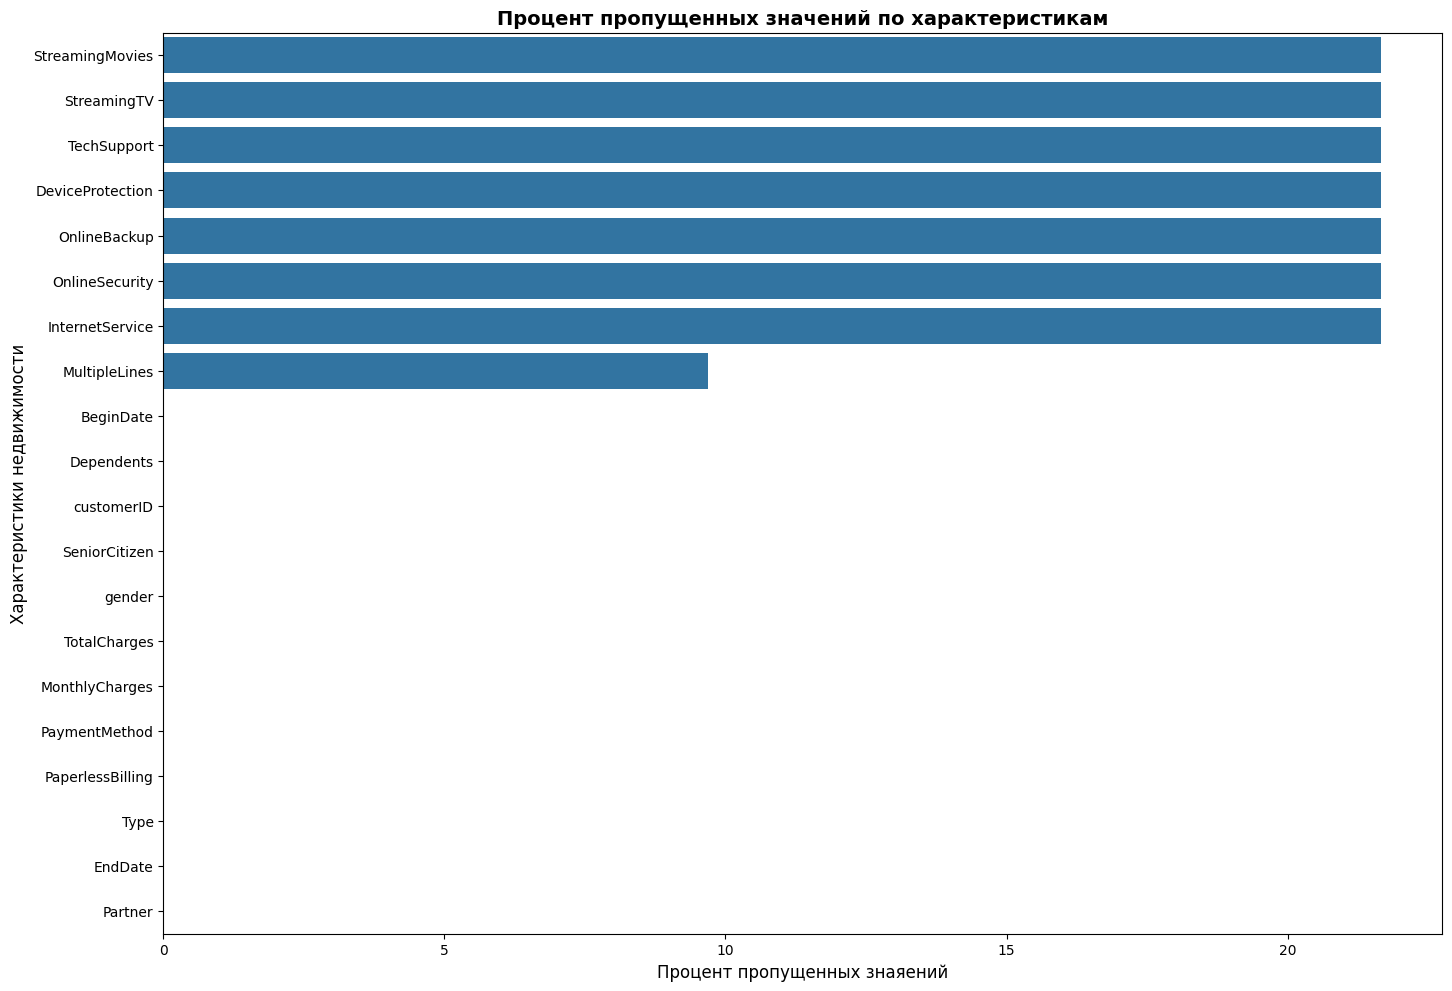

In [20]:
fig, axs = plt.subplots()
sns.barplot(y=data_null.index, x=data_null, color='tab:blue')

plt.ylabel('Характеристики недвижимости', fontsize=12);
plt.xlabel('Процент пропущенных знаяений', fontsize=12);
plt.title('Процент пропущенных значений по характеристикам', fontsize=14, fontweight='bold');

Более 20% клиентов не пользуются интернет сервисом и почти 10% клиентов не пользуются услугами телефонной связи. 

Удаление пропущенных данных приведет к потере более 20% данных, что приведет к искажению результатов и выводов. Так как нам известно, что пропущенные значения появляются у тех клиентов, которые в целом не пользуются какой-либо услугой, то мы можем заполнить их новой категорией. Эта новая категория будет означать, что клиент не подписан на определенную услугу. Так мы сохраним большое количество данных, которые помогут в выявлении зависимостей в исследовательском анализе данных и для модели машинного обучения. Новую категорию назовем `no_sub`.

Пропуски заполним следующим образом:

   1. Проверим действительно ли признаки являются категориальными в таблице.
   2. Добавим новую категорию во всех пропусках.

In [21]:
# посмотрим на значения данных, где есть пропуски
data_nan = data[data.columns[data.isnull().any()]]
data_nan.head()

,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,NaN,DSL,No,Yes,No,No,No,No
1,No,DSL,Yes,No,Yes,No,No,No
2,No,DSL,Yes,Yes,No,No,No,No
3,NaN,DSL,Yes,No,Yes,Yes,No,No
4,No,Fiber optic,No,No,No,No,No,No


Из описания услуг известно, что `InternetService` бывает двух типов (SDL и FiberOptic). Проверим уникальность значений в каждом из признаков.

In [22]:
# функция с выводом названий столбцов и списка уникальных значений
def list_unique(data, columns:list):
    for i in columns:
        print(f"Название признака: {i:<16}  Уникальные значения:{data[i].unique()}")

In [23]:
# вывод уникальных значений для каждого столбца
list_unique(data_nan, data_nan.columns)

Название признака: MultipleLines     Уникальные значения:[nan 'No' 'Yes']
Название признака: InternetService   Уникальные значения:['DSL' 'Fiber optic' nan]
Название признака: OnlineSecurity    Уникальные значения:['No' 'Yes' nan]
Название признака: OnlineBackup      Уникальные значения:['Yes' 'No' nan]
Название признака: DeviceProtection  Уникальные значения:['No' 'Yes' nan]
Название признака: TechSupport       Уникальные значения:['No' 'Yes' nan]
Название признака: StreamingTV       Уникальные значения:['No' 'Yes' nan]
Название признака: StreamingMovies   Уникальные значения:['No' 'Yes' nan]


В уникальных значениях нет расхождений с предоставленными описаниями данных. Заменим все пропущенные значения в общем датасете на `no_sub`.

In [24]:
data[data_nan.columns] = data[data_nan.columns].fillna('no_sub')

Проверим изменения.

In [25]:
#check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 non-null   object 


In [26]:
#check
list_unique(data, data_nan.columns)

Название признака: MultipleLines     Уникальные значения:['no_sub' 'No' 'Yes']
Название признака: InternetService   Уникальные значения:['DSL' 'Fiber optic' 'no_sub']
Название признака: OnlineSecurity    Уникальные значения:['No' 'Yes' 'no_sub']
Название признака: OnlineBackup      Уникальные значения:['Yes' 'No' 'no_sub']
Название признака: DeviceProtection  Уникальные значения:['No' 'Yes' 'no_sub']
Название признака: TechSupport       Уникальные значения:['No' 'Yes' 'no_sub']
Название признака: StreamingTV       Уникальные значения:['No' 'Yes' 'no_sub']
Название признака: StreamingMovies   Уникальные значения:['No' 'Yes' 'no_sub']


Корректировки соответствуют ожиданиям.

### Изменение типа данных

Посмотрим еще раз на информацию о датафрейме и поменяем тип данных в тех признаках, где он не соответствует содержанию.

In [27]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,no_sub,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,no_sub,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 non-null   object 


* `BeginDate` - переведем в тип `datetime`;
* `TotalCharges` - переведем в тип `float`;
* `EndDate` - содержит два типа данных, поэтому пока трогать не будем;
* `SeniorCitizen` - категориальный признак переведем в `object`.

In [29]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

In [30]:
#check
data[['TotalCharges', 'BeginDate', 'SeniorCitizen']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TotalCharges   7032 non-null   float64       
 1   BeginDate      7043 non-null   datetime64[ns]
 2   SeniorCitizen  7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 220.1+ KB


После изменения типа данных в столбце `TotalCharges` появились пропущенные значения. Это связано с тем, что значения имели какие-то лишние символы либо просто пробелы. Таких значений 11, посмотрим на них подробнее.

In [31]:
data.loc[data['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,no_sub,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,Yes,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,no_sub,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,Yes,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


Похоже, что это клиенты, которые заключили договор в дату выгрузки данных `2020-02-01`. Проверим так ли это на самом деле, выгрузив все данные за эту дату.

In [32]:
data.loc[data['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,no_sub,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,Yes,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,no_sub,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,Yes,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


Да, это данные клиентов, у которых совпадает дата заключения договора и дата выгрузки данных. Решения могут быть следующими:
1. Заполнить пропуски, приравняв общую сумму расходов с месячной суммой расходов.
2. Удалить данные с пропусками.

Оставим данные, так как есть достаточный верный способ их заполнения. К тому же эти данные могут повлиять на качество модели в положительную сторону.

In [33]:
# заполним пропуски методом fillna
data['TotalCharges'] = data['TotalCharges'].fillna(data['MonthlyCharges'])

In [34]:
#check
data.loc[data['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,0,Yes,Yes,no_sub,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25,Male,0,No,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75,Male,0,Yes,Yes,Yes,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05,Female,0,Yes,Yes,no_sub,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85,Male,0,Yes,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35,Male,0,Yes,Yes,Yes,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.00,Female,0,Yes,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.70,Male,0,Yes,Yes,No,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub,no_sub
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


In [35]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  MultipleLines     7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

Корректировки соответствуют ожиданиям.

### Дубликаты

In [36]:
data.duplicated().sum()

0

Явных дубликатов не обнаружено. Проверим на наличие неявных дубликатов в категориальных данных.

Создадим список из названий всех категориальных переменных за исключением CustomerID (скорее всего не понадобится) и EndDate (смешанный тип данных).

In [37]:
object_list = data.columns[(data.dtypes == 'object') & (~data.columns.isin (['customerID', 'EndDate']))].tolist()

Проверим уникальные значения в каждой категории на наличие одинаковых вариантов (к примеру *yes* и *ye_s*).

In [38]:
list_unique(data, object_list)

Название признака: Type              Уникальные значения:['Month-to-month' 'One year' 'Two year']
Название признака: PaperlessBilling  Уникальные значения:['Yes' 'No']
Название признака: PaymentMethod     Уникальные значения:['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Название признака: gender            Уникальные значения:['Female' 'Male']
Название признака: SeniorCitizen     Уникальные значения:[0 1]
Название признака: Partner           Уникальные значения:['Yes' 'No']
Название признака: Dependents        Уникальные значения:['No' 'Yes']
Название признака: MultipleLines     Уникальные значения:['no_sub' 'No' 'Yes']
Название признака: InternetService   Уникальные значения:['DSL' 'Fiber optic' 'no_sub']
Название признака: OnlineSecurity    Уникальные значения:['No' 'Yes' 'no_sub']
Название признака: OnlineBackup      Уникальные значения:['Yes' 'No' 'no_sub']
Название признака: DeviceProtection  Уникальные значения:['No' 'Yes' 'no_sub']
На

Расхождений не обнаружено.

### Обработка аномальных значений

В данных два признака с количественным типом переменных. Аномальные значения в них могут повлиять на качество модели, поэтому необходимо проверить на их наличие.

#### Общие расходы

В начале посмотрим на статистические характеристики.

In [39]:
data['TotalCharges'].describe()

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

Максимальное значение в `TotalCharges` сильно отличается от значения медианы.

Посмотрим на распределение значений.

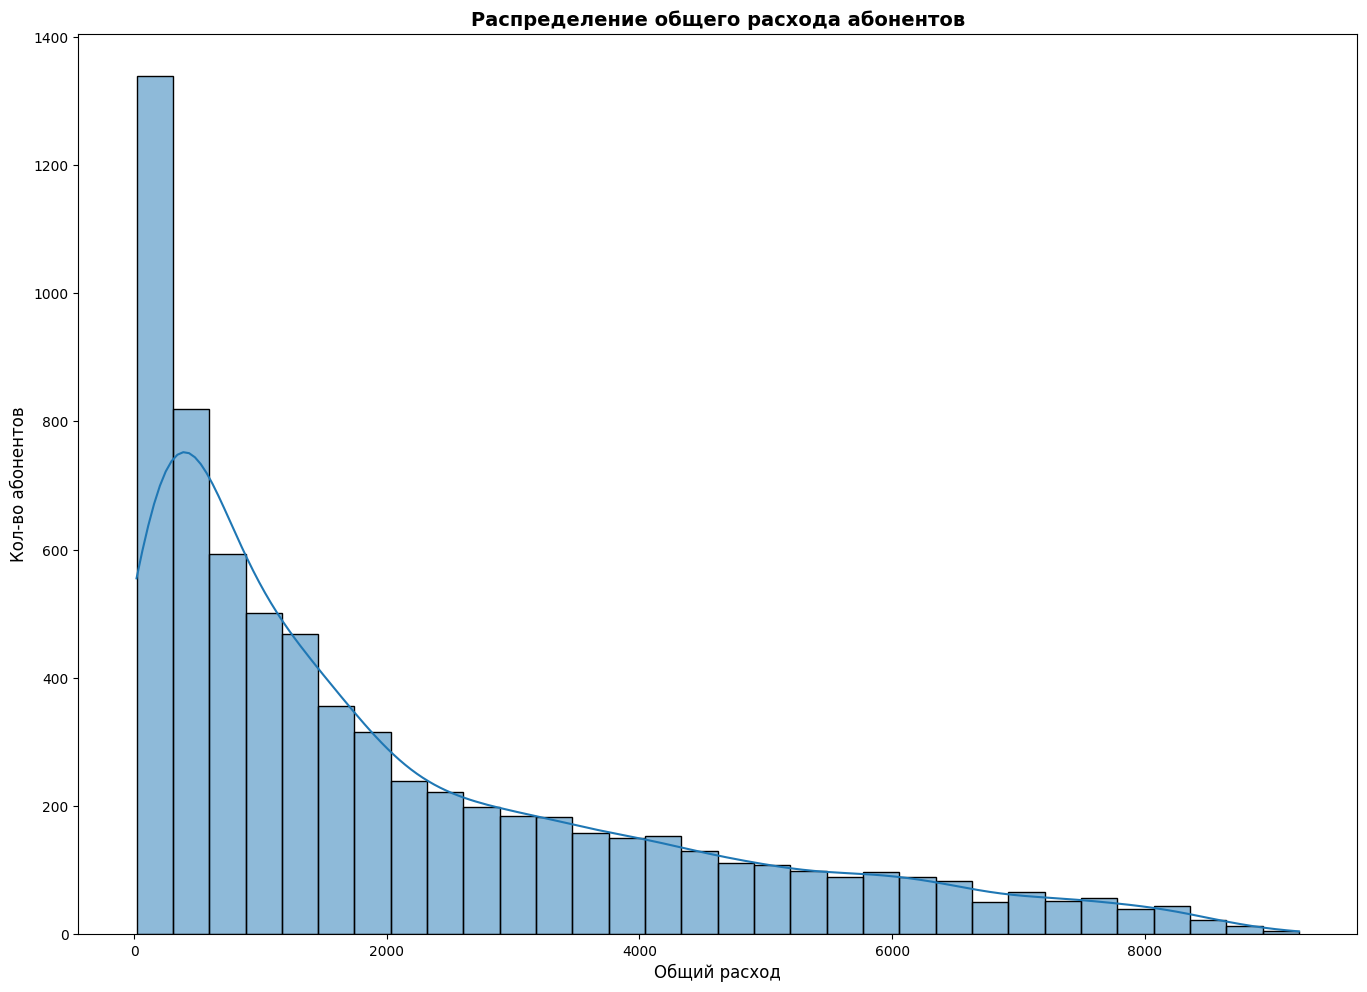

In [40]:
fig, axs = plt.subplots()
sns.histplot(data['TotalCharges'], kde=True, bins='fd')
plt.ylabel('Кол-во абонентов', fontsize=12);
plt.xlabel('Общий расход', fontsize=12);
plt.title('Распределение общего расхода абонентов', fontsize=14, fontweight='bold');

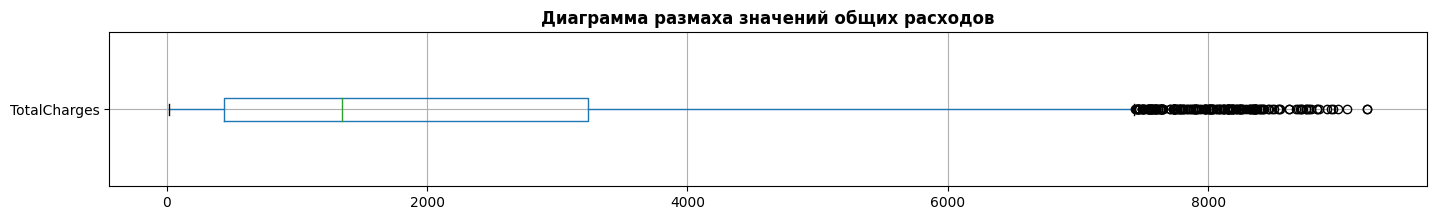

In [41]:
fig, ax = plt.subplots(figsize =(17,2))
ax = data[['TotalCharges']].boxplot(vert=False, ax=ax)
ax.set_title('Диаграмма размаха значений общих расходов', fontweight='bold');

Аномальных значений не обнаружено, но есть выбросы. Чем больше общий расход, тем меньше количество клиентов, что вполне логично. Скорее всего, это абоненты, которые пользуются или пользовались услугами несколько лет. Посмотрим эти данные подробнее

In [42]:
# сначала вычислим межквантильный размах
Q1 = data['TotalCharges'].quantile(0.25)
Q3 = data['TotalCharges'].quantile(0.75)
IQR = Q3 - Q1

In [43]:
# выполним срез данных по верхней границе
total_charges = data.query('TotalCharges > @Q3 + 1.5 * @IQR')

In [44]:
total_charges.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,195.0,110.407692,4.477811,94.25,107.475,110.50,114.2,118.60
TotalCharges,195.0,8034.321282,415.363287,7439.47,7652.275,8008.31,8317.8,9221.38


Всего таких клиентов 195 и у них месячные траты мало отличаются. Посмотрим сколько из этих клиентов поменяли компанию.

In [45]:
total_charges['EndDate'].value_counts()

No            192
2019-10-01      1
2019-05-01      1
2020-01-01      1
Name: EndDate, dtype: int64

Всего три клиента отказались от использования услуг оператора. Посмотрим на данные этих клиентов

In [46]:
# три клиента, разорвавшие договор
total_charges.query('EndDate != "No"')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3517,0748-RDGGM,2014-02-01,2019-10-01,One year,Yes,Bank transfer (automatic),109.50,7594.92,Male,0,Yes,No,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
4737,9298-WGMRW,2014-02-01,2019-05-01,Two year,Yes,Bank transfer (automatic),115.50,7567.56,Female,0,Yes,No,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
6035,9835-ZIITK,2014-06-01,2020-01-01,One year,Yes,Electronic check,110.85,7649.76,Male,1,Yes,No,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes


In [47]:
# те, кто до сих пор пользуется услугами
total_charges.query('EndDate == "No"').head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
17,9959-WOFKT,2014-03-01,No,Two year,No,Bank transfer (automatic),106.70,8257.51,Male,0,No,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes
57,5067-XJQFU,2014-08-01,No,One year,Yes,Electronic check,108.45,7730.32,Male,1,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
59,5954-BDFSG,2014-02-01,No,Two year,Yes,Credit card (automatic),107.50,7740.00,Female,0,No,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes
106,6728-DKUCO,2014-02-01,No,One year,Yes,Electronic check,104.15,7498.80,Female,0,Yes,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,Yes
198,7255-SSFBC,2014-02-01,No,Two year,Yes,Bank transfer (automatic),112.25,8324.46,Male,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
369,3520-FJGCV,2014-02-01,No,Two year,Yes,Credit card (automatic),112.60,8755.78,Male,0,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
437,4376-KFVRS,2014-02-01,No,Two year,Yes,Credit card (automatic),114.05,8211.60,Male,0,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
449,1090-ESELR,2014-02-01,No,Two year,No,Bank transfer (automatic),105.50,7596.00,Male,0,Yes,Yes,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes
464,1480-BKXGA,2014-02-01,No,Two year,Yes,Bank transfer (automatic),116.05,8355.60,Male,1,Yes,No,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
483,5168-MQQCA,2014-02-01,No,One year,Yes,Bank transfer (automatic),108.50,8358.84,Female,0,Yes,No,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes


Видим, что данные мало чем отличаются. Расходы за месяц у ушедших клиентов зачастую больше, но непонятно усредненные ли это значения. Вполне вероятно, что отказ от услуг мог быть связан с личными обстоятельствами (переезд  и т.д.). Предугадать уход таких клиентов возможно при условии ведения ежемесячных расходов с момента подключения.

Посмотрим на значение дат начала договора.

In [48]:
total_charges['BeginDate'].value_counts().sort_index()

2013-10-01      2
2013-11-01      2
2014-02-01    105
2014-03-01     28
2014-04-01     14
2014-05-01     11
2014-06-01     10
2014-07-01      5
2014-08-01      9
2014-09-01      2
2014-10-01      3
2014-11-01      1
2014-12-01      2
2015-02-01      1
Name: BeginDate, dtype: int64

Больше половины из этих абонентов заключили договор в феврале 2014 года.

Нет ясности как поступить с такими данными, ведь аномальных значений нет, а распределение соответствует ожиданию. Попробуем исследовать зависимость от срока длительности контракта в шаге `Исследовательский анализ данных`, а пока оставим без изменений.

#### Расходы за месяц

Посмотри на статистику расходов за месяц.

In [49]:
data['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

Каких-либо аномалий в данных незаметно. Посмотрим на распределение.

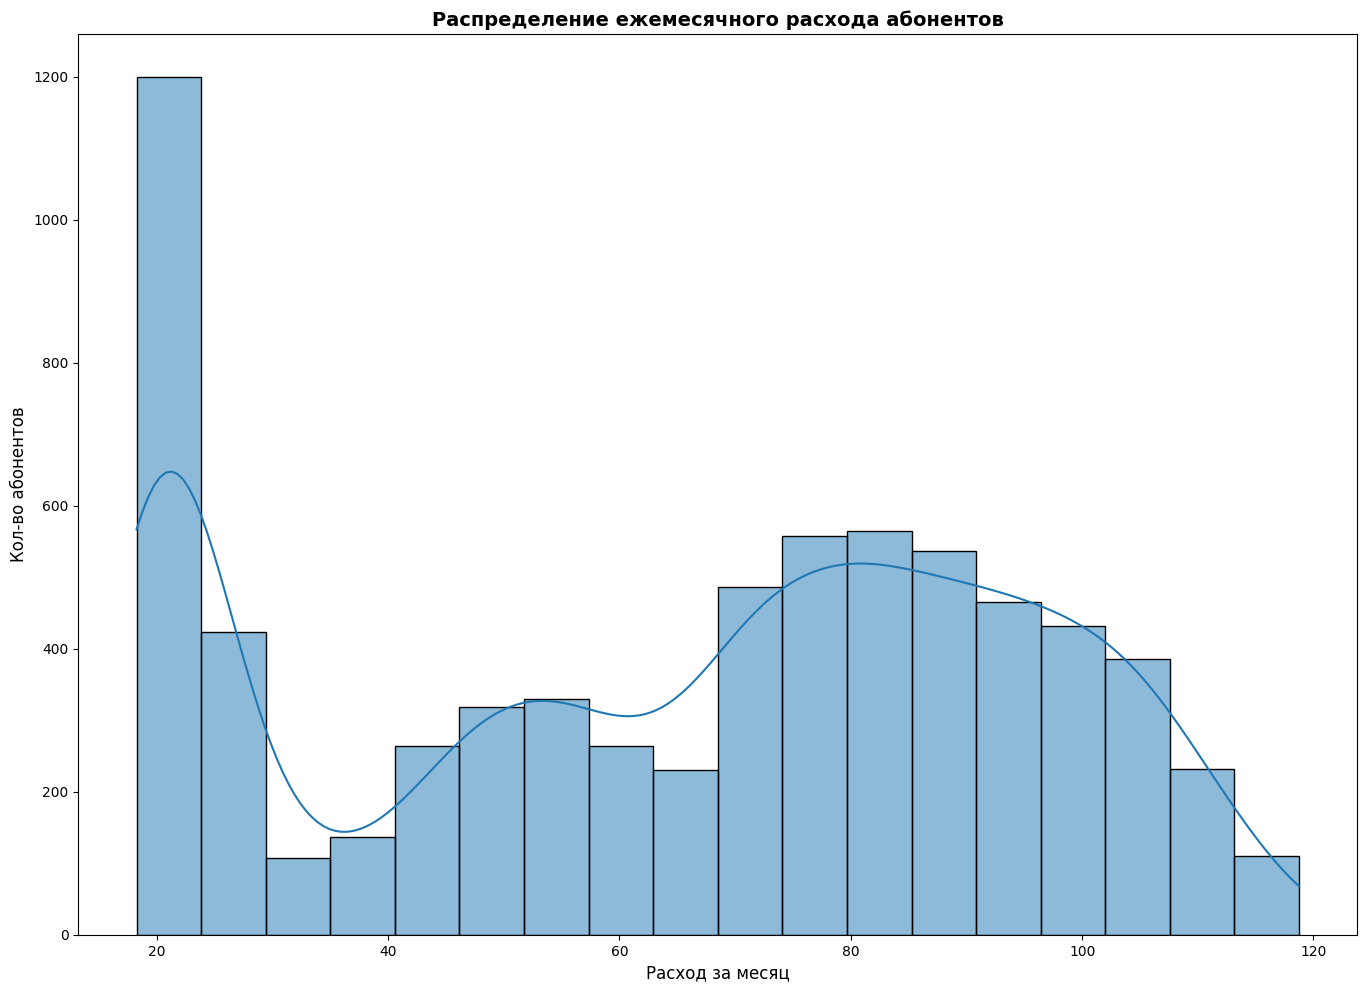

In [50]:
fig, axs = plt.subplots()
sns.histplot(data['MonthlyCharges'], kde=True)
plt.ylabel('Кол-во абонентов', fontsize=12);
plt.xlabel('Расход за месяц', fontsize=12);
plt.title('Распределение ежемесячного расхода абонентов', fontsize=14, fontweight='bold');

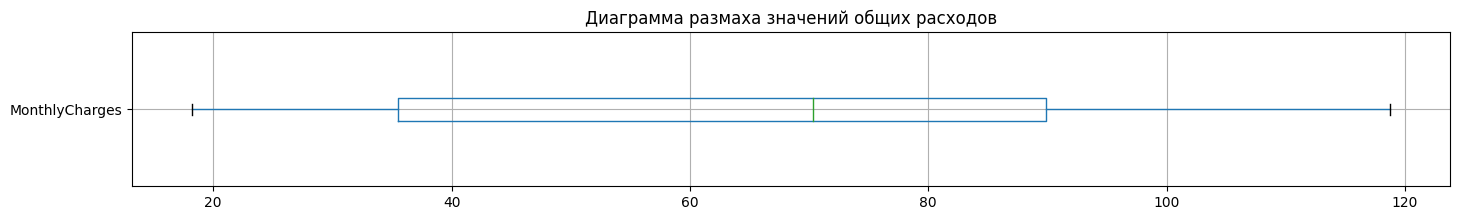

In [51]:
fig, ax = plt.subplots(figsize=(17,2))
ax = data[['MonthlyCharges']].boxplot(vert=False, ax=ax)
ax.set_title('Диаграмма размаха значений общих расходов');

Выбросов в данных не обнаружено, но есть особенность распределения. Можно выделить 3 группы клиентов в зависимости от размера платежей:
1. До 35 - эконом
2. 36-65 - средние
3.  66 вип

В дальнейшем эту особенность можно будет использовать для создания новых признаков для моделей машинного обучения.


### Вывод

В ходе предобработки данных были внесены следующие изменения:

* пропущенные значения, появившиеся после объединения таблиц, были заполнены третьей категорией `no_sub`;
* типы данных в столбцах с признаками `BeginDate`, `TotalCharges` и `SeniorCitizen` были изменены на ожидаемые;
    * `EndDate` было решено обработать позже (вместе с созданием целевой переменной);
    * в столбце `TotalCharges` появились 11 пропущенных значений после изменения типа данных, было решено удалить их;
* дубликатов не обнаружено;
* аномалий не обнаружено.

Данные до и после внесенных изменений:

In [52]:
dfs = [data_raw, data]
for df in dfs:
    ICD(df.info())  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  MultipleLines     7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

None

Далее перейдем к созданию новых признаков.

## Новые признаки

Создадим целевой признак `exited`, который означает ушел ли клиент или нет (1 - да, 0 - нет). Также, дополнительно, создадим новый признак с количеством дней действия договора (`days_count`) для повышения точности предсказания моделей.

### Целевой признак

Посмотрим на уникальные значения в дате прекращения и начала договора.

In [53]:
sorted(data['EndDate'].unique())

['2014-06-01',
 '2014-09-01',
 '2014-10-01',
 '2014-11-01',
 '2014-12-01',
 '2015-01-01',
 '2015-02-01',
 '2015-03-01',
 '2015-04-01',
 '2015-05-01',
 '2015-06-01',
 '2015-07-01',
 '2015-08-01',
 '2015-09-01',
 '2015-10-01',
 '2015-11-01',
 '2015-12-01',
 '2016-01-01',
 '2016-02-01',
 '2016-03-01',
 '2016-04-01',
 '2016-05-01',
 '2016-06-01',
 '2016-07-01',
 '2016-08-01',
 '2016-09-01',
 '2016-10-01',
 '2016-11-01',
 '2016-12-01',
 '2017-01-01',
 '2017-02-01',
 '2017-03-01',
 '2017-04-01',
 '2017-05-01',
 '2017-06-01',
 '2017-07-01',
 '2017-08-01',
 '2017-09-01',
 '2017-10-01',
 '2017-11-01',
 '2017-12-01',
 '2018-01-01',
 '2018-02-01',
 '2018-03-01',
 '2018-04-01',
 '2018-05-01',
 '2018-06-01',
 '2018-07-01',
 '2018-08-01',
 '2018-09-01',
 '2018-10-01',
 '2018-11-01',
 '2018-12-01',
 '2019-01-01',
 '2019-02-01',
 '2019-03-01',
 '2019-04-01',
 '2019-05-01',
 '2019-06-01',
 '2019-07-01',
 '2019-08-01',
 '2019-09-01',
 '2019-10-01',
 '2019-11-01',
 '2019-12-01',
 '2020-01-01',
 'No']

In [54]:
sorted(data.BeginDate.unique())

[numpy.datetime64('2013-10-01T00:00:00.000000000'),
 numpy.datetime64('2013-11-01T00:00:00.000000000'),
 numpy.datetime64('2013-12-01T00:00:00.000000000'),
 numpy.datetime64('2014-01-01T00:00:00.000000000'),
 numpy.datetime64('2014-02-01T00:00:00.000000000'),
 numpy.datetime64('2014-03-01T00:00:00.000000000'),
 numpy.datetime64('2014-04-01T00:00:00.000000000'),
 numpy.datetime64('2014-05-01T00:00:00.000000000'),
 numpy.datetime64('2014-06-01T00:00:00.000000000'),
 numpy.datetime64('2014-07-01T00:00:00.000000000'),
 numpy.datetime64('2014-08-01T00:00:00.000000000'),
 numpy.datetime64('2014-09-01T00:00:00.000000000'),
 numpy.datetime64('2014-10-01T00:00:00.000000000'),
 numpy.datetime64('2014-11-01T00:00:00.000000000'),
 numpy.datetime64('2014-12-01T00:00:00.000000000'),
 numpy.datetime64('2015-01-01T00:00:00.000000000'),
 numpy.datetime64('2015-02-01T00:00:00.000000000'),
 numpy.datetime64('2015-03-01T00:00:00.000000000'),
 numpy.datetime64('2015-04-01T00:00:00.000000000'),
 numpy.datet

Каждый месяц первого числа обновляются данные за предыдущий месяц. Последнее обновление начала договоров `BeginDate` было в `2020-01-01`. Клиенты, которые все еще пользуются услугами отмечены `No` в данных о дате окончания договора `EndDate`. У остальных клиентов поставленная дата разрыва договора. В дальнейшем эти данные понадобятся для анализа, поэтому сделаем следующее:
1. Создадим целевой признак по условия отметок полей признака `EndDate`.
2. Заменим отметки `No` в `EndDate` на `2020-02-01`, чтобы можно было отличить неушедших клиентов.

In [55]:
# новый признак
data['exited'] = '1'
data['exited'] = data['exited'].where(data['EndDate']!='No', '0')

In [56]:
# поменяем тип данных на числовой для удобства отрисовки графиков
data['exited'] = pd.to_numeric(data['exited'], errors='coerce')

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Целевой признак выделен корректно.

In [57]:
# замена 'No'
data['EndDate'] = data['EndDate'].where(data['EndDate'] != 'No', '2020-02-01')

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Заглушку в `EndDate` заменили на дату выгрузки из базы - верное решение.

In [58]:
# перевод в datetime
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

Проверим внесенные изменения

In [59]:
data[data['exited']==1].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,exited
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,Yes,No,DSL,Yes,Yes,No,No,No,No,1
15,3655-SNQYZ,2014-05-01,2016-03-01,Two year,No,Credit card (automatic),113.25,2491.50,Female,0,...,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,1
25,6865-JZNKO,2017-08-01,2018-09-01,Month-to-month,Yes,Bank transfer (automatic),55.30,726.09,Female,0,...,No,No,DSL,Yes,Yes,No,No,No,No,1
30,3841-NFECX,2014-03-01,2018-11-01,Two year,Yes,Credit card (automatic),96.35,5395.60,Female,1,...,No,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,1
35,6234-RAAPL,2014-02-01,2018-12-01,Two year,No,Bank transfer (automatic),99.90,5794.20,Female,0,...,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,No,1


In [60]:
data[data['exited']==0].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,exited
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,no_sub,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,No,DSL,Yes,Yes,No,No,No,No,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,no_sub,DSL,Yes,No,Yes,Yes,No,No,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,Fiber optic,No,No,No,No,No,No,0


In [61]:
sorted(data['BeginDate'].unique())

[numpy.datetime64('2013-10-01T00:00:00.000000000'),
 numpy.datetime64('2013-11-01T00:00:00.000000000'),
 numpy.datetime64('2013-12-01T00:00:00.000000000'),
 numpy.datetime64('2014-01-01T00:00:00.000000000'),
 numpy.datetime64('2014-02-01T00:00:00.000000000'),
 numpy.datetime64('2014-03-01T00:00:00.000000000'),
 numpy.datetime64('2014-04-01T00:00:00.000000000'),
 numpy.datetime64('2014-05-01T00:00:00.000000000'),
 numpy.datetime64('2014-06-01T00:00:00.000000000'),
 numpy.datetime64('2014-07-01T00:00:00.000000000'),
 numpy.datetime64('2014-08-01T00:00:00.000000000'),
 numpy.datetime64('2014-09-01T00:00:00.000000000'),
 numpy.datetime64('2014-10-01T00:00:00.000000000'),
 numpy.datetime64('2014-11-01T00:00:00.000000000'),
 numpy.datetime64('2014-12-01T00:00:00.000000000'),
 numpy.datetime64('2015-01-01T00:00:00.000000000'),
 numpy.datetime64('2015-02-01T00:00:00.000000000'),
 numpy.datetime64('2015-03-01T00:00:00.000000000'),
 numpy.datetime64('2015-04-01T00:00:00.000000000'),
 numpy.datet

In [62]:
sorted(data['EndDate'].unique())

[numpy.datetime64('2014-06-01T00:00:00.000000000'),
 numpy.datetime64('2014-09-01T00:00:00.000000000'),
 numpy.datetime64('2014-10-01T00:00:00.000000000'),
 numpy.datetime64('2014-11-01T00:00:00.000000000'),
 numpy.datetime64('2014-12-01T00:00:00.000000000'),
 numpy.datetime64('2015-01-01T00:00:00.000000000'),
 numpy.datetime64('2015-02-01T00:00:00.000000000'),
 numpy.datetime64('2015-03-01T00:00:00.000000000'),
 numpy.datetime64('2015-04-01T00:00:00.000000000'),
 numpy.datetime64('2015-05-01T00:00:00.000000000'),
 numpy.datetime64('2015-06-01T00:00:00.000000000'),
 numpy.datetime64('2015-07-01T00:00:00.000000000'),
 numpy.datetime64('2015-08-01T00:00:00.000000000'),
 numpy.datetime64('2015-09-01T00:00:00.000000000'),
 numpy.datetime64('2015-10-01T00:00:00.000000000'),
 numpy.datetime64('2015-11-01T00:00:00.000000000'),
 numpy.datetime64('2015-12-01T00:00:00.000000000'),
 numpy.datetime64('2016-01-01T00:00:00.000000000'),
 numpy.datetime64('2016-02-01T00:00:00.000000000'),
 numpy.datet

### Количество дней действия договора

Разность соответствующих ячеек в столбцах `EndDate` и `BeginDate` даст значение дней `days_count`.

In [63]:
data['days_count'] =  (data['EndDate'] - data['BeginDate']).dt.days

In [64]:
# check
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,exited,days_count
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,no_sub,DSL,No,Yes,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,no_sub,DSL,Yes,No,Yes,Yes,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,0,153


### Вывод

Добавили целевой (`exited`) и новый категориальный признак (`days_count`), обозначающий количество дней действия договора. 

Изменили тип данных `EndDate`. Присвоили значение `2020-02-01` в столбце с датой окончания договора тем клиентам, которые не разорвали договор. 

Так выглядит датафрейм после преобразований:

In [65]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,exited,days_count
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,no_sub,DSL,No,Yes,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,no_sub,DSL,Yes,No,Yes,Yes,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,0,153


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  MultipleLines     7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

## Исследовательский анализ данных

Выполним исследовательский анализ данных, чтобы подготовить выборку для машинного обучения. Для этого выполним следующие шаги:

1. Посмотрим на распределение количественных и категориальных признаков в зависимости от целевого признака `exited`.
2. Устраним мультиколлинеарность признаков.
3. На основе анализа удалим признаки, которые не потребуются для машинного обучения.

### Распределение количественных признаков

Распределение по суммарным и месячным расходам уже смотрели в обработке аномальных значений, но не учитывалось ушел ли клиент.

Посмотрим на распределение количества клиентов по дате начала договора `BegindDate` и по дате разрыва договора `EndDate`. Так же на распределение расходов клиентов в зависимости от целевого признака.

#### Новые клиенты

Учитывая, что данные обновляются первого числа каждого месяца, построим столбчатую диаграмму количества новых клиентов по году-месяцу.

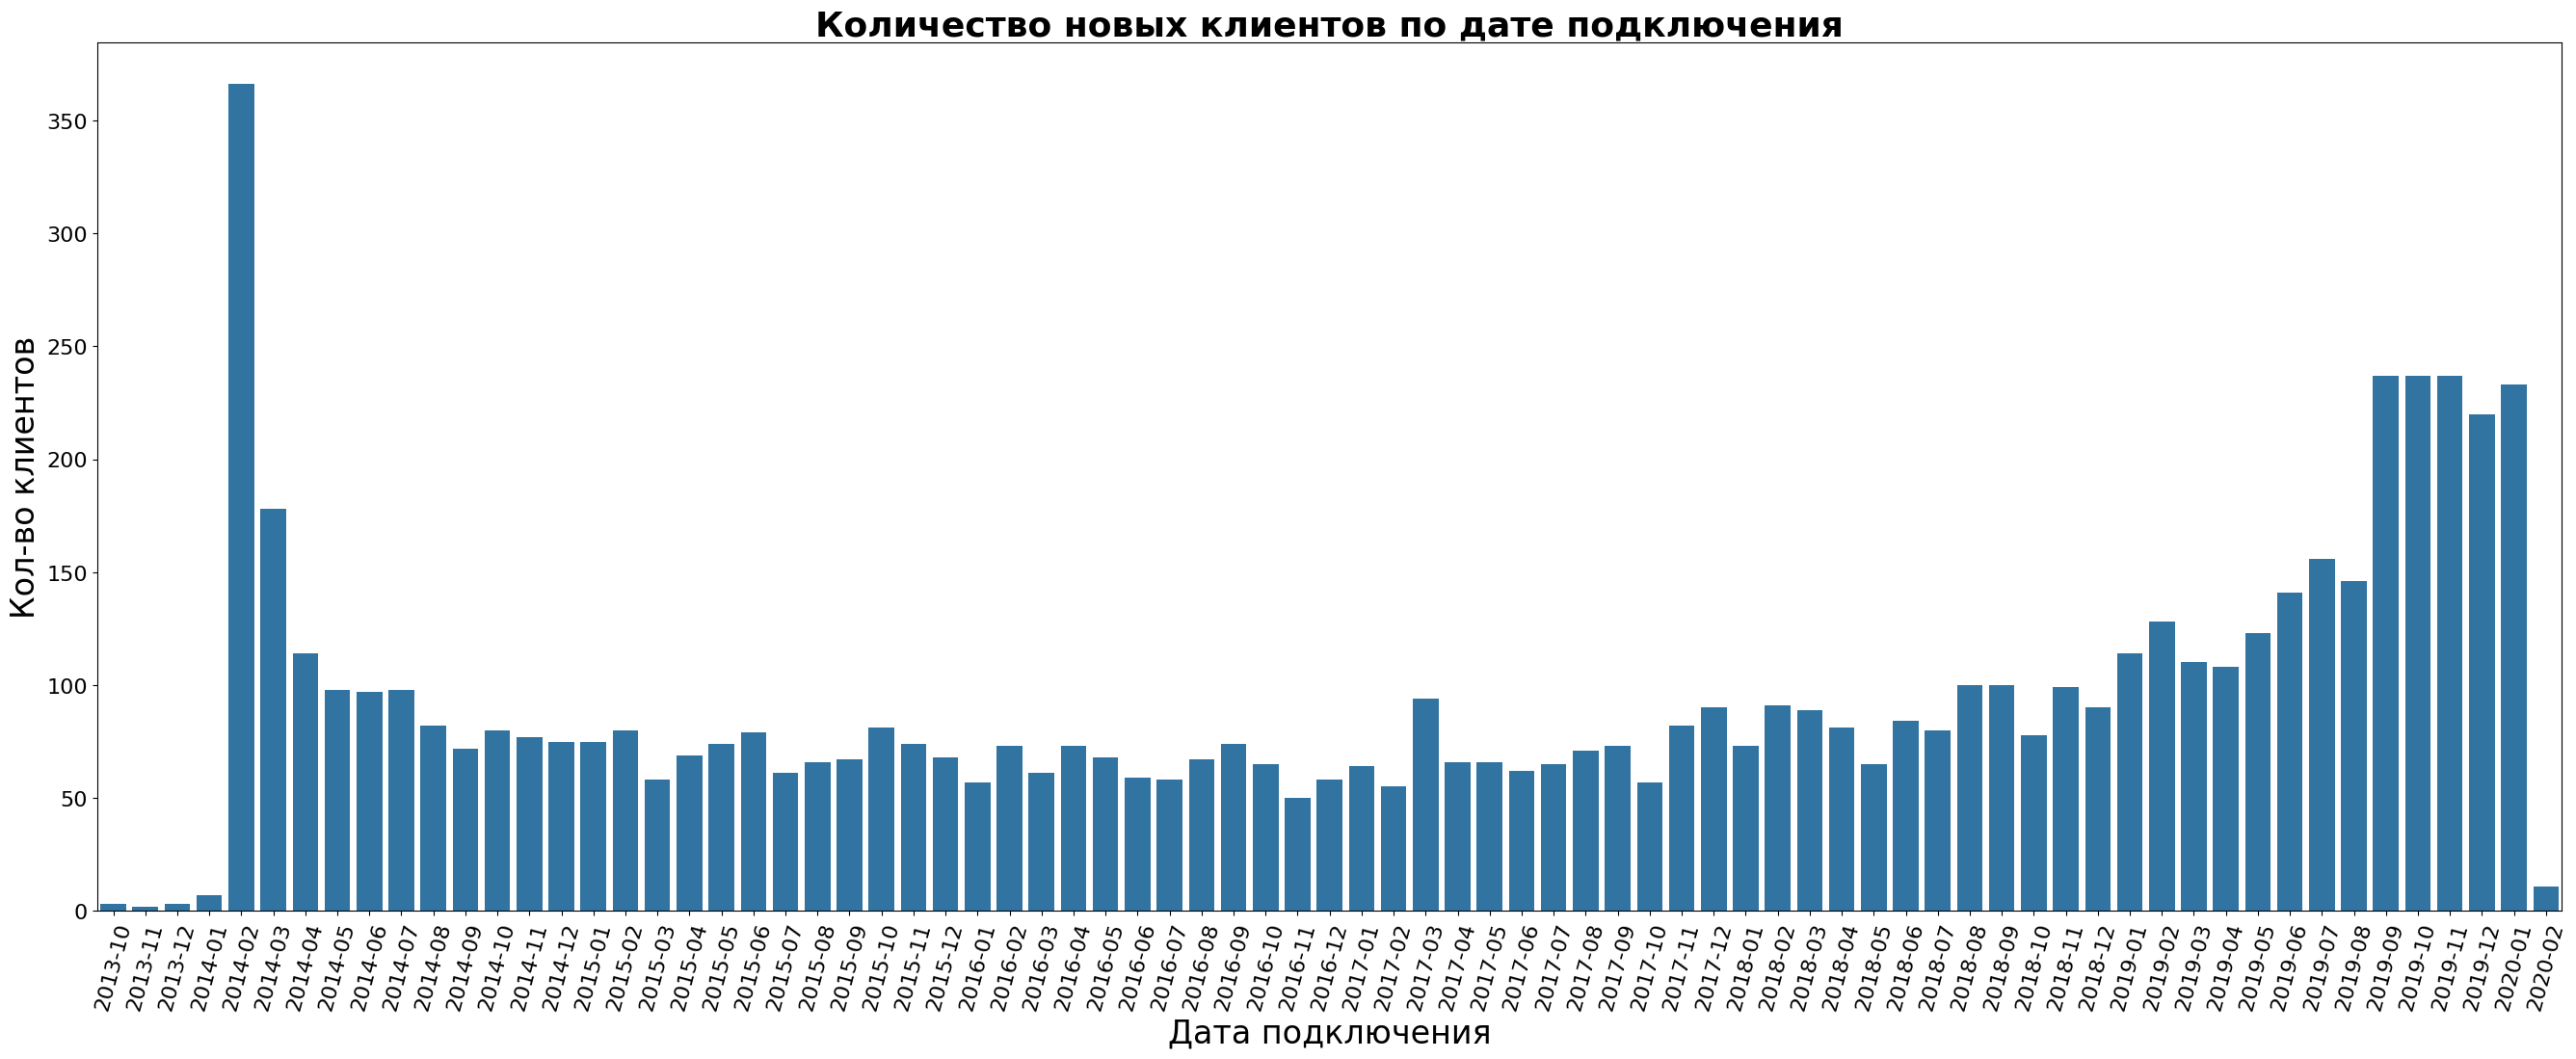

In [67]:
date_barplot(data, 'BeginDate', 'Количество новых клиентов по дате подключения', 33, 11.7)

Из графика видно, что: 
* в феврале 2014 года произошел резкий скачок вверх (реклама, скидки и т.д.);
* с сентября 2019 по янвраль 2020 количество новых клиентов не изменялось и являлось самым большим за весь период (не учитывая скачок в 2014);
* в остальной период количество новых клиентов не изменялось.

#### Покинувшие клиенты

Построим такую же диаграмму для клиентов, которые разорвали договор.

In [68]:
# ранее заменяли значения No в дате разрыва договора на 2020-02-01
# сделаем срез без учета этой даты
data_end = data.copy()
data_end = data_end.query('EndDate != "2020-02-01"')

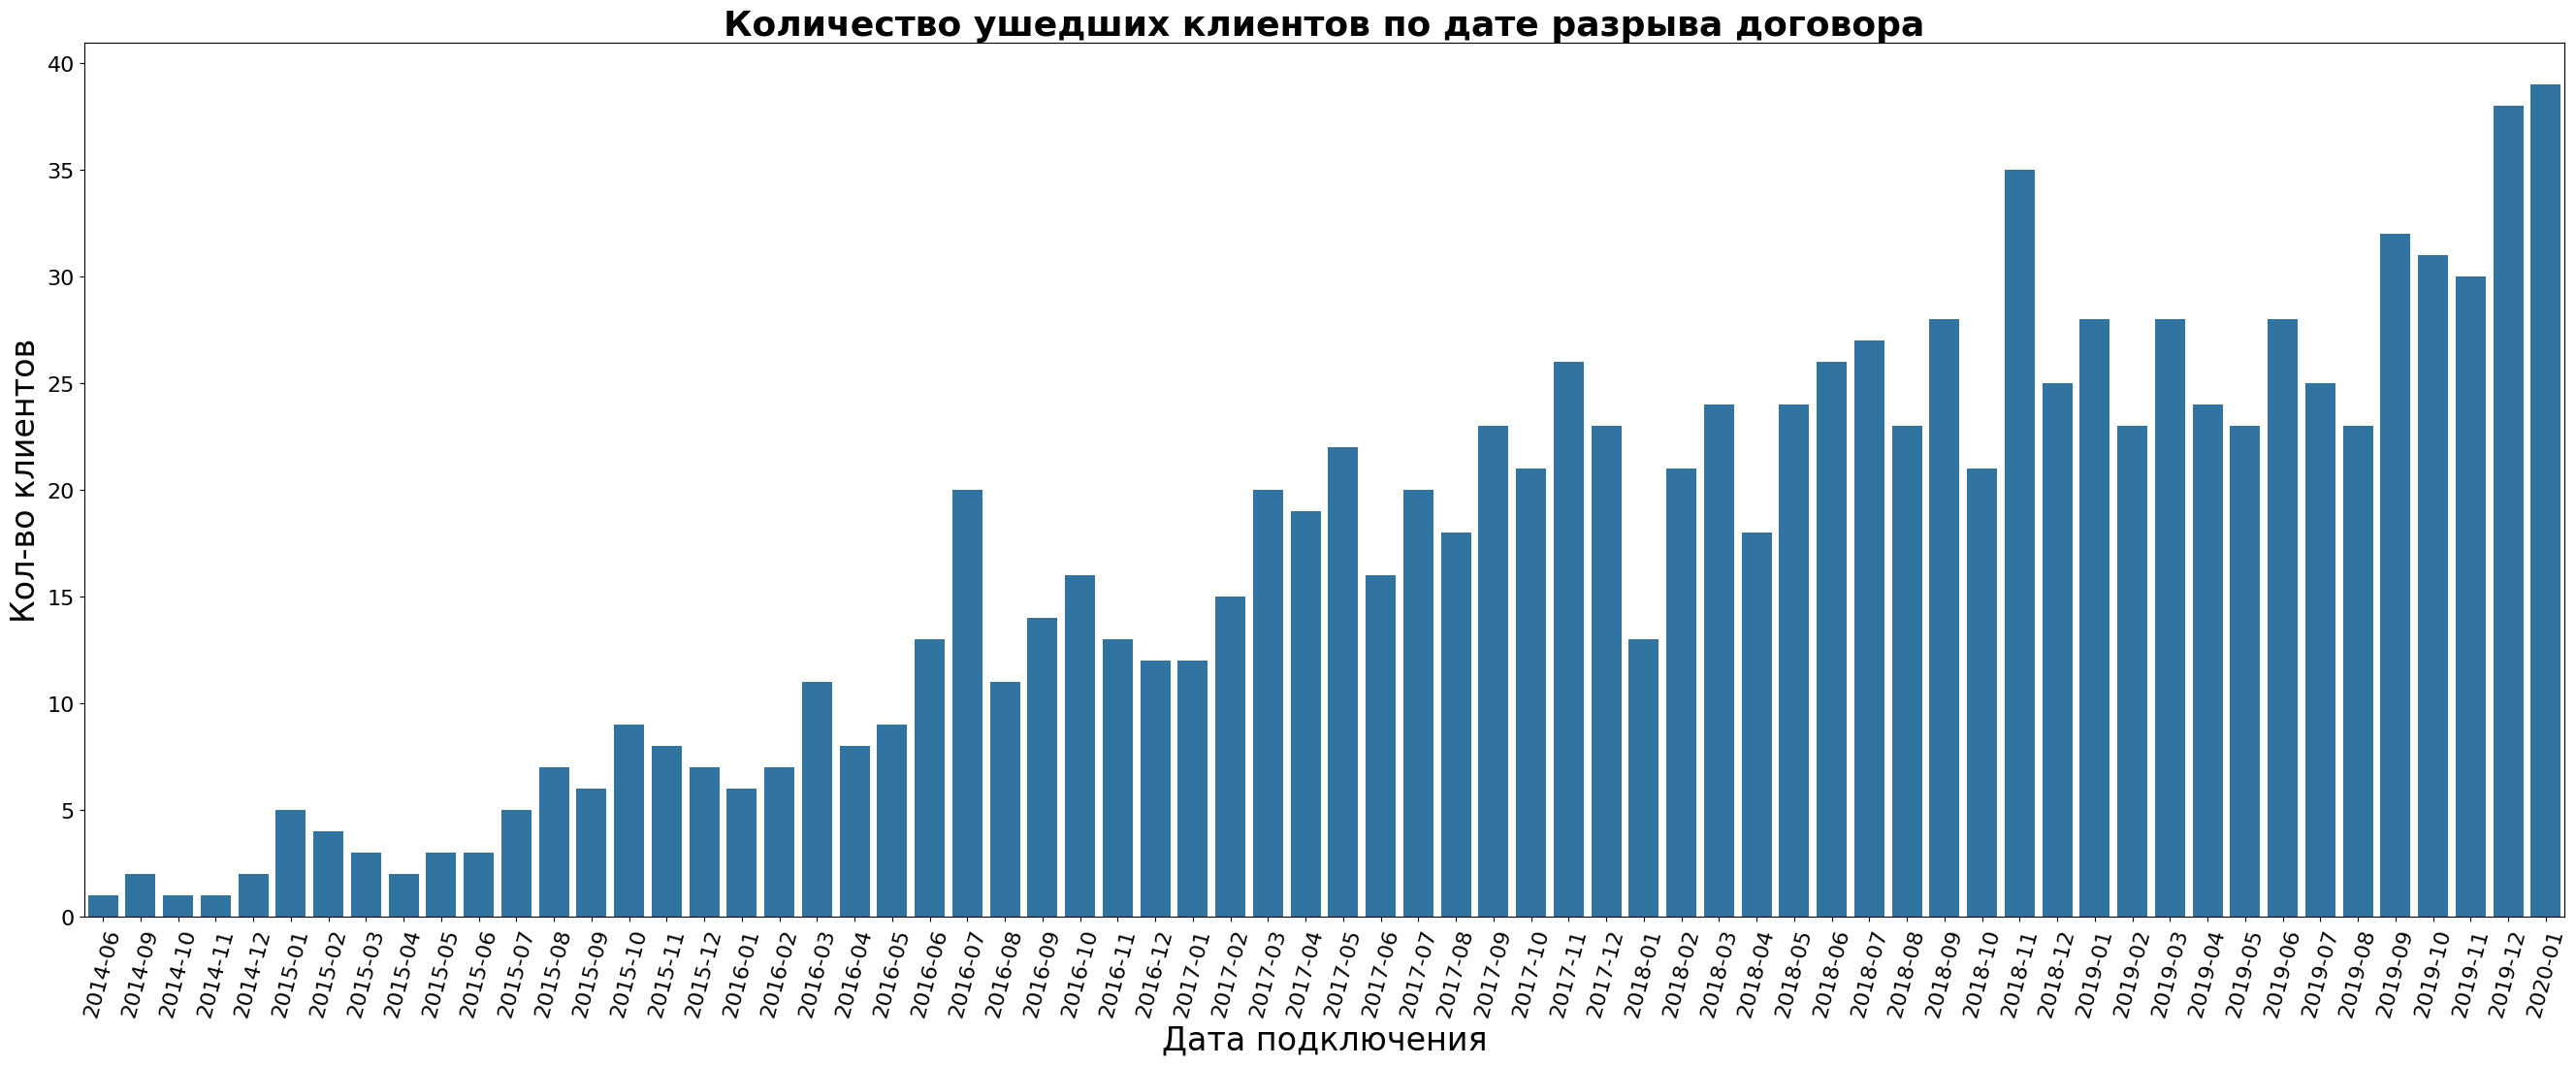

In [69]:
date_barplot(data_end, 'EndDate', 'Количество ушедших клиентов по дате разрыва договора', 33, 11.7)

* по каким-то причинам (технический сбой, человеческий фактор и т.д.) отсутствует информация с июля по август 2014 года;
* последние два месяца наблюдается наибольший отток клиентов;
* почти с каждым месяцом отток увеличивается

Возможные причины этого явления:
* плохая рекламная кампания;
* лучшие условия у конкурентов;
* неактуальность услуг.

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хороший анализ временных признаков.

#### Месячный расход клиентов по целевому признаку

При анализе непрерывных переменных интерес представляет диапазон значений, при которых отток выше, чем сохранение пользователей Для такого анализа можно использовать `sns.histplot()` с `stat='density'` - ядерная оценка плотности.

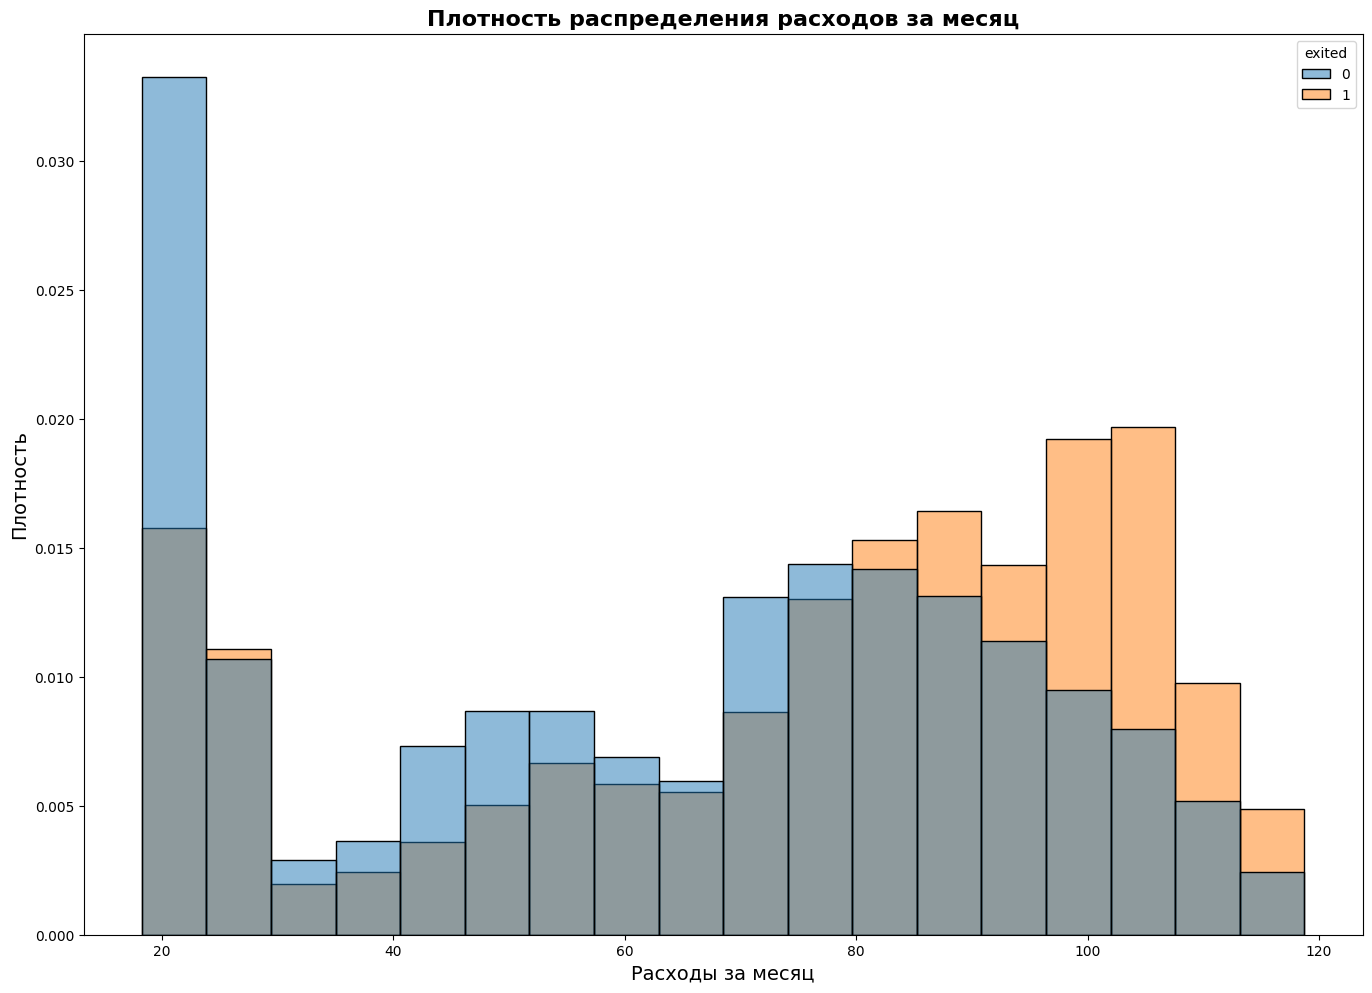

In [70]:
hist_cont(
    df=data, 
    x=data['MonthlyCharges'], 
    hue=data['exited'],
    xlabel= 'Расходы за месяц',
    title='Плотность распределения расходов за месяц'
)

In [71]:
data['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

Заметно, что:

1. В распределении выделяется диапозон с месячным расходом 80 - 120 единиц как самый отточный.
2. Примерно 75% клиентов заплатили почти 90 единиц в месяц.

#### Суммарный расход клиентов по целевому признаку

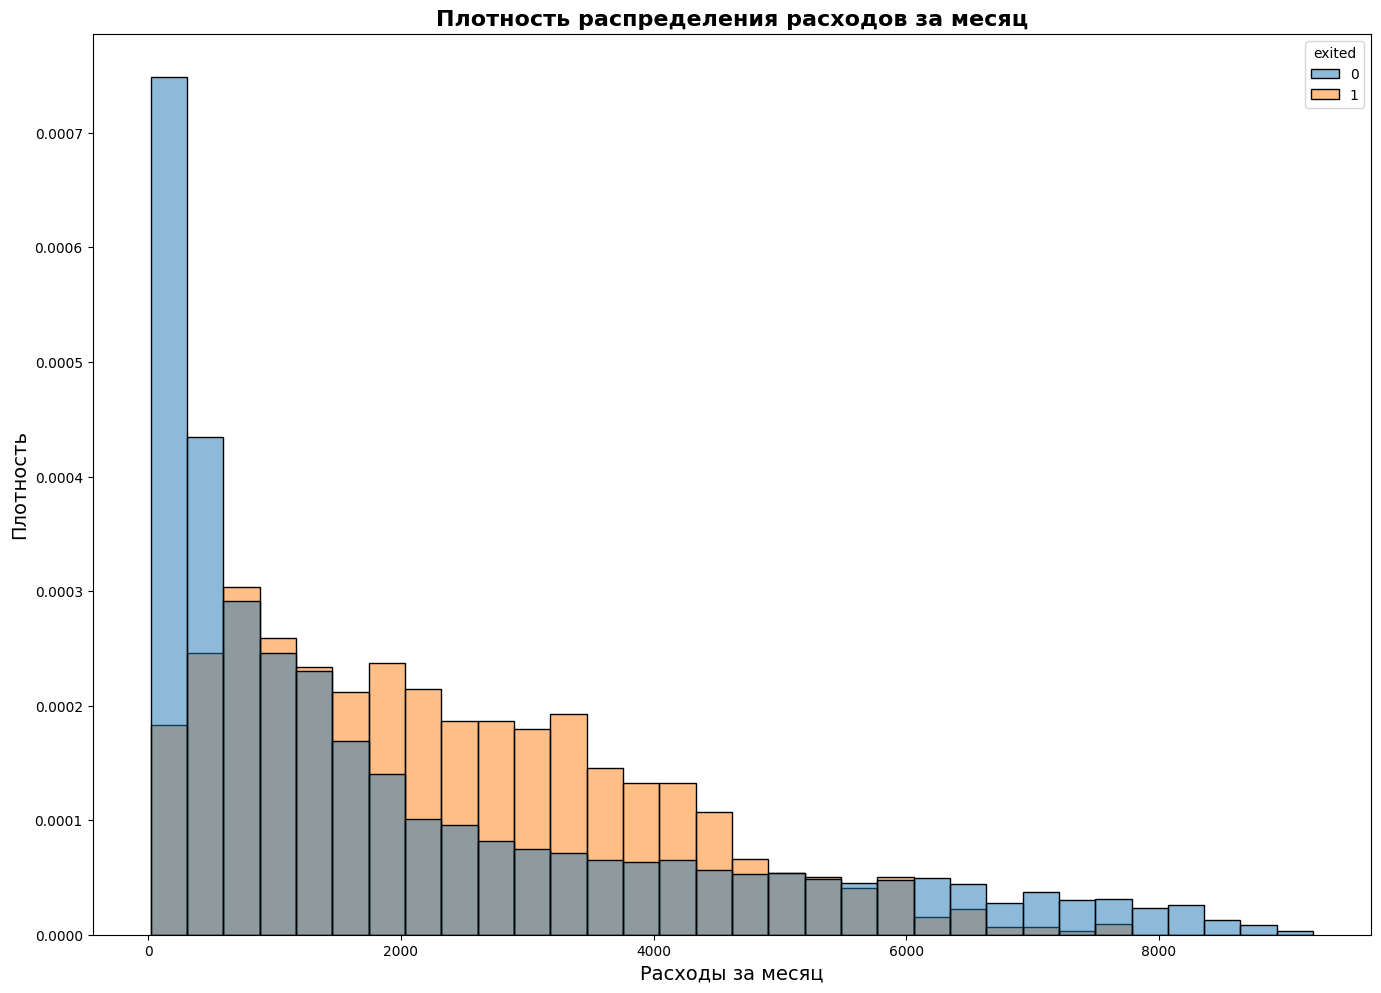

In [72]:
hist_cont(
    df=data, 
    x=data['TotalCharges'], 
    hue=data['exited'],
    xlabel= 'Расходы за месяц',
    title='Плотность распределения расходов за месяц'
)

In [73]:
data['TotalCharges'].describe()

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

Видим, что:
1. Наиболее отточный диапозон клиентов с суммарным расходом примерно 1800 - 4500.
2. У большинства клиентов суммарный расход менее 3000 единиц.
3. Очень мало клиентов с суммарным расходом бало 6000 единиц.


#### Суммарный расход и срок договора

Посмотрим на зависимость двух количественных признаков `TotalCharges` и `days_count`.

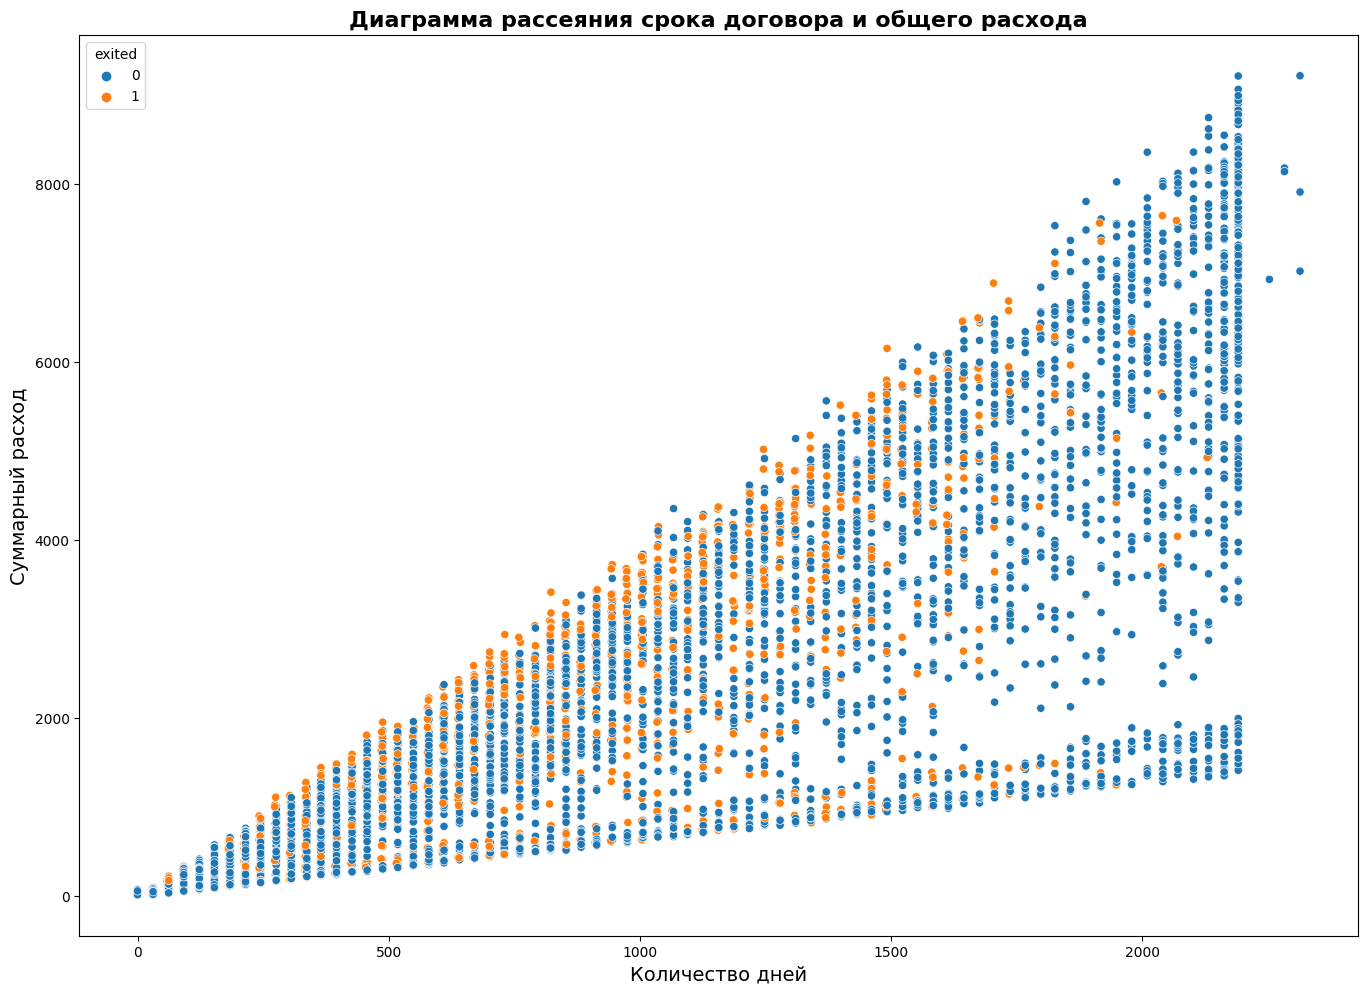

In [74]:
fig, ax = plt.subplots()
ax = sns.scatterplot(y=data['TotalCharges'], x=data["days_count"], hue=data['exited'])
plt.title('Диаграмма рассеяния срока договора и общего расхода', fontsize=16, fontweight='bold')
plt.xlabel('Количество дней', fontsize=14)
plt.ylabel('Суммарный расход', fontsize=14)
plt.show()

* Чаще уходят клиенты, у которых большой суммарный расход;
* Отток случается чаще в диапозоне 500-1500 дней;
* В данных есть несколько клиентов с аномальным сроком действия договора.

На графике распределения новых клиентов слева был заметен "хвост".

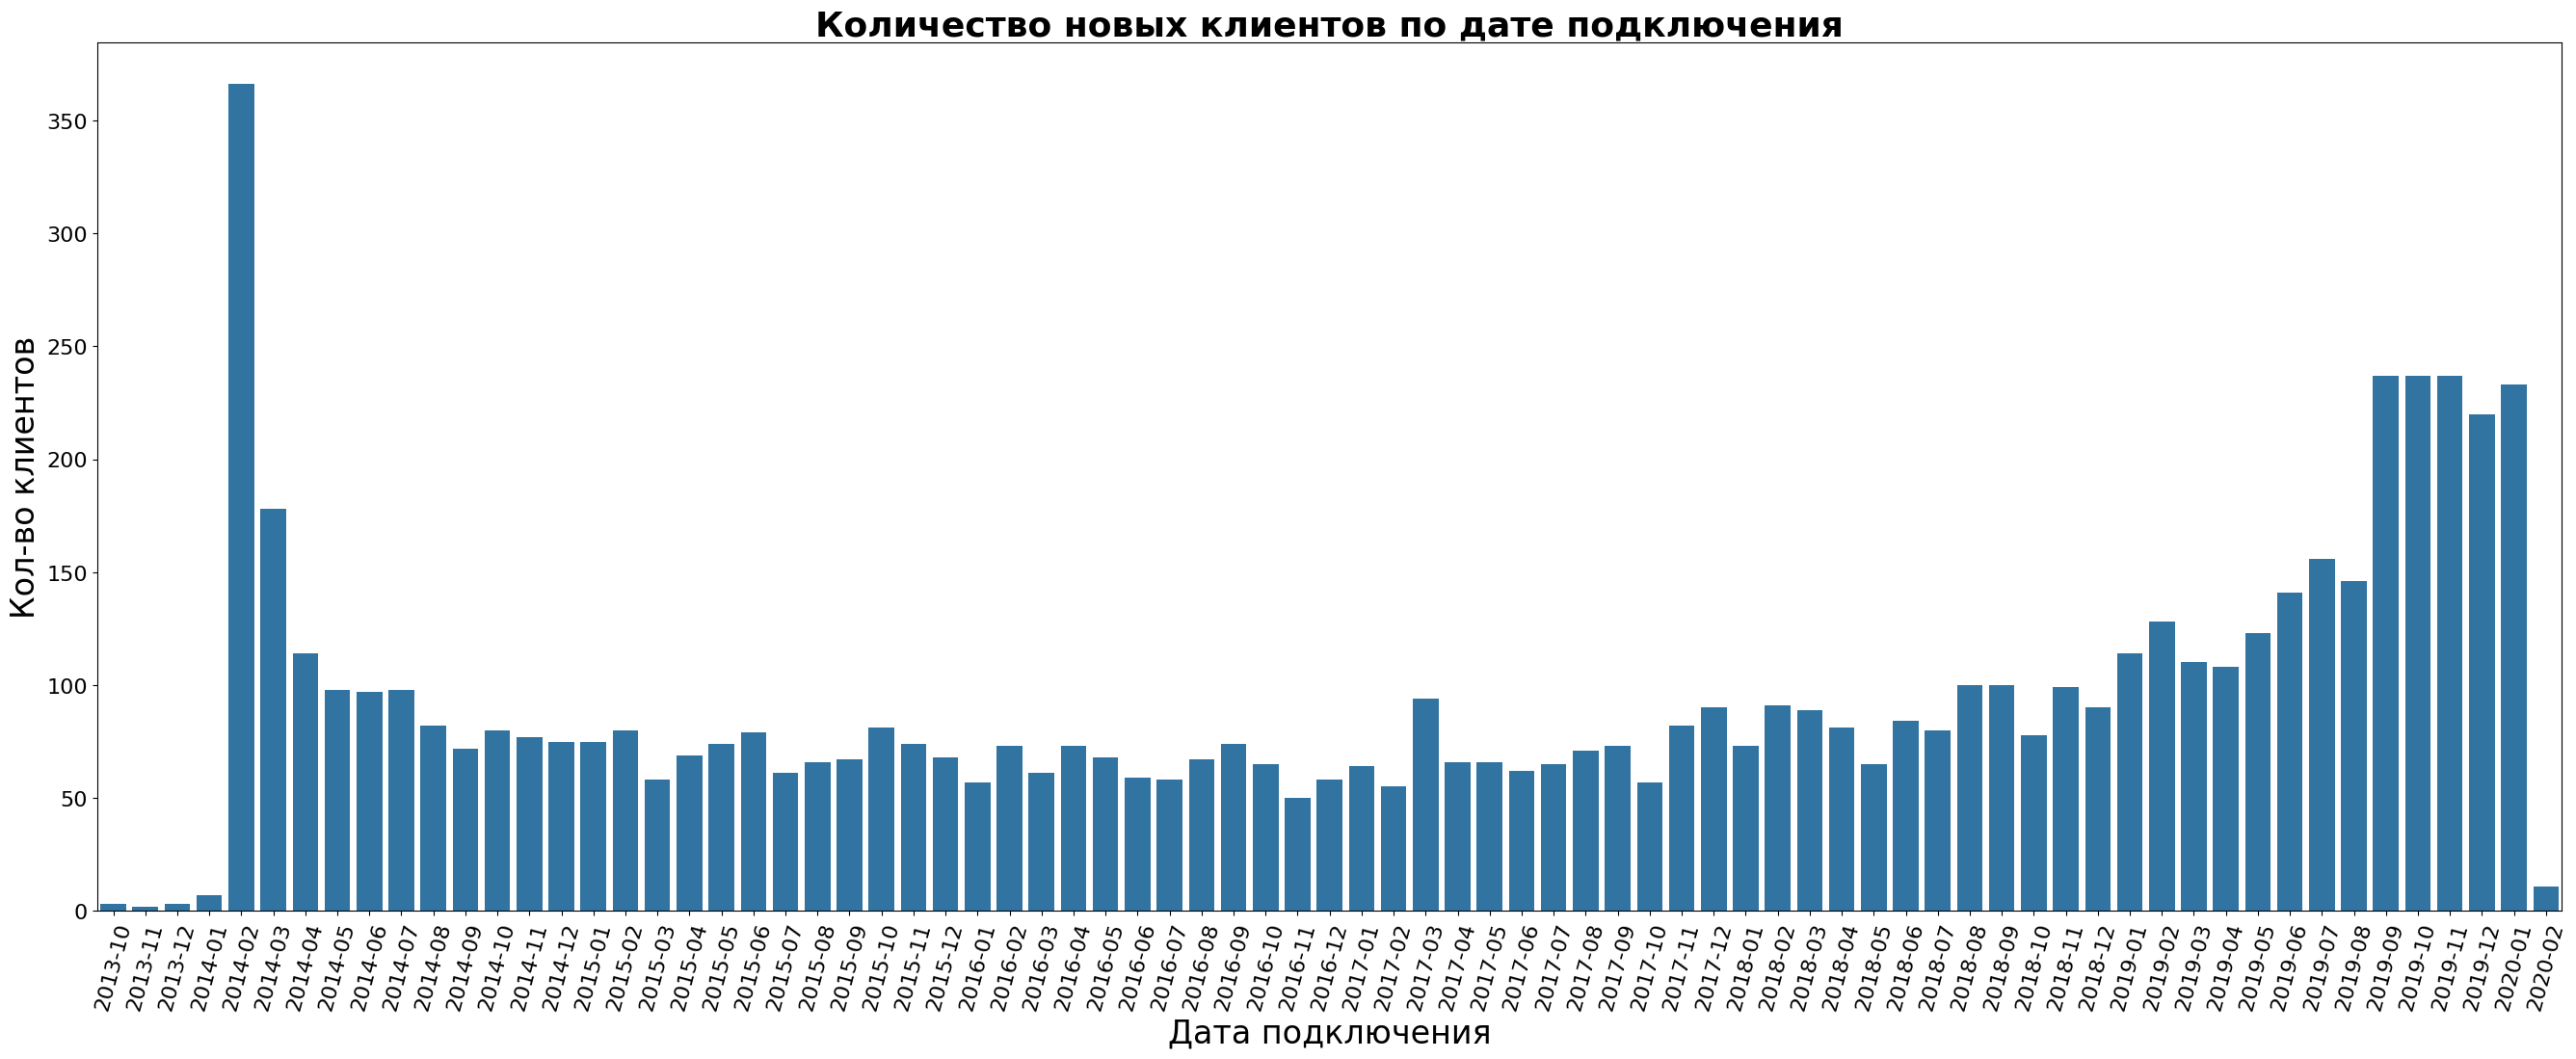

In [75]:
date_barplot(data, 'BeginDate', 'Количество новых клиентов по дате подключения', 33, 11.7)

Вероятнее всего, что этот хвост и есть клиенты с аномальным сроком действия договора. Посмотрим сколько вообще клиентов подключилось с 2013-10 по 2014-01.

In [76]:
# выполним срезом по количеству дней между 2020-02 и 2014-01
data.loc[data['days_count'] > 2191]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,exited,days_count
975,2834-JRTUA,2013-11-01,2020-02-01,Two year,Yes,Electronic check,108.05,8184.79,Male,0,...,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,0,2283
3040,7317-GGVPB,2013-11-01,2020-02-01,Two year,Yes,Credit card (automatic),108.60,8145.00,Male,0,...,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,0,2283
3439,0917-EZOLA,2013-10-01,2020-02-01,Two year,Yes,Bank transfer (automatic),104.15,7915.40,Male,1,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0,2314
4513,8580-QVLOC,2013-10-01,2020-02-01,Two year,No,Credit card (automatic),92.45,7026.20,Female,1,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,0,2314
4610,2889-FPWRM,2013-10-01,2020-02-01,One year,Yes,Bank transfer (automatic),117.80,9221.38,Male,0,...,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,0,2314
6290,2530-ENDWQ,2013-12-01,2020-02-01,Two year,Yes,Bank transfer (automatic),93.70,6933.80,Female,0,...,Yes,Fiber optic,No,No,No,No,Yes,Yes,0,2253


Как видим это те самые 6 клиентов, которые с 2013 года пользуются услугами. Посмотрим сколько в принципе клиентов подключились до 2014-01 включительно.

In [77]:
data.loc[data['BeginDate'] <= '2014-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,exited,days_count
975,2834-JRTUA,2013-11-01,2020-02-01,Two year,Yes,Electronic check,108.05,8184.79,Male,0,...,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,0,2283
1306,0201-OAMXR,2014-01-01,2015-11-01,One year,No,Credit card (automatic),115.55,2592.94,Female,0,...,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,1,669
1967,0565-IYCGT,2014-01-01,2015-05-01,One year,Yes,Credit card (automatic),78.60,1257.60,Male,0,...,Yes,DSL,Yes,Yes,Yes,Yes,No,Yes,1,485
3040,7317-GGVPB,2013-11-01,2020-02-01,Two year,Yes,Credit card (automatic),108.60,8145.00,Male,0,...,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,0,2283
3111,8809-RIHDD,2014-01-01,2016-08-01,Two year,Yes,Electronic check,103.40,3205.40,Male,0,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,1,943
3439,0917-EZOLA,2013-10-01,2020-02-01,Two year,Yes,Bank transfer (automatic),104.15,7915.40,Male,1,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0,2314
3890,3886-CERTZ,2014-01-01,2018-06-01,One year,Yes,Electronic check,109.25,5906.06,Female,0,...,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,1,1612
4513,8580-QVLOC,2013-10-01,2020-02-01,Two year,No,Credit card (automatic),92.45,7026.20,Female,1,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,0,2314
4610,2889-FPWRM,2013-10-01,2020-02-01,One year,Yes,Bank transfer (automatic),117.80,9221.38,Male,0,...,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,0,2314
4684,6305-YLBMM,2014-01-01,2017-09-01,One year,Yes,Bank transfer (automatic),104.05,5036.02,Male,0,...,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,1,1339


Всего таких клиентов 15. И шестеро из них до сих пор пользуются услугами.

Возможно что их влияние на исследование незначительное, все равно удалим их из данных как "устаревшие". Учитывая, что сразу после 2014-01 следует скачок, что свидетельствует об изменении условий предоставления услуг.

Посмотрим на внесенные изменения.

In [78]:
data = data.loc[data['BeginDate'] > '2014-01']

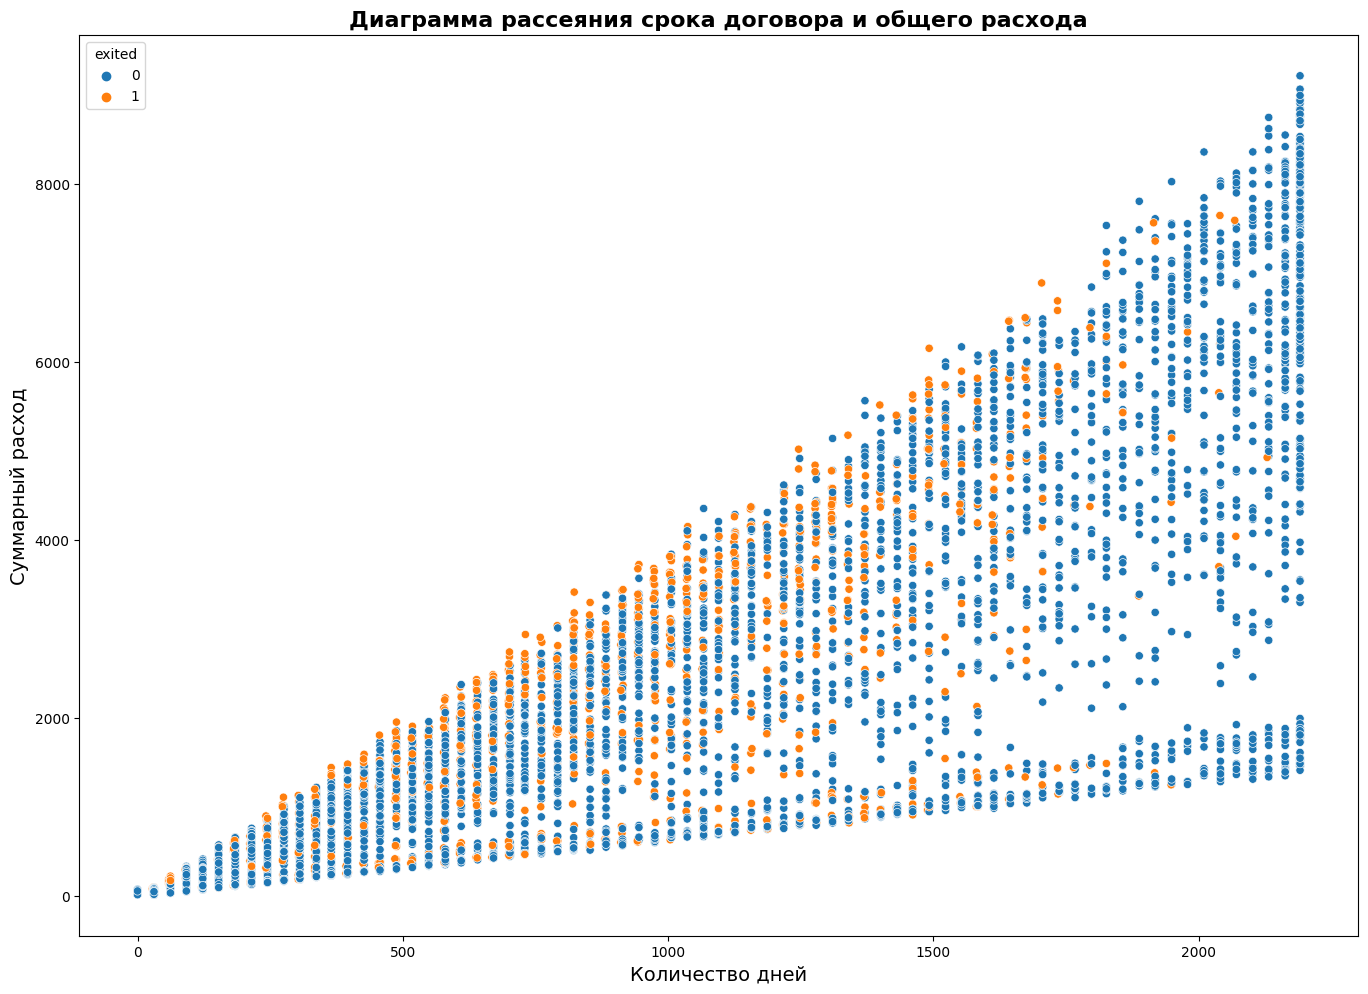

In [79]:
fig, ax = plt.subplots()
ax = sns.scatterplot(y=data['TotalCharges'], x=data["days_count"], hue=data['exited'])
plt.title('Диаграмма рассеяния срока договора и общего расхода', fontsize=16, fontweight='bold')
plt.xlabel('Количество дней', fontsize=14)
plt.ylabel('Суммарный расход', fontsize=14)
plt.show()

In [80]:
# измененные данные
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7028 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7028 non-null   object        
 1   BeginDate         7028 non-null   datetime64[ns]
 2   EndDate           7028 non-null   datetime64[ns]
 3   Type              7028 non-null   object        
 4   PaperlessBilling  7028 non-null   object        
 5   PaymentMethod     7028 non-null   object        
 6   MonthlyCharges    7028 non-null   float64       
 7   TotalCharges      7028 non-null   float64       
 8   gender            7028 non-null   object        
 9   SeniorCitizen     7028 non-null   object        
 10  Partner           7028 non-null   object        
 11  Dependents        7028 non-null   object        
 12  MultipleLines     7028 non-null   object        
 13  InternetService   7028 non-null   object        
 14  OnlineSecurity    7028 n

In [81]:
# неизмененные данные
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


Потеря в 26 строк незначительна.

### Распределение категориальных признаков

Построим гистограммы распределения категориальных признаков и проведем их анализ.

Отберем требующиеся признаки, исключая целевой признак и `CustomerID`

In [82]:
feature_list = data.columns[(data.dtypes == 'object') & (~data.columns.isin (['customerID', 'exited']))].tolist()
feature_list

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

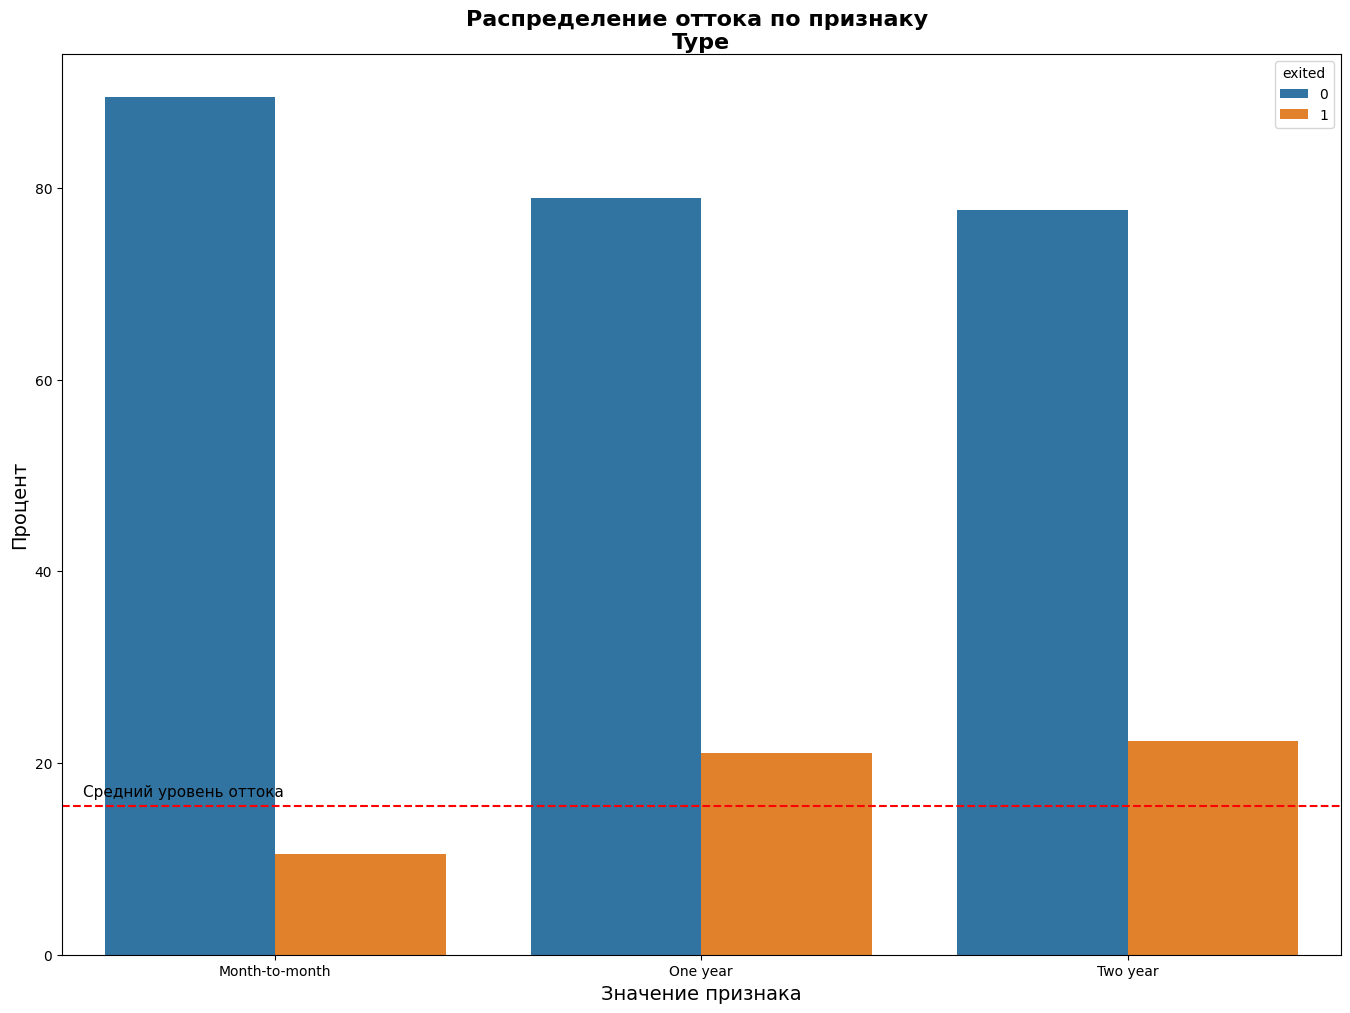

                exited
Type                  
Month-to-month    3875
One year          1468
Two year          1685
All               7028



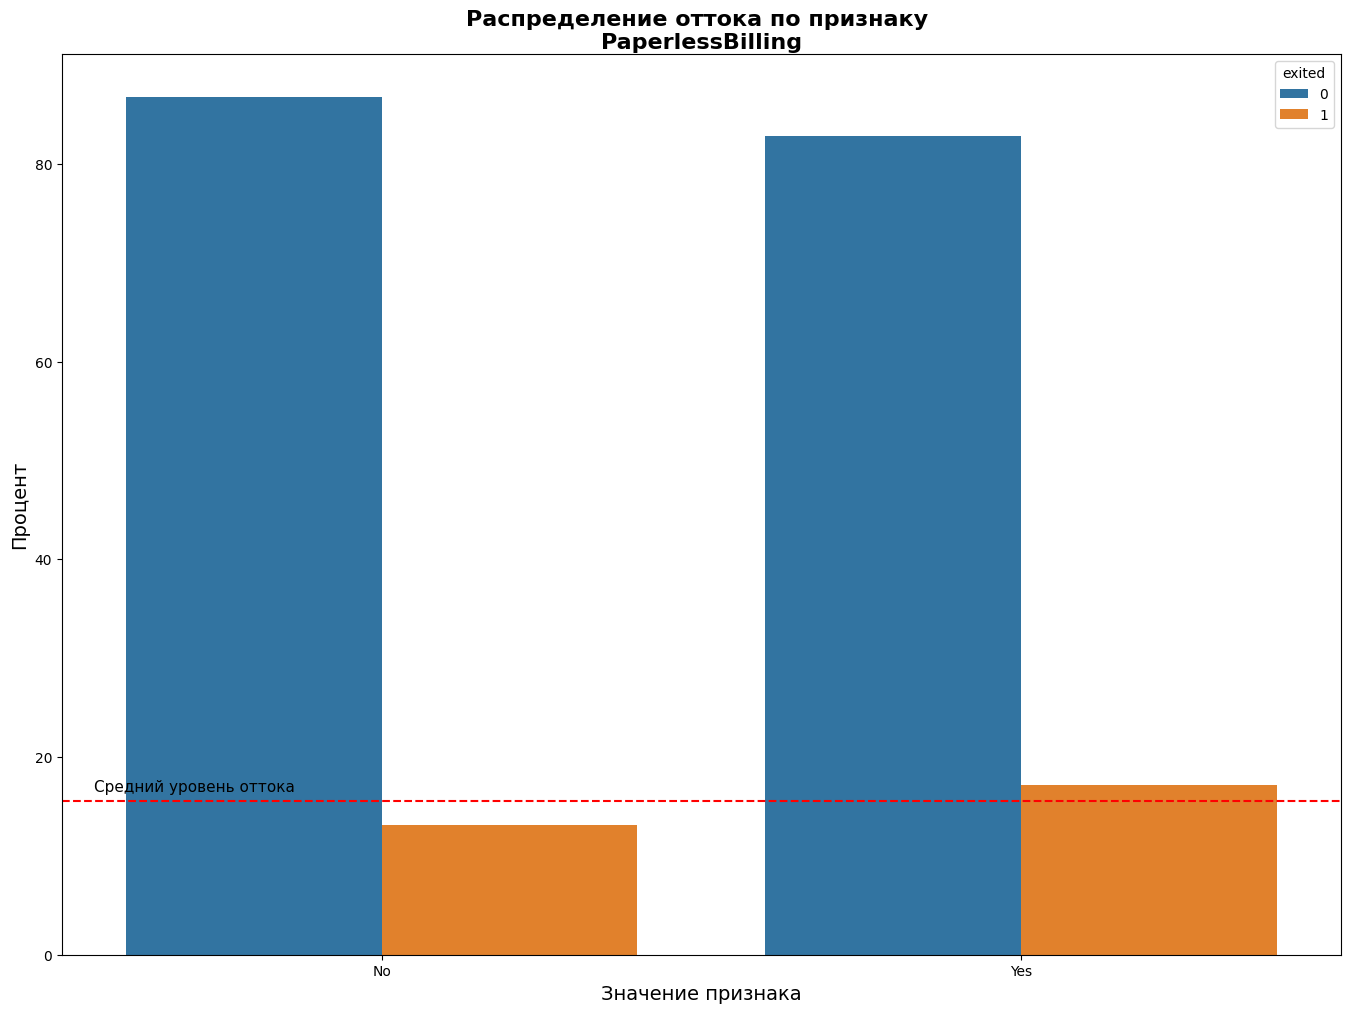

                  exited
PaperlessBilling        
No                  2869
Yes                 4159
All                 7028



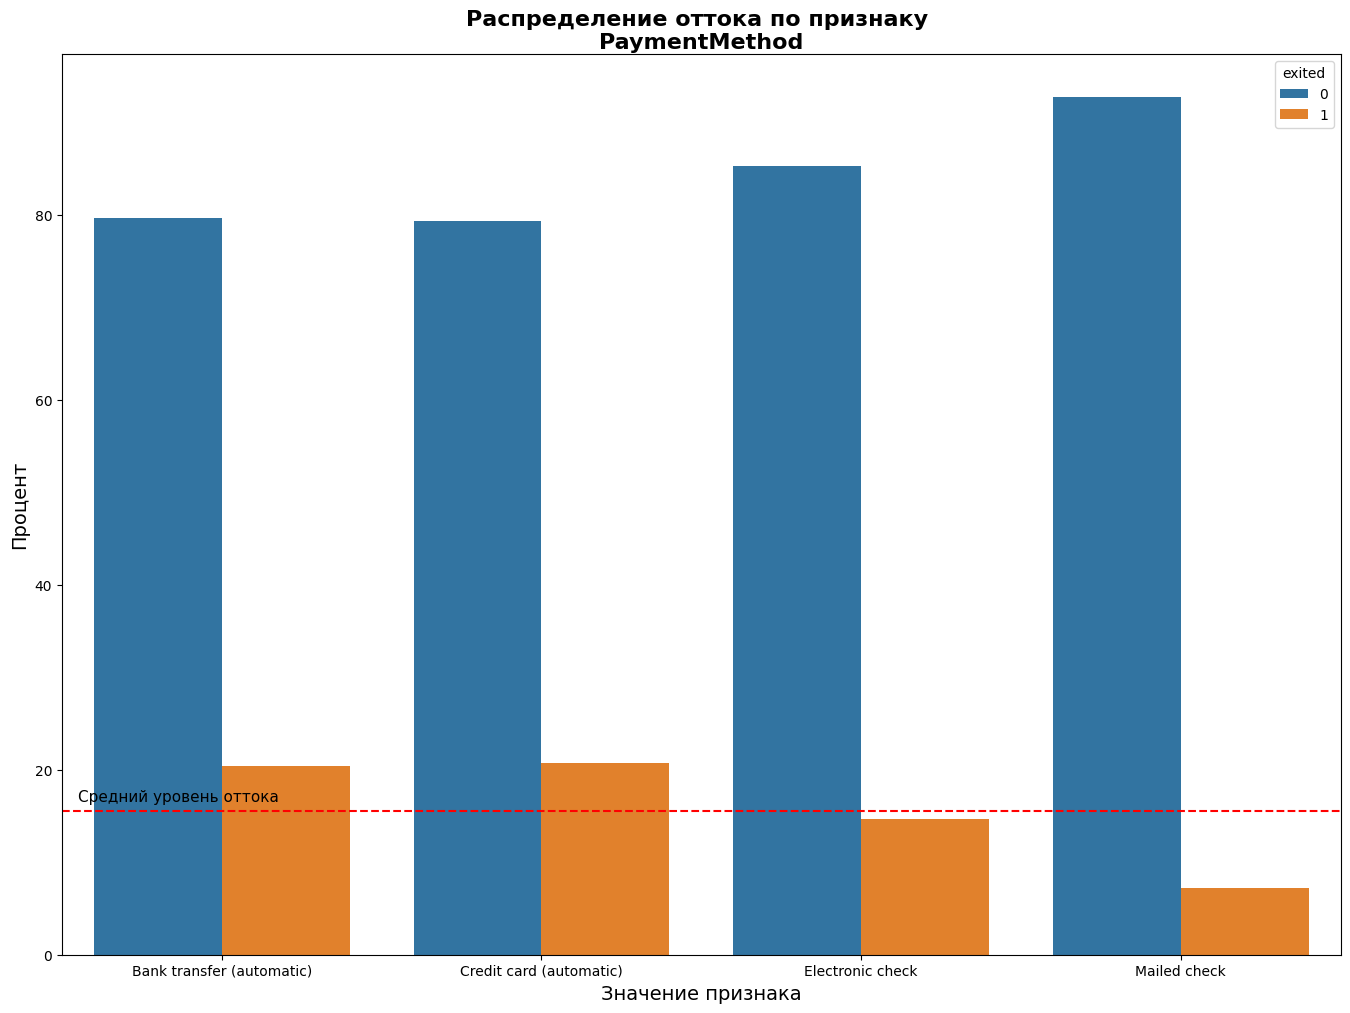

                           exited
PaymentMethod                    
Bank transfer (automatic)    1538
Credit card (automatic)      1517
Electronic check             2361
Mailed check                 1612
All                          7028



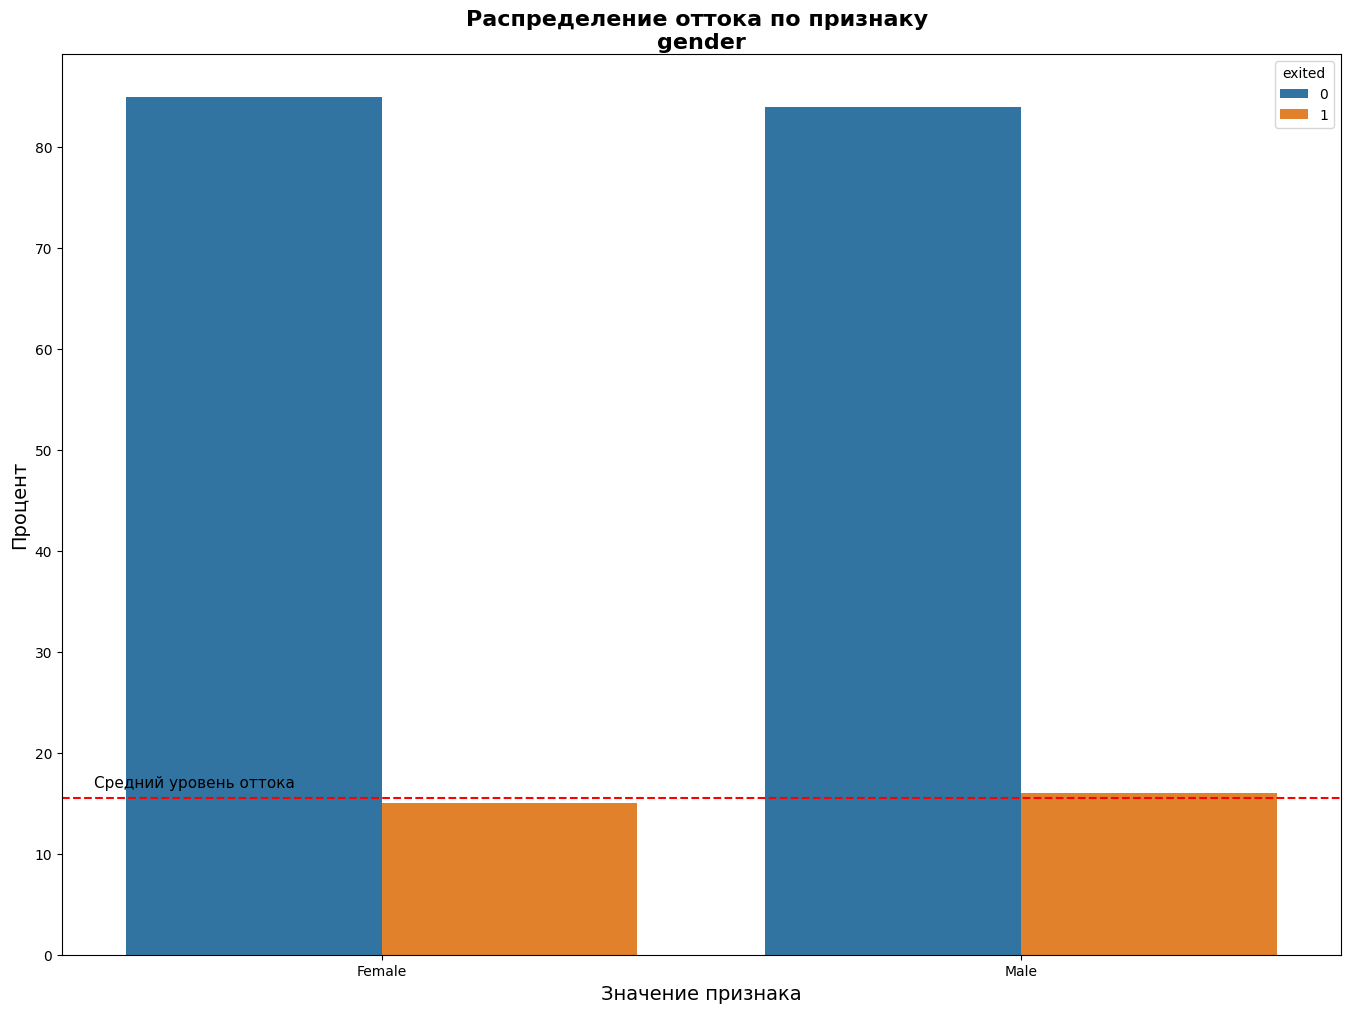

        exited
gender        
Female    3481
Male      3547
All       7028



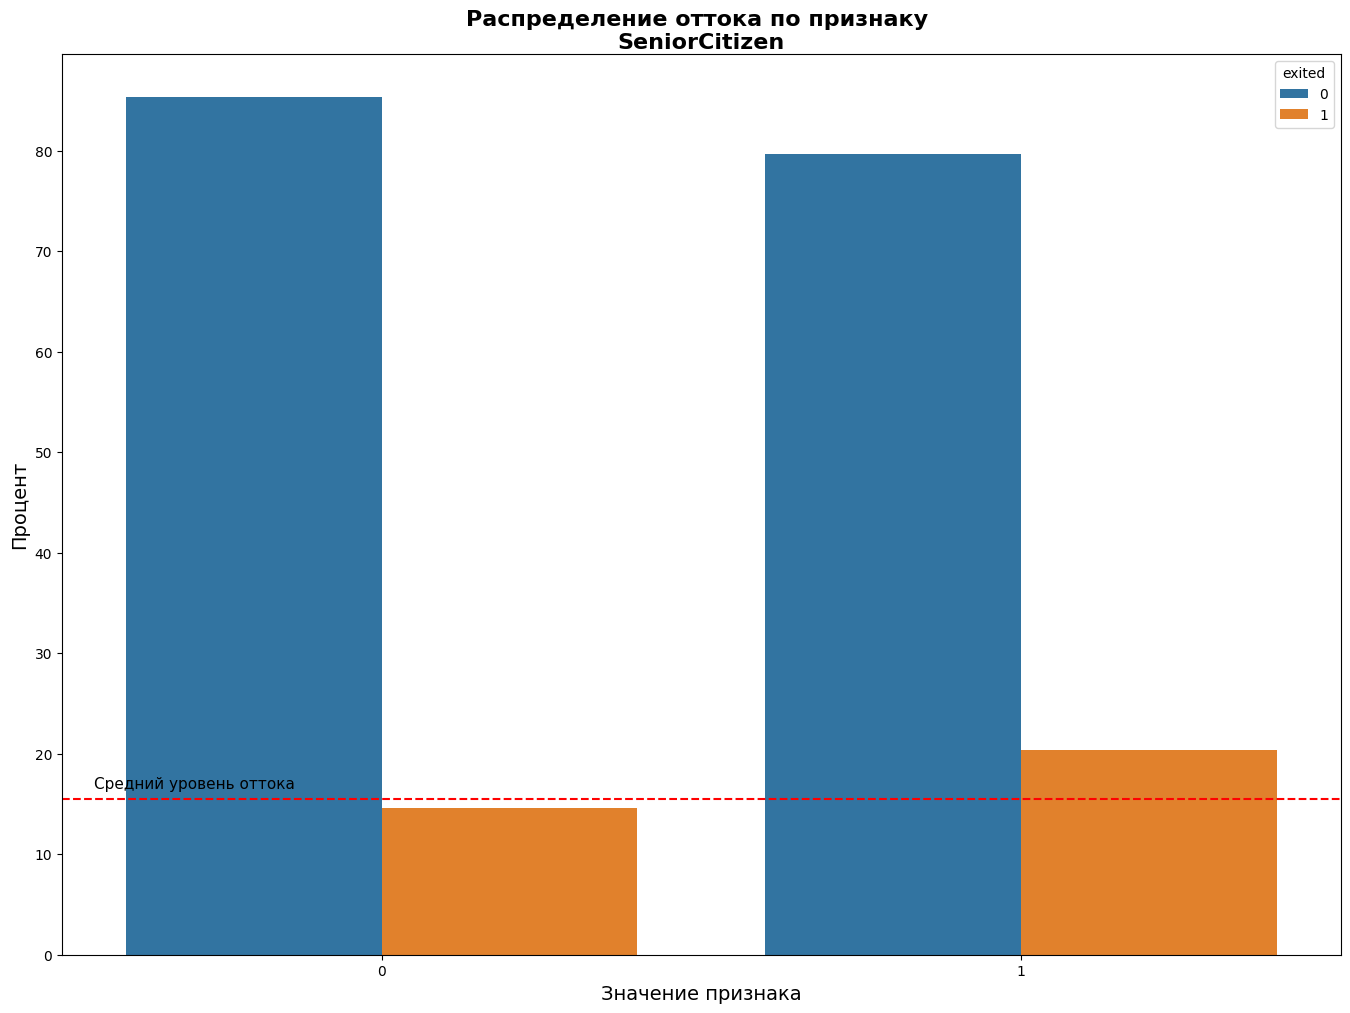

               exited
SeniorCitizen        
0                5888
1                1140
All              7028



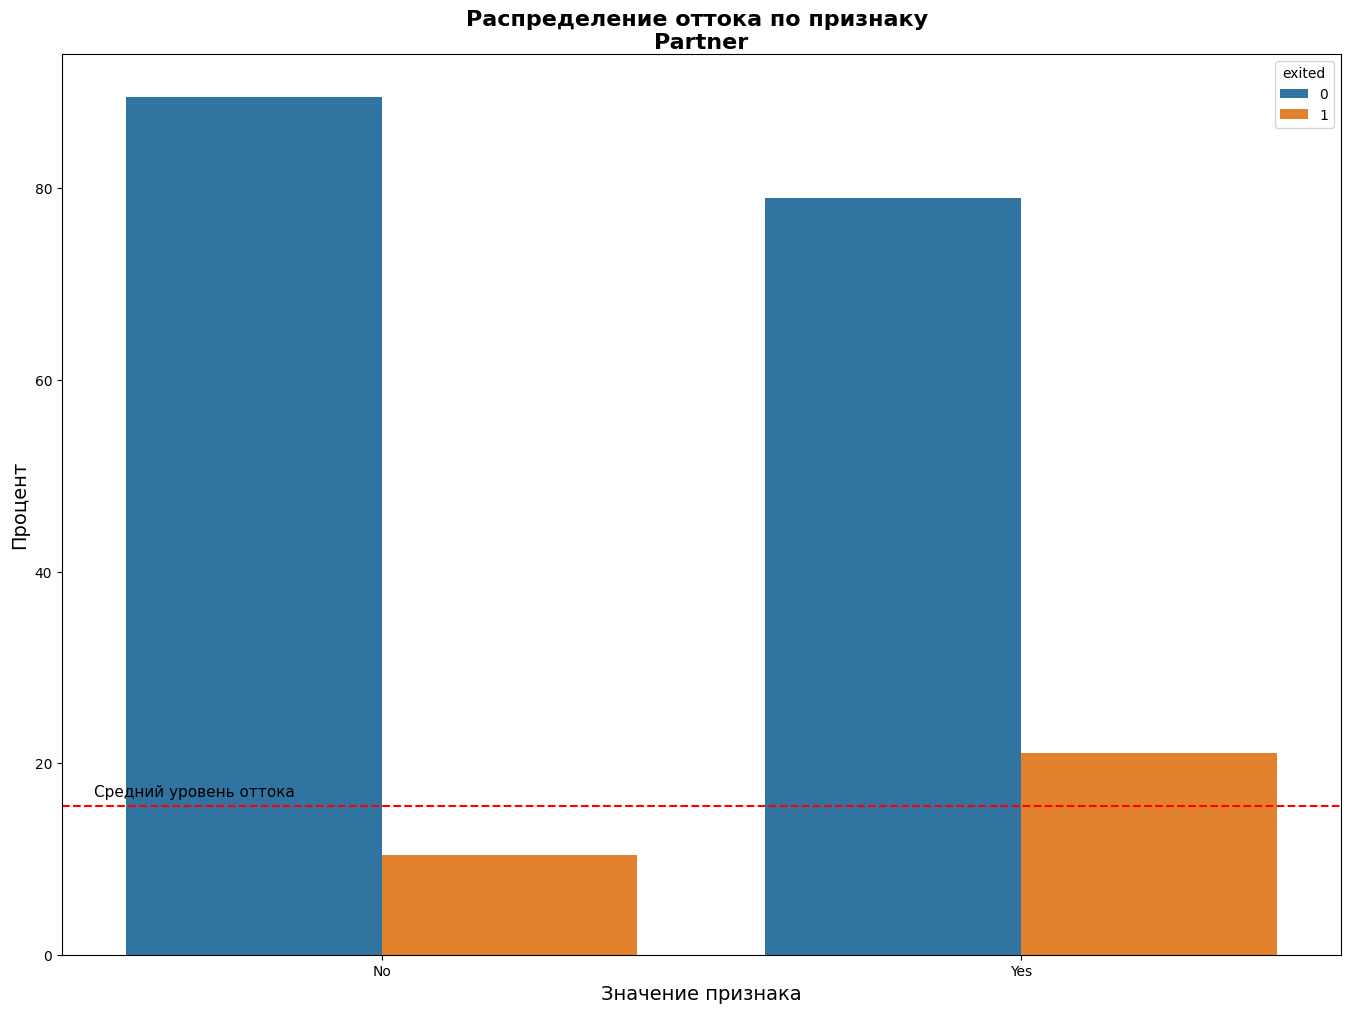

         exited
Partner        
No         3637
Yes        3391
All        7028



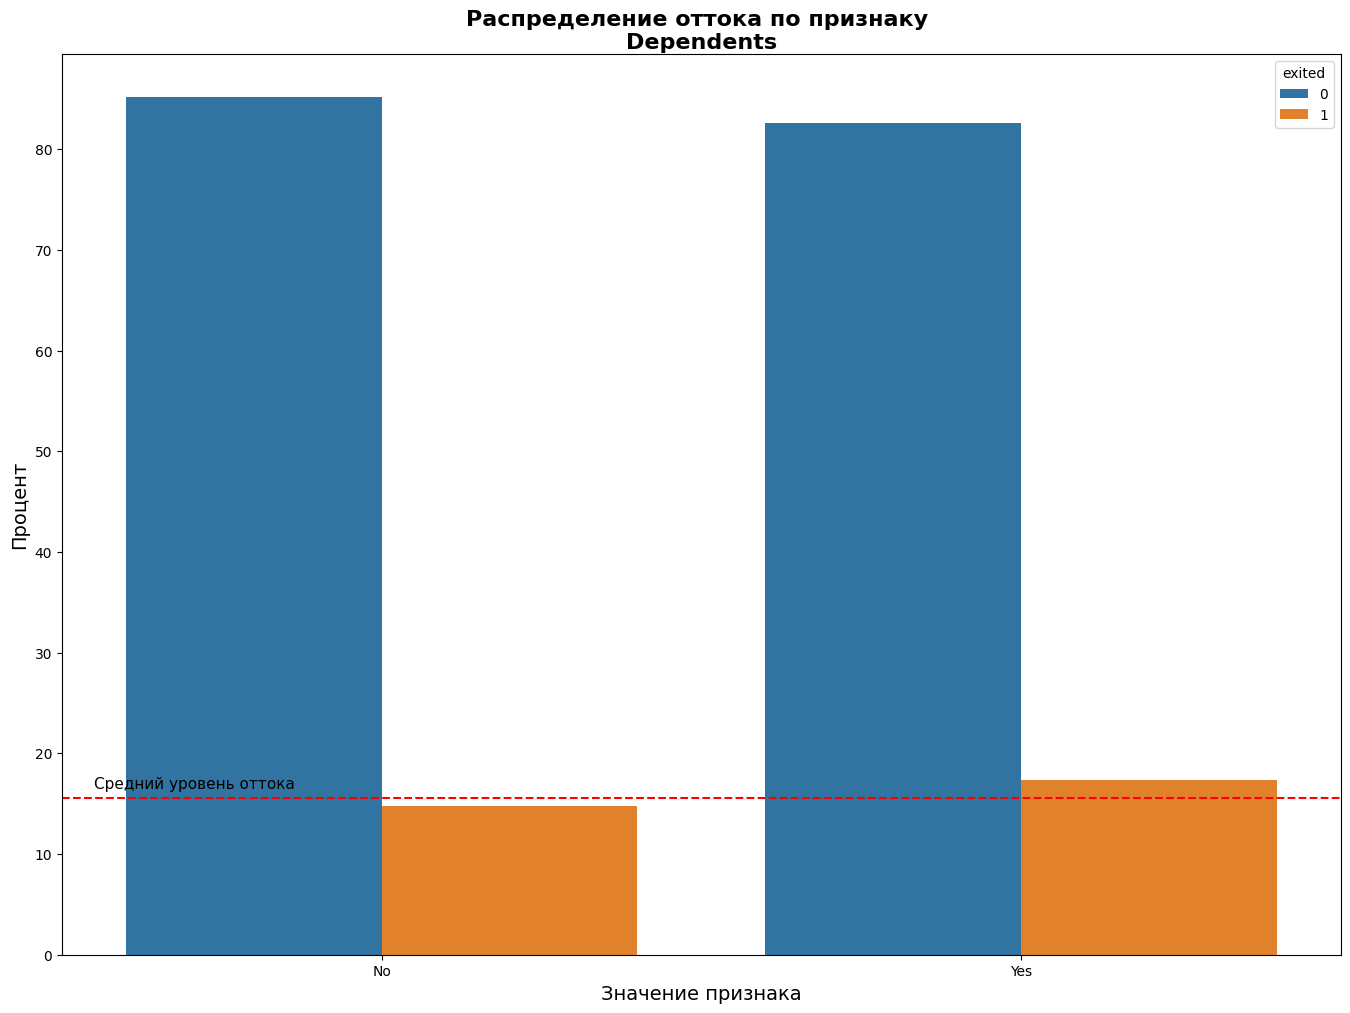

            exited
Dependents        
No            4922
Yes           2106
All           7028



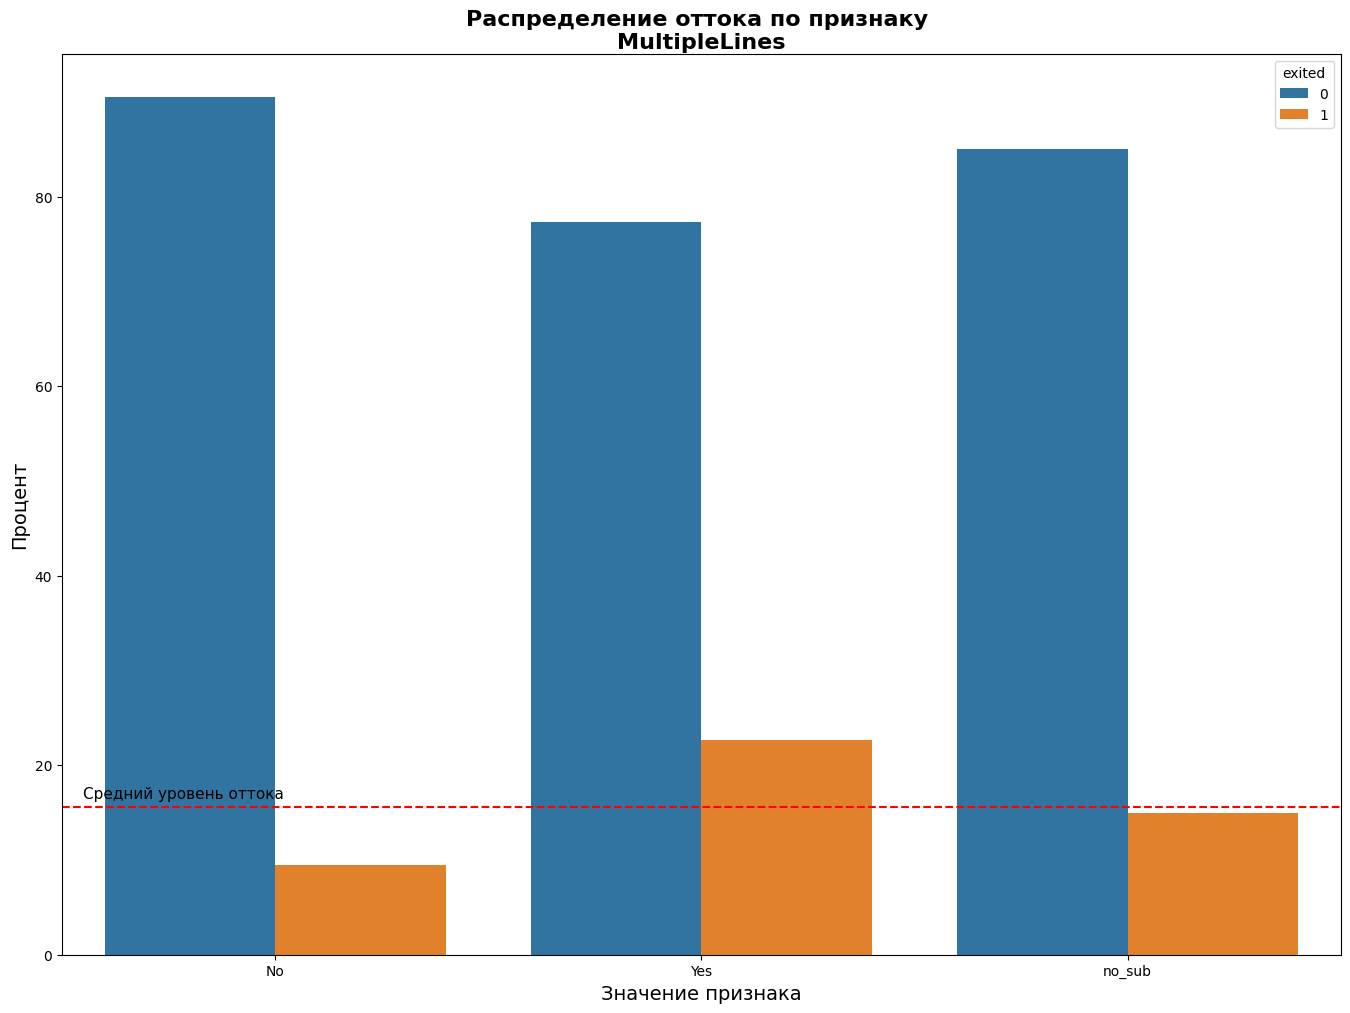

               exited
MultipleLines        
No               3389
Yes              2958
no_sub            681
All              7028



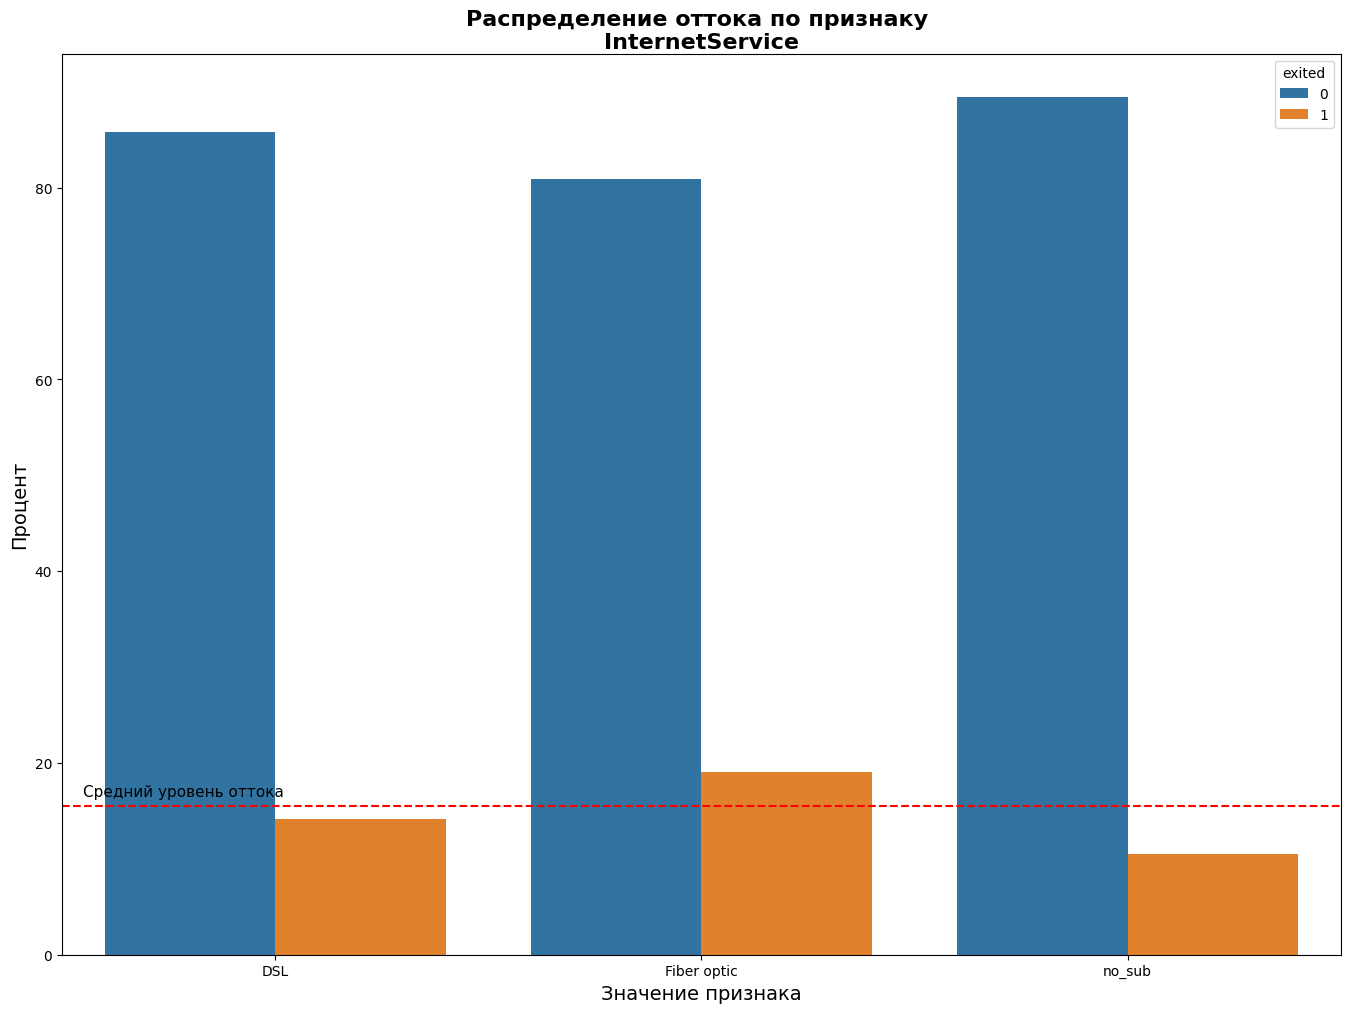

                 exited
InternetService        
DSL                2417
Fiber optic        3085
no_sub             1526
All                7028



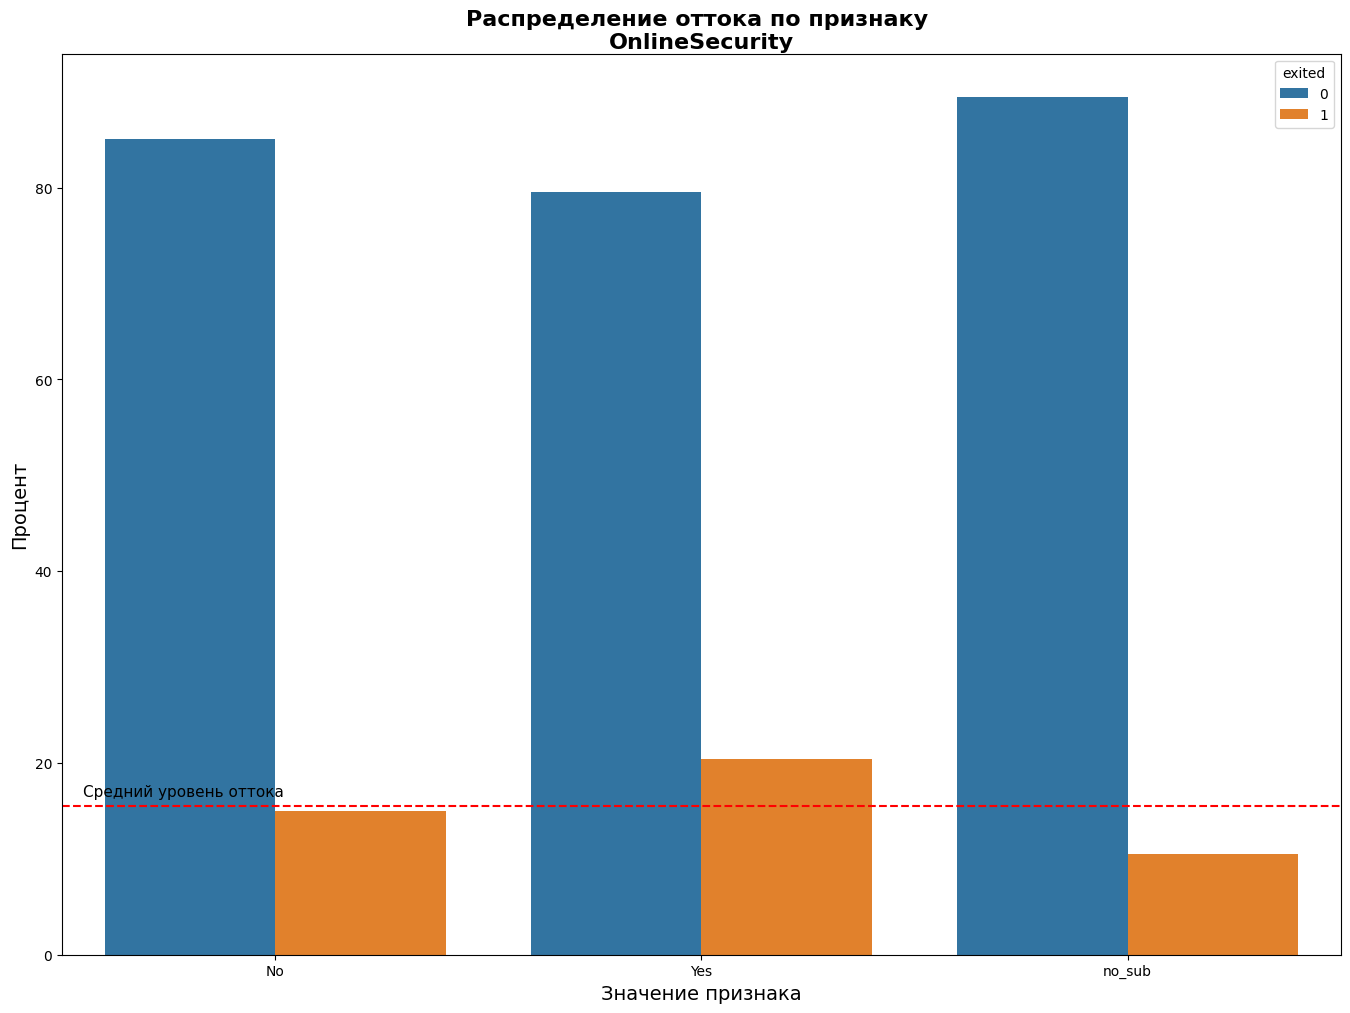

                exited
OnlineSecurity        
No                3490
Yes               2012
no_sub            1526
All               7028



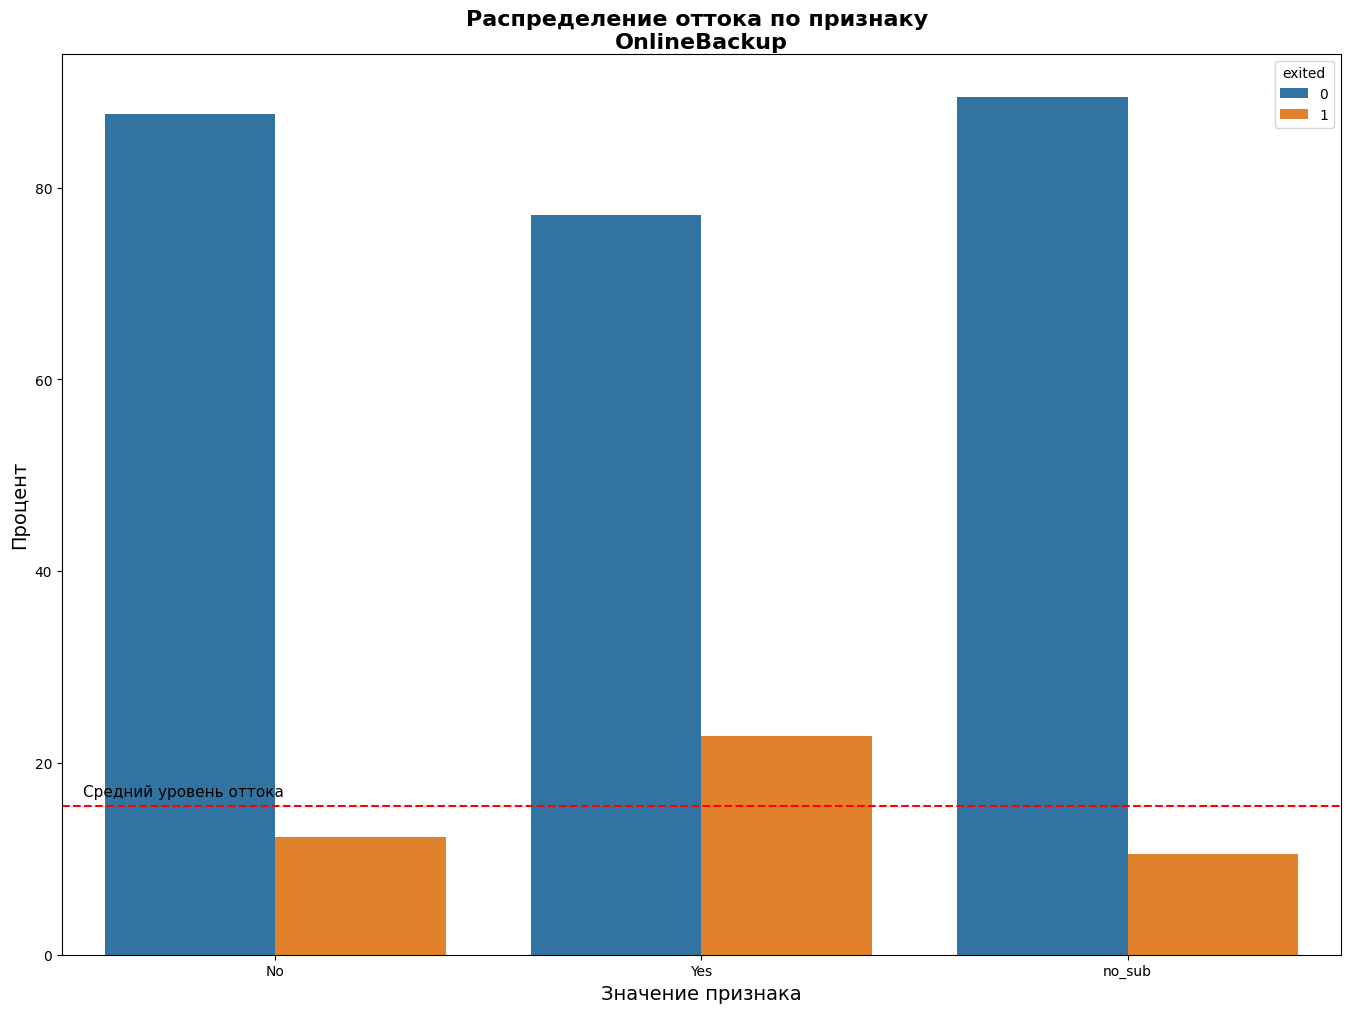

              exited
OnlineBackup        
No              3085
Yes             2417
no_sub          1526
All             7028



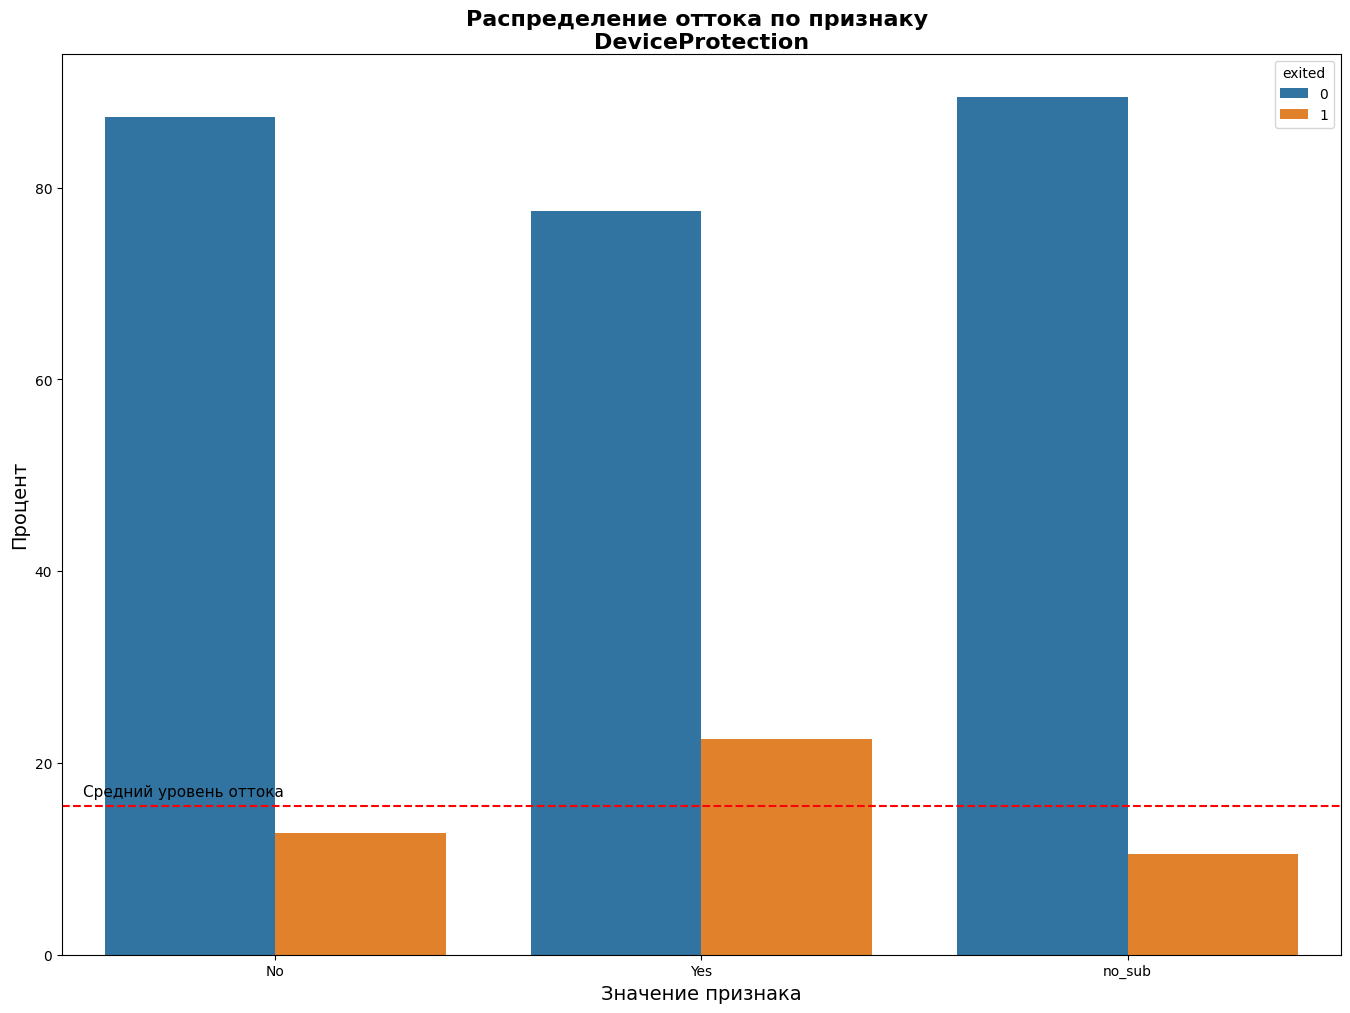

                  exited
DeviceProtection        
No                  3094
Yes                 2408
no_sub              1526
All                 7028



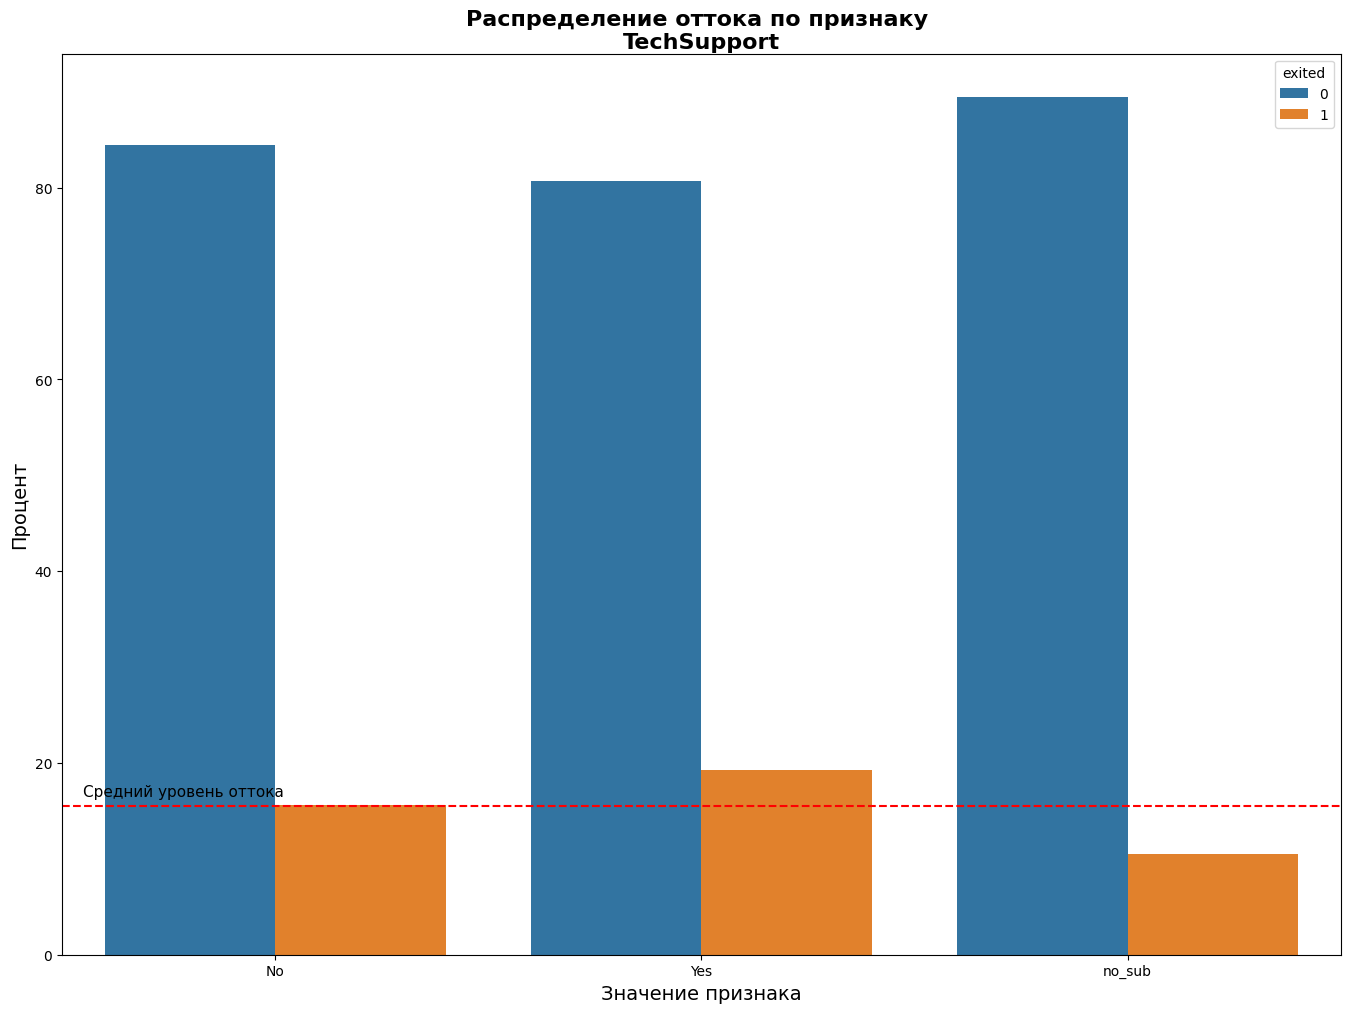

             exited
TechSupport        
No             3468
Yes            2034
no_sub         1526
All            7028



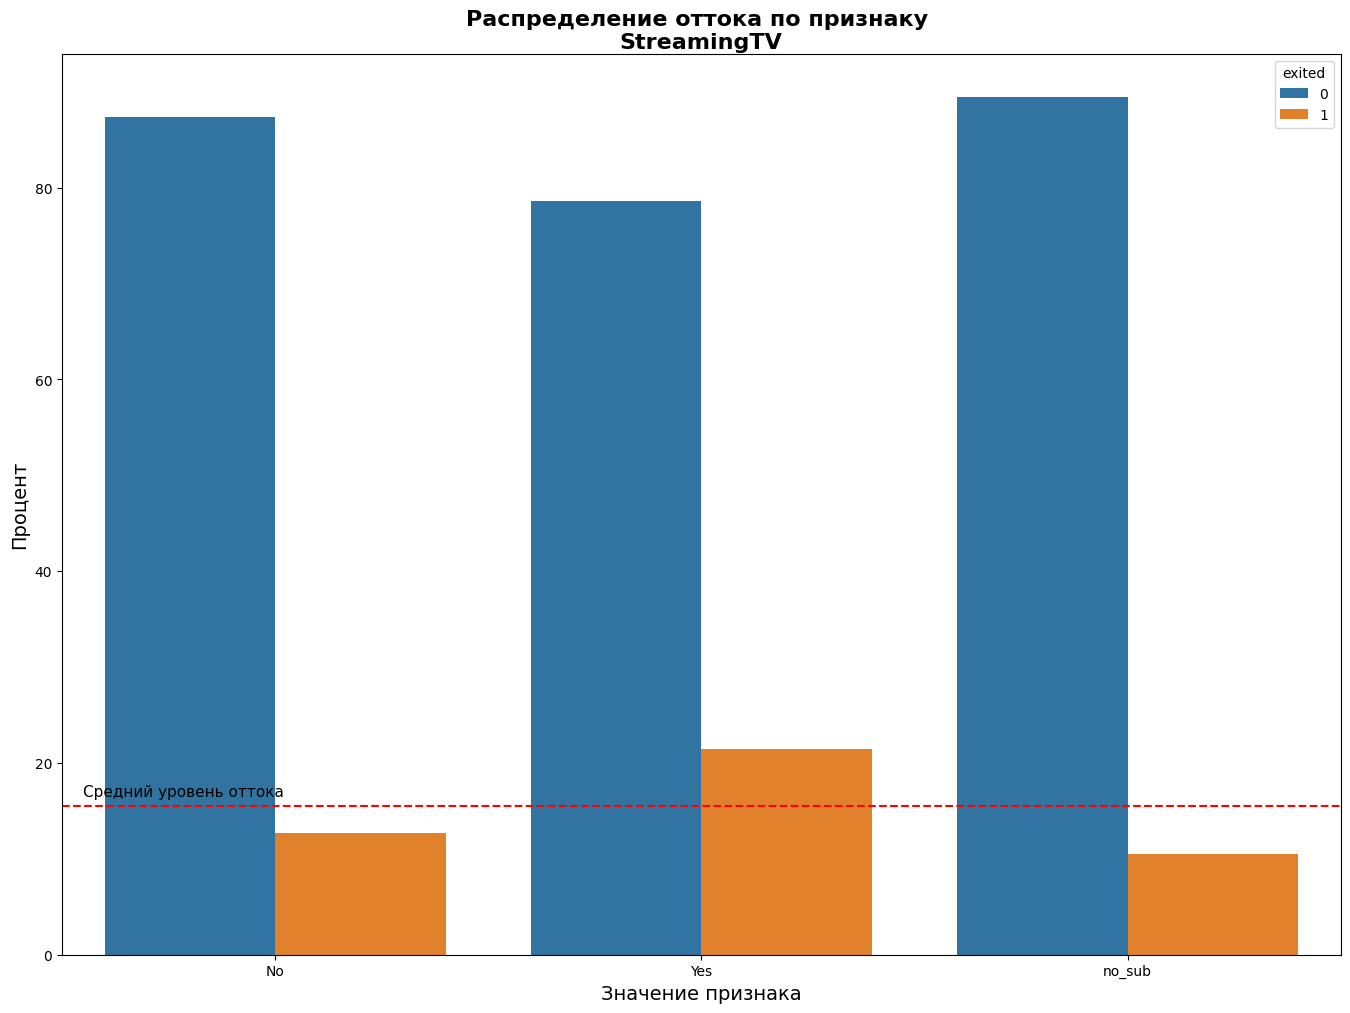

             exited
StreamingTV        
No             2808
Yes            2694
no_sub         1526
All            7028



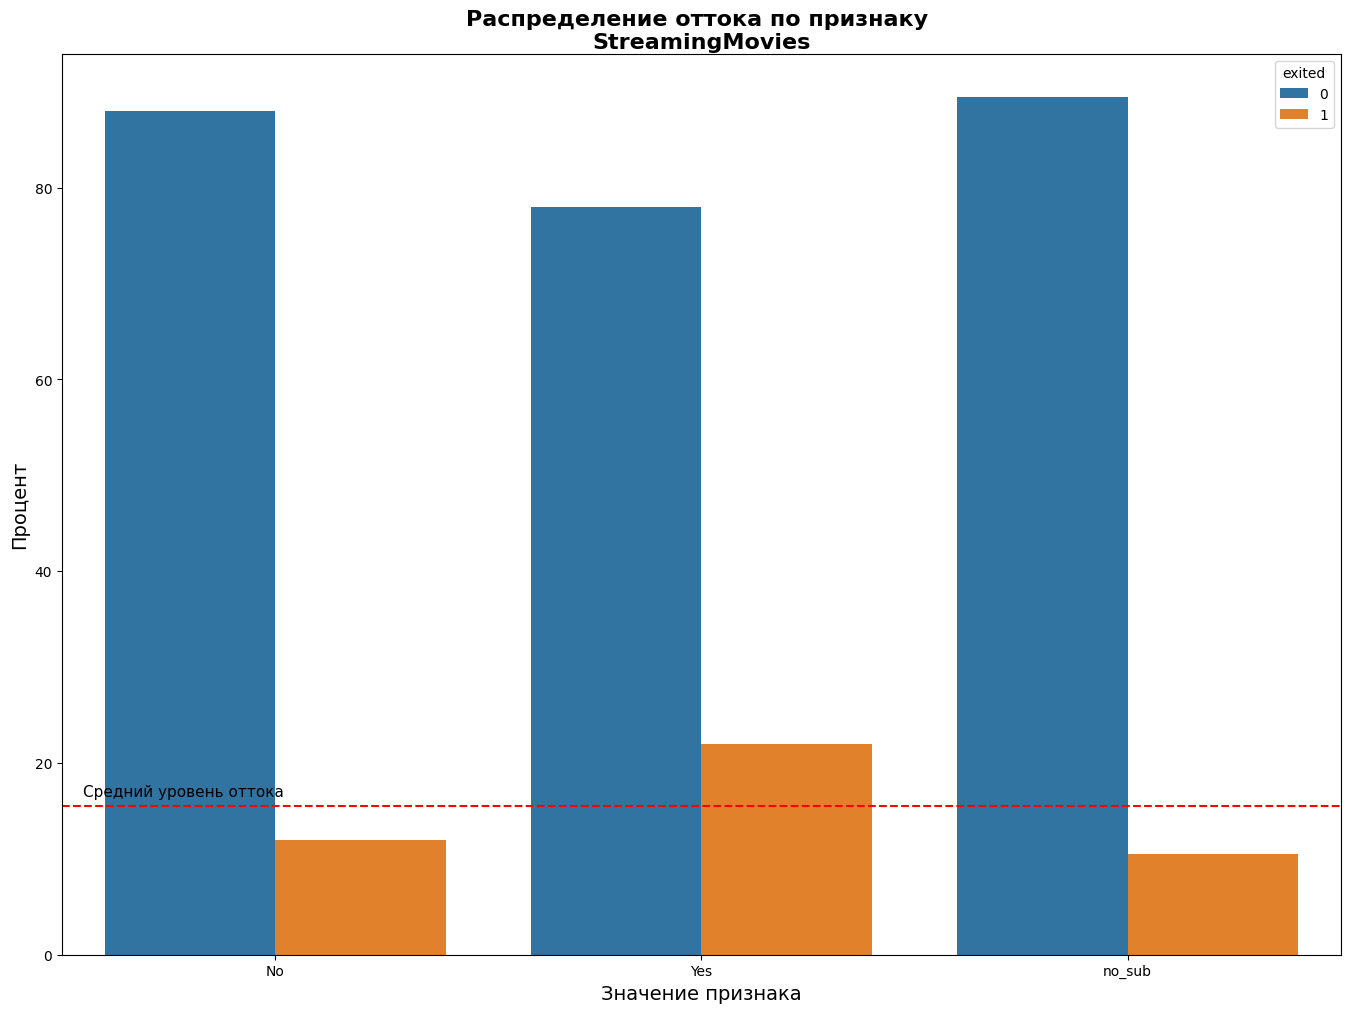

                 exited
StreamingMovies        
No                 2784
Yes                2718
no_sub             1526
All                7028



In [83]:
for i in feature_list:
    feature = i
    barplot_percent(data, feature, 'exited')
    print(pd.pivot_table(data, values='exited', index=i, aggfunc='count', margins=True))
    print('')

По гистограммам заметно, что:

* `Type` (тип оплаты услуг):
    * Выделяется помесячная оплата, больше половины клиентов предпочитают именно этот тип оплаты, при этом доля оттока наименьшая. В остальных примерно одинаковое количество и доля оттока клиентов заметно превышает общий средний уровень.
* `PaperlessBilling` (электронный расчетный лист):
    * Большинство выбирает электронный тип оплаты, возможно есть корреляция с возрастом клиентов. Доля оттока клиентов с электронными типом оплаты немного выше среднего уровня.
* `PaymentMethod` (тип платежа):
    * Больше всего клиентов с электронным типом платежа. Банковские переводы и автоплатежи имеют отток выше среднего. Для почтовой оплаты уровень оттока заметно ниже.
*  `gender` (пол):
    * Распределение по половому признаку идентичное. Чуть больше процент оттока мужчин.
* `SeniorCitizen` (пенсионер):
    * Среди клиентов намного меньше пенсионеров, но доля оттока больше среднего уровня.
* `Partner` (есть ли супруга\супруг):
    * Клиенты, состоящие в законных отношениях чаще склонны к разрыву договора. Чуть больше клиентов без законных отношений.
* `Dependents` (наличие детей):
    * Клиентов с детьми более чем в два раза меньше. Процент оттока у этой группы чуть больше среднего уровня. У клиентов без дете он ниже.
* `MultipleLines` (подключение к нескольким линиям):
    * Большинство клиентов предпочитают пользоваться одной линией телефонной передачи, при этом оттока заметно меньше чем в категории клиентов с несколькими линиями. Возможно есть какие-то технические неполадки в этой услуге или более привлекательные условия у конкурентов. Достаточно мало клиентов не пользуются телефонными услугами. Отток клиентов с подключенной услугой заметно превышает средний уровень.
* `InterneService` (тип подключения интернета):
    * Большинство использует оптоволоконную связь, при этом и оттока больше (превышает средний уровень). Цифровой абонентской линией пользуются меньше. Заметное количество клиентов не пользуются интернет связью в целом.
* `OnlineSecurity` (блокировка опасных сайтов):
    * Многие не пользуются этой услугой. Доля ушедших клиентов среди тех, кто пользуется услугой превалирует в сравнение с теми, кто не пользуется. Клиенты, которым необходимо только интернет соединение, предпочитают разрывать договор. Возможно, что условия интернет услуг у конкурентов лучше.
* `OnlineBackup` (облачное хранилище файлов для резервного копирования данных), `DeviceProtection` (антивирус), `TechSupport` (выделенная линия технической поддержки), `StreamingMovies` (каталог фильмов) имеют похожее распределение, что и у `OnlineSecurity` и относятся к интернет услугам. Вполне вероятно, что все эти услуги входят в один пакет.
* `StreamingTV` (стриминговое телевидение):
    * По сравнению с другими интернет услугами, имеет заметно больше клиентов с подключением этой услуги. При этом и оттока больше.



Суммируя исследование, составим портрет типичного клиента.

In [84]:
# создадим таблицу с индексами = признаками и столбцами = решению клиента
avg_customer = pd.DataFrame(index=feature_list, columns=['Отток', 'Не отток'])

# заполним данные в зависимости от процента оттока соответствующей категории
for i in range(len(avg_customer.index)):
    avg_customer.iloc[i]['Отток'] = data.groupby(avg_customer.index[i])['exited'].mean().idxmax()
    avg_customer.iloc[i]['Не отток'] = (1 - data.groupby(avg_customer.index[i])['exited'].mean()).idxmax()

In [85]:
# отдельно выделим датасет с оттоком, что посчитать медианные значения количественных данных
# медианные данные, так как распределения скошенные
churn = data.loc[data['exited']==1]

# присоединим таблицу к созданной ранее
avg_customer = avg_customer.append(churn[['MonthlyCharges', 'TotalCharges', 'days_count']] \
            .median() \
            .to_frame() \
            .rename(columns={0:'Отток'}))


In [86]:
# выполним те же действия для клиентов с меткой 0 (не отток)
# "обновим" основную таблицу
no_churn = data.loc[data['exited']==0]

(
avg_customer
    .update(no_churn[['MonthlyCharges', 'TotalCharges', 'days_count']]
            .median()
            .to_frame()
            .rename(columns={0:'Не отток'}))
)

In [87]:
avg_customer

,Отток,Не отток
Type,Two year,Month-to-month
PaperlessBilling,Yes,No
PaymentMethod,Credit card (automatic),Mailed check
gender,Male,Female
SeniorCitizen,1,0
Partner,Yes,No
Dependents,Yes,No
MultipleLines,Yes,No
InternetService,Fiber optic,no_sub
OnlineSecurity,Yes,no_sub


Портрет типичного клиента с решением разорвать договор:

   * женатый мужчина пенсионер с детьми;
   * с общей суммой расходов 2136.2 единиц;
   * с месячной суммой расходов 84.2 единицы;
   * пользующийся услугами на протяжении 914 дней;
   * подключены абсолютно все услуги;
   * оплата электронным расчетным листом;
   * оптоволоконное соединение интернета;
   * с автоплатежом;
   * и двухлетним договором.

### Мультиколлинеарность

Мультиколлинеарность признаков негативно влияет на линейные модели машинного обучения. Чтобы определить степень зависимости категориальных признаков воспользуемся библиотекой `phik`. Зададимся порогом коллинеарности и уберем те признаки, которые превышают этот порог.

Нам уже не потребуются признаки `customerID`, `BeginDate` и `EndDate`, поэтому удалим их в датафрейма.

In [88]:
data = data.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7028 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7028 non-null   object 
 1   PaperlessBilling  7028 non-null   object 
 2   PaymentMethod     7028 non-null   object 
 3   MonthlyCharges    7028 non-null   float64
 4   TotalCharges      7028 non-null   float64
 5   gender            7028 non-null   object 
 6   SeniorCitizen     7028 non-null   object 
 7   Partner           7028 non-null   object 
 8   Dependents        7028 non-null   object 
 9   MultipleLines     7028 non-null   object 
 10  InternetService   7028 non-null   object 
 11  OnlineSecurity    7028 non-null   object 
 12  OnlineBackup      7028 non-null   object 
 13  DeviceProtection  7028 non-null   object 
 14  TechSupport       7028 non-null   object 
 15  StreamingTV       7028 non-null   object 
 16  StreamingMovies   7028 non-null   object 


Теперь построим корреляционную матрицу между всеми признаками.

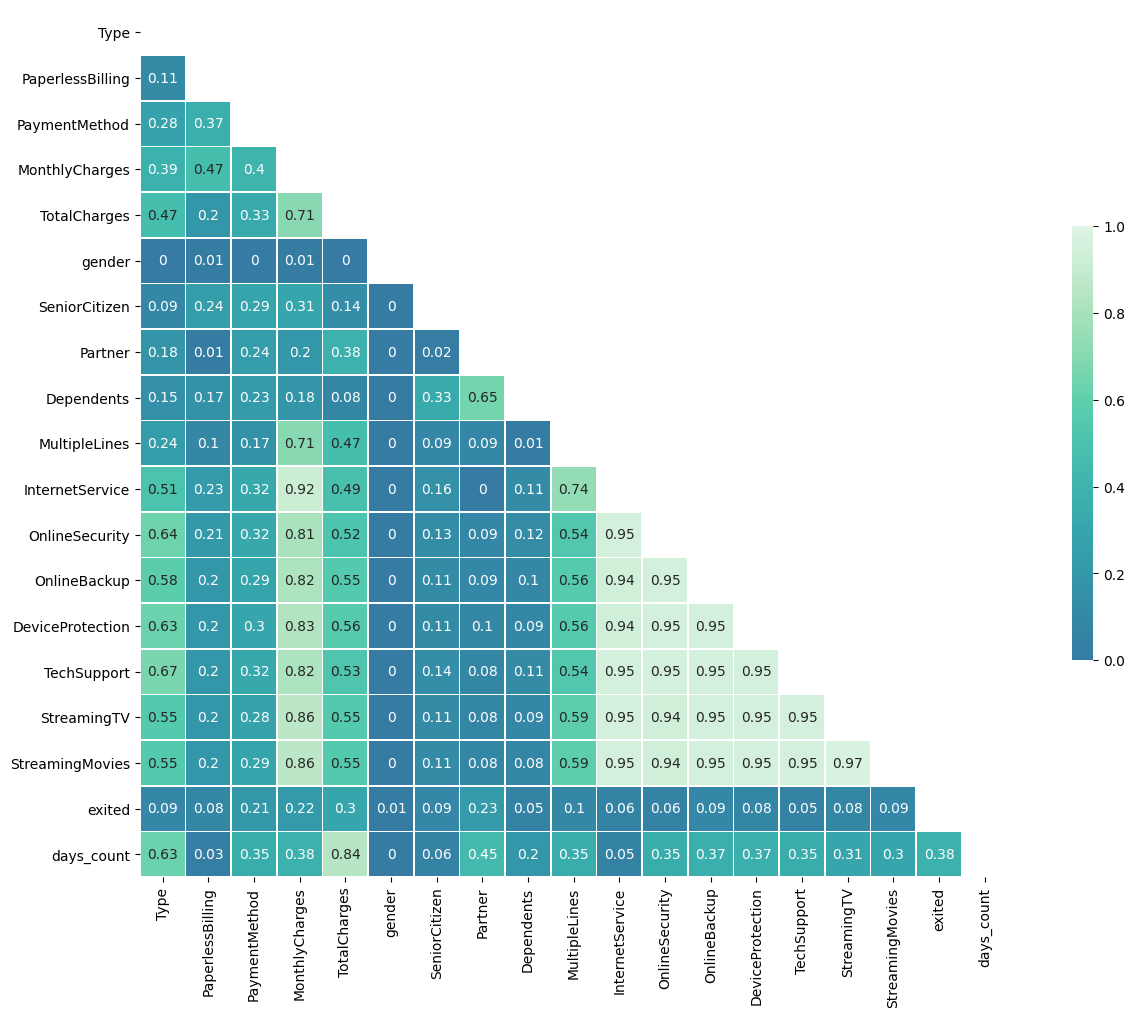

In [90]:
phik_corr_heatmap(data, interval_cols=['MonthlyCharges', 'TotalCharges', 'days_count'])

Зададимся порогом классификации 0.85 (сильно коррелирующие) и определим признаки, которые необходимо удалить.

1. Все дополнительные услуги сильно коррелируют между собой. Удалим из признаков `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`.
2. В паре `InternetService` и `MonthlyCharges` удалим первый признак. `MonthlyCharges` больше коррелирует с таргетом.
3. В паре `days_count` и `TotalCharges` удалим последний признак. `days_count` больше коррелирует с таргетом
4. Удалим `gender`. Ранее отмечали, что распределение клиентов по половому признаку идентичное и признак никакой пользы не несет в себе.

Удалим выбранные признаки и повторно построим тепловую карту.

In [91]:
data = data.drop(['OnlineSecurity',
                'OnlineBackup', 
                'DeviceProtection', 
                'TechSupport',
                'StreamingMovies', 
                'StreamingTV', 
                'InternetService', 
                'TotalCharges',
                'gender'], axis=1)

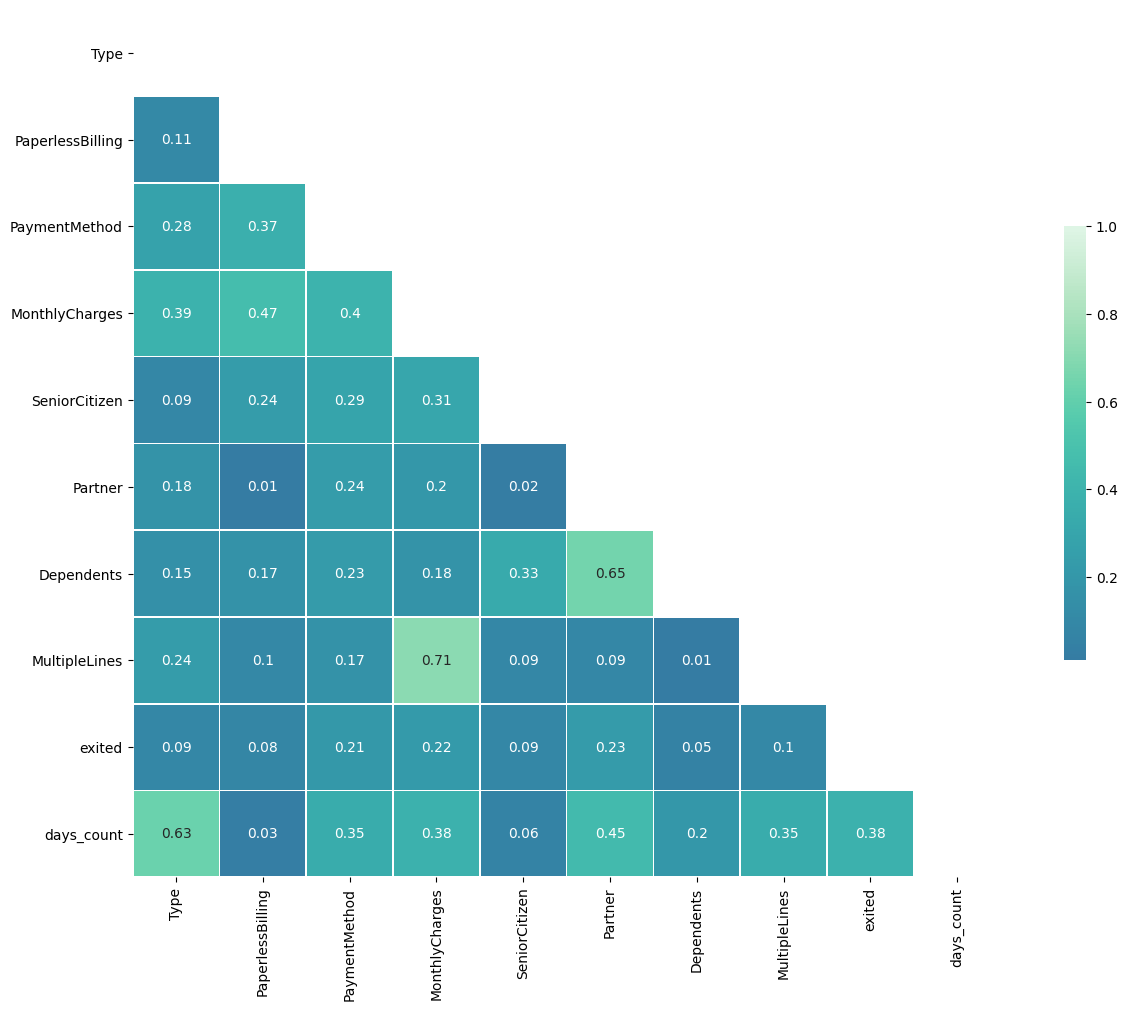

In [92]:
phik_corr_heatmap(data, interval_cols=['days_count', 'MonthlyCharges'])

Так выглядят данные после проделанных изменений.

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7028 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7028 non-null   object 
 1   PaperlessBilling  7028 non-null   object 
 2   PaymentMethod     7028 non-null   object 
 3   MonthlyCharges    7028 non-null   float64
 4   SeniorCitizen     7028 non-null   object 
 5   Partner           7028 non-null   object 
 6   Dependents        7028 non-null   object 
 7   MultipleLines     7028 non-null   object 
 8   exited            7028 non-null   int64  
 9   days_count        7028 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 604.0+ KB


### Дисбаланс целевого признака

Дисбаланс целевого признака - обычное явление в задачах с оттоком клиентов. Посмотрим насколько сильный дисбаланс.

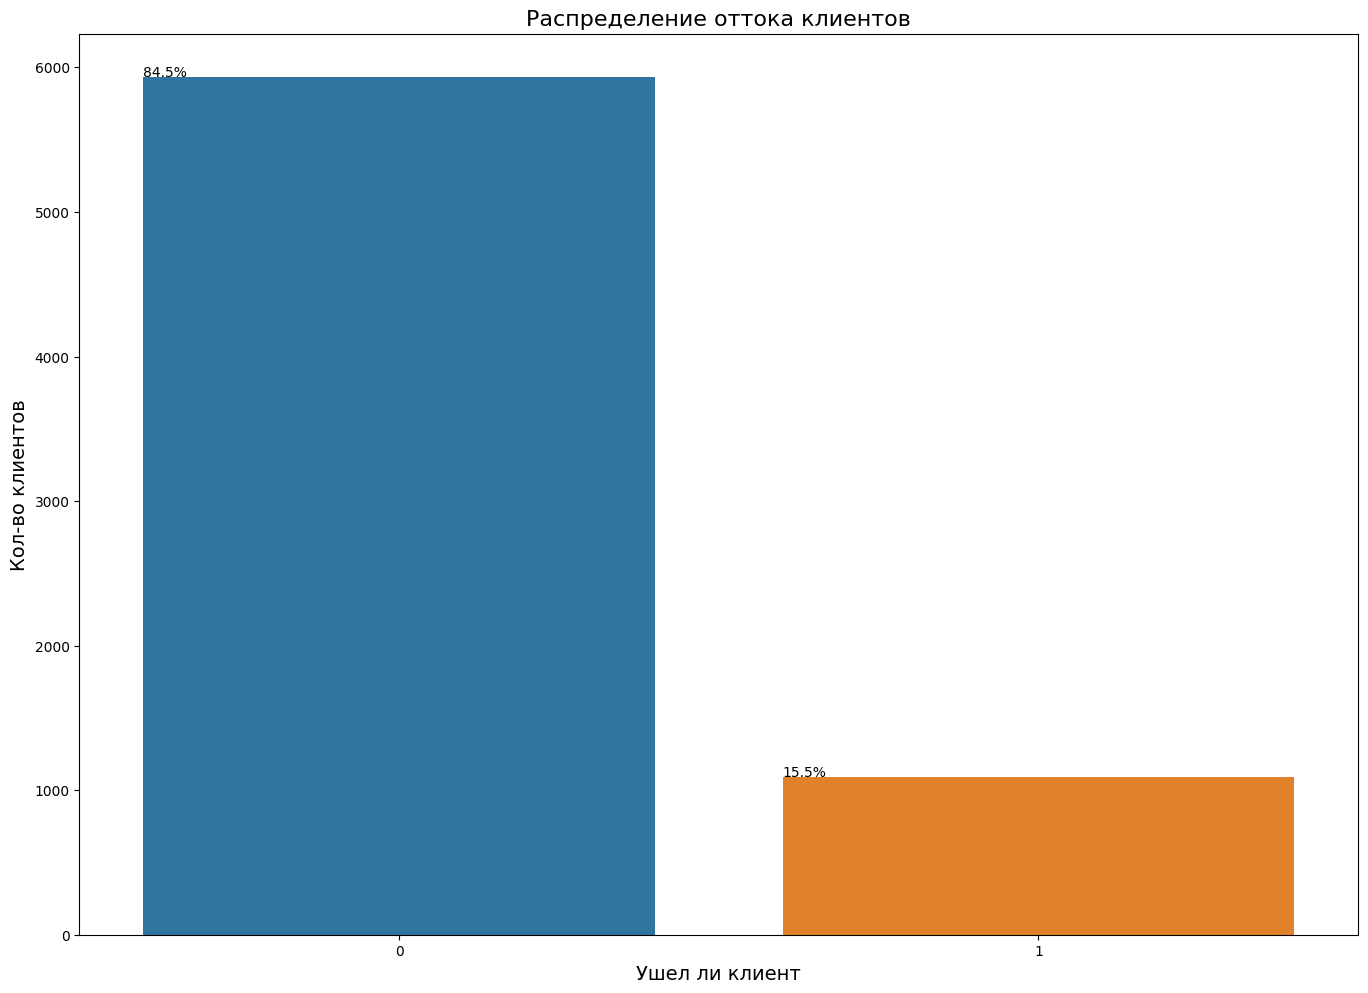

In [94]:
fig, ax = plt.subplots(figsize=(16.5,11.7))
plot = sns.countplot(data=data,  x=data['exited'])
total = len(data['exited'])
ax.set_title('Распределение оттока клиентов', fontsize=16)
ax.set_xlabel('Ушел ли клиент', fontsize=14)
ax.set_ylabel('Кол-во клиентов', fontsize=14)
for p in plot.patches:
    plot.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x(), p.get_height()))

Почти 16% клиентов из предоставленных данных разорвали договор, что является достаточно сильными дисбалансом. В проекте используется `ROC-AUC` метрика, которая нечувствительная к дисбалансу, поэтому не будем использовать методы по "борьбе" с дисбалансом.

### Вывод

В ходе данного этапа была выявлена проблема увеличивающегося оттока клиентов в предоставленных данных. Несмотря на то что в последние 4 месяца наблюдается высокий прирост новых клиентов, он остается на одном уровне. В то же время, отток клиентов с каждым месяцем увеличивается и за последний месяц достиг максимума. Клиентам, которые ушли, свойственно следующее:

* большие ежемесячные расходы;
* ежегодные типы оплаты услуг;
* оплачивает кредитной картой или банковским переводом;
* не является пенсионером;
* использует подключение к нескольким линиям;
* использует оптоволоконный тип связи подключения к интернету.

Почти все дополнительный услуги имеют примерно одинаковое количество пользователей с индентичным оттоком. За исключением услуги стримингового телевидения (`StreamingTV`). Клиентов, которые подключили эту услугу больше. Так же выделяется и отток среди них. 
Из всего этого можно сделать вывод, что интернет услуги предоставляемые компанией являются неактуальными для возможных клиентов. Скорее всего, у конкурентов интернет услуги более выгодны для потребителя. Так же есть проблемы с услугой `MultipleLine` (~30% оттока клиентов с этой услугой).

Так же проверили признаки на мультиколлинеарность. Известно, что такие признаки негативно влияют на линейные модели, а в задачах с оттоком часто используют именно такие модели. Удалили из данных сильно коррелирующие признаки (порог корреляции > 0.85), а именно `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingMovies`, `StreamingTV`,`InternetService`, `TotalCharges`, `gender`.

После удаления ненужных признаков из 20 предоставленных признаков осталось 10 признаков. Один признак целевой (`exited`).

## Подготовка выборок для машинного обучения

Для дальнейшего обучения моделей выполним следующие шаги: 
1. Разделим данные на две выборки: тренировочную и тестовую. Делить будем так, чтобы в выборках была примерно такая же пропорциональность классов, что и в основном датасете.
2. Сделаем пайплайн для кодировки признаков.

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7028 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7028 non-null   object 
 1   PaperlessBilling  7028 non-null   object 
 2   PaymentMethod     7028 non-null   object 
 3   MonthlyCharges    7028 non-null   float64
 4   SeniorCitizen     7028 non-null   object 
 5   Partner           7028 non-null   object 
 6   Dependents        7028 non-null   object 
 7   MultipleLines     7028 non-null   object 
 8   exited            7028 non-null   int64  
 9   days_count        7028 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 862.0+ KB


### Выборки

Разделим выборки с помощью метода `train_test_split` из бибилотеки `scikit-learn` в соотношении 3:1. Учтем дисбаланс классов и сохраним пропорции оттока в этих выборках с помощью аргумента `stratify`.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('exited',axis=1), 
    data['exited'], 
    test_size=0.25, 
    random_state=RANDOM_STATE, 
    stratify=data['exited']
)

In [97]:
# проверим размерность выборок
sample_list = [X_train, y_train, X_test, y_test]
for sample in sample_list:
    print(sample.shape)

(5271, 9)
(5271,)
(1757, 9)
(1757,)


Данные разделены верно по количеству.

In [98]:
# проверим признаки
print("Тренировочная выборка:")
ICD(X_train.head())
ICD(X_train.info())
print("Тестовая выборка:")
ICD(X_test.head())
ICD(X_test.info())


Тренировочная выборка:


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,MultipleLines,days_count
378,Two year,No,Electronic check,89.65,0,No,No,Yes,1857
3860,Month-to-month,Yes,Credit card (automatic),25.35,0,No,Yes,no_sub,580
2597,One year,Yes,Electronic check,109.60,0,Yes,No,Yes,2163
4218,Month-to-month,Yes,Bank transfer (automatic),25.05,0,No,No,Yes,215
5620,Two year,Yes,Bank transfer (automatic),104.80,0,Yes,No,Yes,1155


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5271 entries, 378 to 2525
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5271 non-null   object 
 1   PaperlessBilling  5271 non-null   object 
 2   PaymentMethod     5271 non-null   object 
 3   MonthlyCharges    5271 non-null   float64
 4   SeniorCitizen     5271 non-null   object 
 5   Partner           5271 non-null   object 
 6   Dependents        5271 non-null   object 
 7   MultipleLines     5271 non-null   object 
 8   days_count        5271 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 411.8+ KB


None

Тестовая выборка:


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,MultipleLines,days_count
3173,One year,No,Mailed check,19.35,0,Yes,No,No,518
5811,Two year,No,Bank transfer (automatic),80.90,0,Yes,No,Yes,821
1226,Two year,No,Bank transfer (automatic),24.65,0,Yes,No,Yes,1308
6805,One year,Yes,Bank transfer (automatic),105.55,1,Yes,No,Yes,2132
5123,Month-to-month,Yes,Credit card (automatic),75.30,1,No,No,No,518


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1757 entries, 3173 to 6517
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              1757 non-null   object 
 1   PaperlessBilling  1757 non-null   object 
 2   PaymentMethod     1757 non-null   object 
 3   MonthlyCharges    1757 non-null   float64
 4   SeniorCitizen     1757 non-null   object 
 5   Partner           1757 non-null   object 
 6   Dependents        1757 non-null   object 
 7   MultipleLines     1757 non-null   object 
 8   days_count        1757 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 137.3+ KB


None

Данные разделены.

### Кодировка признаков

В проекте применяется линейная модель (LogisticRegression) и дерево решений (DecisionTreeClassifier). Для линейной модели закодируем категориальные и количественные признаки, а для дерева решений только категориальные признаки.

Разделим столбцы по типу данных и запишем их в два списка.

In [99]:
# Категориальные признаки:
cat_features = list(X_train.select_dtypes(include='object').columns)
cat_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines']

In [100]:
# Количественные признаки
num_features = list(X_train.select_dtypes(exclude='object').columns)
num_features

['MonthlyCharges', 'days_count']

Сделаем пайплайн кодировки данных для. Воспользуемся 3 препроцессорами:

1. Нормализация числовых данных (`StandardScaler`).
2. One-hot кодирование категориальных данных для линейных моделей (`OneHotEncoder`).
3. Ordinal кодирование категориальных данных для древесных и бустинговых моделей (`OrdinalEncoder`).

In [101]:
# нормализация
num_pipe = Pipeline(steps=[
    ('scale', StandardScaler())
])
# фиктивные переменные для логистической регрессии
cat_ohe_pipe = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse_output=False, drop='first'))
])
# переменные для древесной модели
cat_oe_pipe = Pipeline(steps=[
    ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

Воспользуемся классом `ColumnTransformer` из `sklearn` и объединим нужные преобразования в зависимости от типа модели.

In [102]:
# для линейной модели
col_trans_lin = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipe, num_features),
    ('cat_pipeline', cat_ohe_pipe, cat_features)
    ],
    remainder='drop',
    n_jobs=-1)

In [103]:
# для древесной модели
col_trans_dt = ColumnTransformer(transformers=[
    ('cat_pipeline', cat_oe_pipe, cat_features)
    ],
    remainder='drop',
    n_jobs=-1)

Для бустинговой модели воспользуемся внутренним кодировщиком.

Данные для обучения моделей готовы.

## Обучение моделей

Воспользуемся тремя алгоритмами машинного обучения. Оптимизируем гиперпараметры методом основанным на байесовской статистике с помощью библиотеки `optuna`, вычислим метрику `ROC AUC` на кросс-валидации и выберем лучшую модель.

1. Logistic regression.
    * Для обучения используется пайплайн с кодировкой категориальных признаков (OHE) и количественных признаков (стандартизация).
2. Decision tree classifier.
    * Для обучения используется только кодировка категориальных признаков.
3. CatBoost classifier.
    * Для обучения используется внутренняя кодировка.
    
Данные были разбиты на выборки так, чтобы сохранить пропорциональность целевого таргета. Для вычисления основной метрики используется кросс-валидация. Чтобы сохранить пропорциональность во время кросс-валидации, воспользуемся методом из `scikit-learn` `StratifiedKFold`.

### Logistic Regression

In [104]:
def logreg_objective(trial):
    # словарь гиперпараметров для оптимизации
    param_grid = {
        'max_iter': trial.suggest_int('max_iter', 100, 2000),
        'C': trial.suggest_float('C', 0.001, 1),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
        
    }
    # классификатор с выбранными гиперпараметрами
    estimator = LogisticRegression(**param_grid, random_state=RANDOM_STATE)
    # пайплайн с кодировкой данных и моделью
    clf_pipeline = Pipeline(steps=[
        ('col_trans', col_trans_lin),
        ('model', estimator)
    ])
    # вычисление метрики на основе обученного пайплайна на кросс-валидации
    scores = cross_val_score(
        clf_pipeline, 
        X_train, y_train, 
        cv=StratifiedKFold(n_splits=5), 
        scoring='roc_auc')
    
    return scores.mean()

In [105]:
logreg_study = optuna.create_study(direction='maximize')
logreg_study.optimize(logreg_objective, n_trials=15)
logreg_best_value = round(logreg_study.best_value, 3)
logreg_best_params = logreg_study.best_params

In [106]:
print('Лучшее значение ROC AUC:', logreg_best_value)
print('Лучшие гиперпараметры:', logreg_best_params)

Лучшее значение ROC AUC: 0.748
Лучшие гиперпараметры: {'max_iter': 1401, 'C': 0.27858690534295516, 'solver': 'lbfgs'}


Для модели `LogisticRegression` оптимизировали гиперпараметры и вывели оценку на кросс-валидации.

### Decision Tree Classifier

In [107]:
def dt_objective(trial):
    
    param_grid = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8)       
    }
    estimator = DecisionTreeClassifier(**param_grid, random_state=RANDOM_STATE)
    clf_pipeline = Pipeline(steps=[
        ('col_trans_dt', col_trans_dt),
        ('model', estimator)
    ])
    scores = cross_val_score(
        clf_pipeline, 
        X_train, y_train, 
        cv=StratifiedKFold(n_splits=5), 
        scoring='roc_auc')
    
    return scores.mean()

In [108]:
dt_study=optuna.create_study(direction='maximize')
dt_study.optimize(dt_objective, n_trials=15)
dt_best_value = round(dt_study.best_value, 3)
dt_best_params = dt_study.best_params

In [109]:
print('Лучшее значение ROC AUC:', dt_best_value)
print('Лучшие гиперпараметры:', dt_best_params)

Лучшее значение ROC AUC: 0.691
Лучшие гиперпараметры: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}


Для `DecisionTreeClassifier` оптимизировали гиперпараметры и вывели оценку на кросс-валидации.

### CatBoost Classifier

In [110]:
def cb_objective(trial):
    
    param_grid = {
        "depth": trial.suggest_int("depth", 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.05, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 40)
        
    }
    estimator = CatBoostClassifier(**param_grid, cat_features=cat_features, random_state=RANDOM_STATE, silent=True)
    
    scores = cross_val_score(
        estimator, 
        X_train, y_train, 
        cv=StratifiedKFold(n_splits=5), 
        scoring='roc_auc')
    
    return scores.mean()

In [111]:
# для воспроизводимости результата воспользуемся сэмплером 
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)

In [112]:
cb_study=optuna.create_study(direction='maximize', sampler=sampler)
cb_study.optimize(cb_objective, n_trials=20)
cb_best_value = round(cb_study.best_value, 3)
cb_best_params = cb_study.best_params

In [113]:
print('Лучшее значение ROC AUC:', cb_best_value)
print('Лучшие гиперпараметры:', cb_best_params)

Лучшее значение ROC AUC: 0.918
Лучшие гиперпараметры: {'depth': 3, 'learning_rate': 0.09965873410052829, 'subsample': 0.5958063812480533, 'colsample_bylevel': 0.8518851764169839, 'min_data_in_leaf': 27}


Для `CatBoostClassifier` оптимизировали гиперпараметры и вывели оценку на кросс-валидации.

### Сравнение метрики

Сравним значения метрики.

In [114]:
data_metrics = {'Classifier': ['Logistic Regression', 'Decision Tree Classifier', 'CatBoost Classifier'],
                 'ROC AUC': [logreg_best_value, dt_best_value, cb_best_value]
    }
df = pd.DataFrame(data=data_metrics)
df

,Classifier,ROC AUC
0,Logistic Regression,0.748
1,Decision Tree Classifier,0.691
2,CatBoost Classifier,0.918


CatBoost Classifier имеет самое высокое значение `ROC AUC`. Воспользуемся этой моделью для оценки тестовой выборки.

## Тестирование лучшей модели

Вычислим значение `ROC AUC` и дополнительно `accuracy` на тестовой выборке, используя подобранные гиперпараметры

In [115]:
model = CatBoostClassifier(random_state=RANDOM_STATE, **cb_best_params, verbose=False, cat_features=cat_features)
model.fit(X_train, y_train)

print('Значение ROC AUC на тестовой выборке:', round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),3))
print('Значение Точности на тестовой выборке:', round(accuracy_score(y_test, model.predict(X_test)),3))

Значение ROC AUC на тестовой выборке: 0.927
Значение Точности на тестовой выборке: 0.917


В данном случае метрика `Accuracy` является дополнительной метрикой. Она показывает долю правильных ответов по отношению ко всем ответам. То есть процент верных ответов для нашей модели составляет 92%.

### Важность признаков

Посмотрим на важность признаков в модели.

In [116]:
feature_imp = pd.DataFrame({'feature_importance': model.get_feature_importance(), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

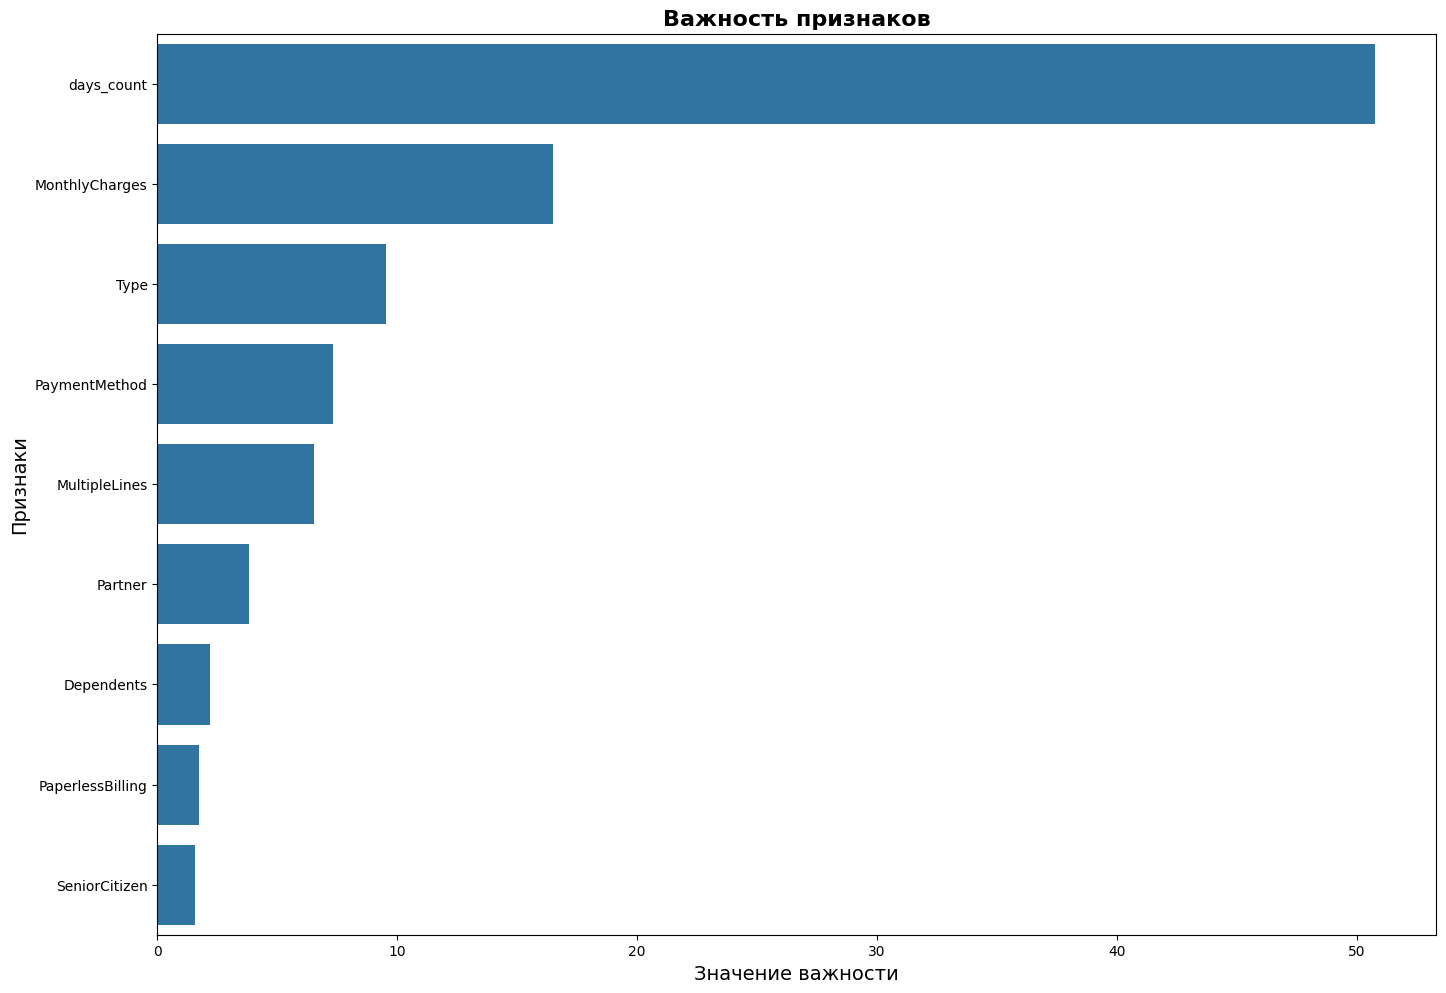

In [117]:
fig, ax = plt.subplots(figsize=(16.5,11.7))
sns.barplot(data=feature_imp, x='feature_importance', y='feature_names', color='tab:blue')
ax.set_title("Важность признаков", fontsize=16, fontweight='bold')
plt.xlabel('Значение важности',fontsize=14)
plt.ylabel('Признаки',fontsize=14)
plt.show()

In [118]:
feature_imp.set_index('feature_names')

,feature_importance
feature_names,
days_count,50.765313
MonthlyCharges,16.480915
Type,9.526254
PaymentMethod,7.334002
MultipleLines,6.550493
Partner,3.820076
Dependents,2.187299
PaperlessBilling,1.746768
SeniorCitizen,1.588880


Выделим основные признаки по важности:

**1.** `days_count` - количество дней пользователь является клиентов. Введенный новый признак на основе даты начала оказания услуг и разрыва договора. Сильно выделяется на фоне других признаков.

**2.** `MonthlyCharges` - ежемесячные траты так же имеют вес в принятии решении, заметно ниже по сравнению с `days_count`.

**3.** `Type` и `PaymentMethod` - имеют примерно одинаковое значение важности.

**4.** `MultipleLines` - значение важности заметно меньше, но имеется вес по сравнению с оставшимися признаками.


Влияние остальных признаков незначительное. В дальнейшем их можно удалить, чтобы ускорить обучение и предсказания модели.

### ROC кривая и матрица ошибок

Построим кривую ROC и матрицу ошибок.

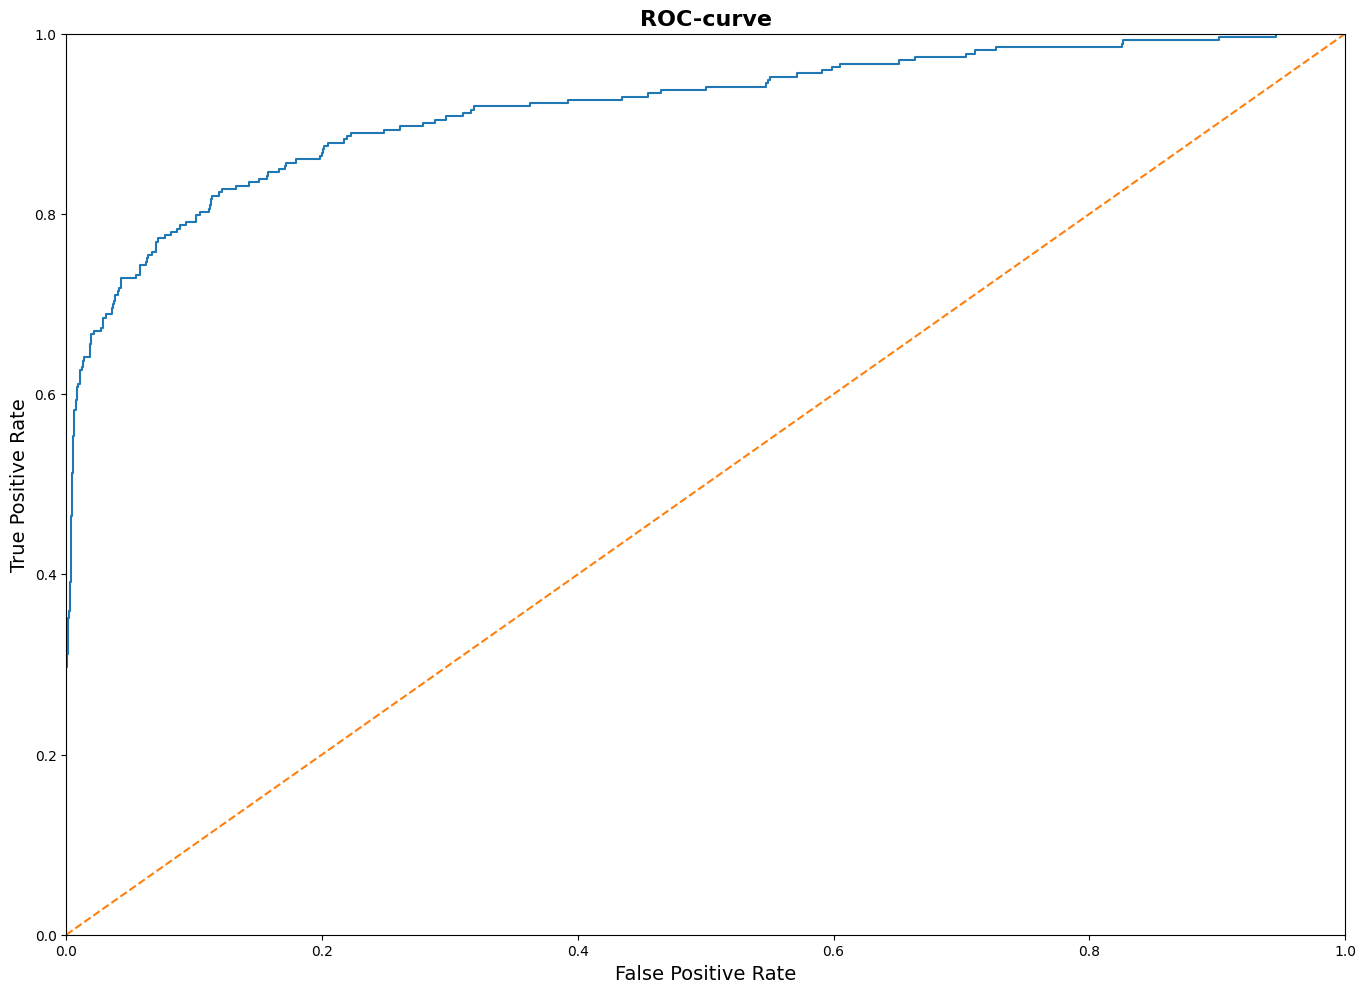

In [119]:
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test) 

plt.figure()
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC-curve', fontsize=16, fontweight='bold')
plt.show()

In [120]:
con_matrx = confusion_matrix(y_test, model.predict(X_test))

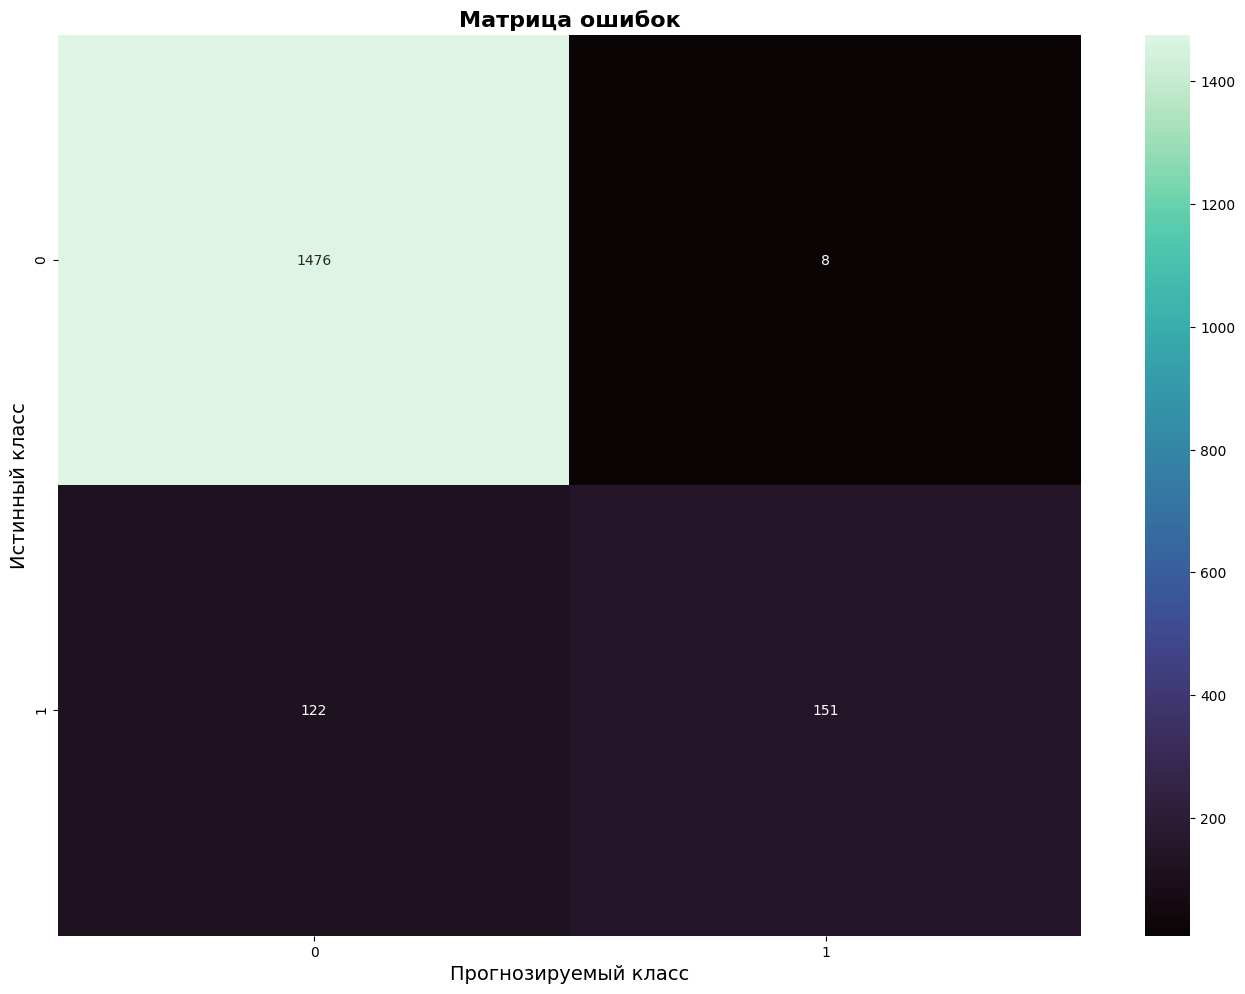

In [121]:
fig, ax = plt.subplots()
sns.heatmap(con_matrx, annot=True, fmt='g', cmap='mako')
ax.set_title('Матрица ошибок', fontsize=16, fontweight='bold')
ax.set_xlabel('Прогнозируемый класс', fontsize=14)
ax.set_ylabel('Истинный класс', fontsize=14);

In [122]:
y_test.value_counts()

0    1484
1     273
Name: exited, dtype: int64

Тестовая выборка состоит из 2106 записей. Из графика `ROC` кривой и матрицы ошибок можно сделать вывод, что:

**1.** Модель 1478 раз верно предсказала, что клиент останется.

**2.** Модель 164 раза верно предсказала, что клиент уйдет.

**3.** Модель 6 раз ошиблась и не верно предсказала, что клиент уйдет.

**4.** Модель 109 раза ошиблась и не верно предсказала, что клиент останется.

## Итоговый вывод

В ходе исследования были выполнены следующие шаги:

1. Ознакомились с данными из четырех датасетов и соединили в один по ключу клиентов.
2. Выполнили предобработку данных, а именно:
    * заполнили пропущенные значения, которые появились после объединения данных, третьей категорией `no_sub`, так как есть клиенты которые пользуются не всеми услугами;
    * изменили типы данных в признаках, где они не соответствовали ожиданиям;
    * дубликатов не было выявлено;
    * аномальных значений не обнаружено;
3. Создали новый признак (количество дней действовал или действует договор) на основе имеющихся двух других признаков (начало договора и расторжение договора)
4. Выполнили исследовательский анализ данных. Посмотрели на распределение следующих количественных признаков:
    * количество новых клиентов по месяцам;
    * количество покинувших клиентов по месяца;
    * суммарный и месячный расход на услуги;
    * по этим данным выявили проблему нарастающего оттока клиентов.

Так же просмотрели распределение категориальных признаков и выявили, многие из этих признаков не влияют, либо влияют незначительно на решение клиента.

Некоторые признаки имели сильную корреляцию между собой. Удалили такие признаки, исходя из их негативного влияние на качество моделей машинного обучения. Таким образом удалили почти все дополнительные интернет услуги, оставит только стриминговое телевидение. Удалили столбец с полом клиента. И удалили суммарные расходы в виду того, что этот признак имел корреляцию с признаком количества дней действия договора. А так как последний признак коррелирует сильнее с целевым таргетом, то оставили его. В итоге из 7043 записей и 20 признаков осталось 7032 записи и 10 признаков, включая целевой. Целевой признак определили из даты конца договора.

5. Подтвердили наличие дисбаланса классов (84% - действующих клиентов и 16% - ушедших). Подготовили выборки для машинного обучения. Разбили датасет в соотношении 3:1. С помощью методов библиотеки scikit-learn разбиение выполнили примерно в такой же пропорции классов, что и в самом датасете. Сделали пайплайн для линейной модели (one hot encoding и стандартизация количественных переменных) и модели решающего дерева (one hot encoding).

6. Далее перешли к обучению моделей и подсчету метрики `ROC-AUC` на кросс-валидации. Деление выборок так же выполняли, сохраняя пропорциональность классов. Протестировали три модели с подбором гиперпараметров:
   * Логистическая регрессия;
   * Решающее дерево;
   * Градиентный бустинг на решающих деревьев.
Лучший результат на кросс-валидации показала последняя модель `CatBoostClassifier`.

7. Пороговое значение метрики `ROC AUC` по заданию 0.85. Модель показала отличный результат с значением 0.92 на тестовой выборке. Дополнительно подсчитали `accuracy` Проанализировали влияние признаков на решение модели и выделили следующие как самые важные:
    * `days_count` - количество дней действия договора;
    * `MonthlyCharges` - трата за месяц;
    * `Type` - тип оплаты, где выделялось влияние типа `Month-to-month`.

На основе матрицы ошибок определили, что модель: 
1. 1941 раз верно предсказала, что клиент останется.
2. 229 раз верно предсказала, что клиент уйдет.
3. 17 раз ошиблась и не верно предсказала, что клиент уйдет.
4. 134 раза ошиблась и не верно предсказала, что клиент останется.

Точность предсказаний модели составила 93%.

Исходя из проанализированных данных можно сказать, что предоставляемые услуги интернет подключения теряют свою актуальность, либо довольно низкого качества. Верным решением будет проанализировать отзывы по предоставляемым услугам. Отток клиентов, вполне возможно, связан с появлением конкурентов с лучшими условиями подключения и предоставления услуг. Так же есть проблемы в услуге стриминговое телевидение. 